# Análisis descriptivo

In [1]:
from src.utils import (
  COLUMNA_OBJETIVO,
  VARIABLES_NUMERICAS,
  VARIABLES_CATEGORICAS,
  PREDICTORES_CATEGORICOS,
  PREDICTORES_NUMERICOS
)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
datos = (pd
  .read_csv('census_income/census-income.csv')
  # Descartar la columna de identificador de filas (primary key)
  [[*VARIABLES_NUMERICAS, *PREDICTORES_CATEGORICOS, COLUMNA_OBJETIVO]]
)

# Corregir los tipos de variables
for var_numerica in VARIABLES_NUMERICAS:
  datos[var_numerica] = pd.to_numeric(datos[var_numerica], errors = 'coerce')

for var_categorica in VARIABLES_CATEGORICAS:
  datos[var_categorica] = pd.Categorical(datos[var_categorica])

datos

age  wage per hour  capital gains  capital losses   
0        73              0              0               0  \
1        58              0              0               0   
2        18              0              0               0   
3         9              0              0               0   
4        10              0              0               0   
...     ...            ...            ...             ...   
199518   87              0              0               0   
199519   65              0           6418               0   
199520   47              0              0               0   
199521   16              0              0               0   
199522   32              0              0               0   

        dividends from stocks  num persons worked for employer   
0                           0                                0  \
1                           0                                1   
2                           0                                0   
3                           0                                0   
4                           0                                0   
...                       ...                              ...   
199518                      0                                0   
199519                      9                                1   
199520                    157                                6   
199521                      0                                0   
199522                      0                                6   

        weeks worked in year  instance weight   
0                          0          1700.09  \
1                         52          1053.55   
2                          0           991.95   
3                          0          1758.14   
4                          0          1069.16   
...                      ...              ...   
199518                     0           955.27   
199519                    52           687.19   
199520                    52          1923.03   
199521                     0          4664.87   
199522                    52          1830.11   

                        class of worker detailed industry code  ...   
0                       Not in universe                      0  ...  \
1        Self-employed-not incorporated                      4  ...   
2                       Not in universe                      0  ...   
3                       Not in universe                      0  ...   
4                       Not in universe                      0  ...   
...                                 ...                    ...  ...   
199518                  Not in universe                      0  ...   
199519       Self-employed-incorporated                     37  ...   
199520                  Not in universe                      0  ...   
199521                  Not in universe                      0  ...   
199522                          Private                     42  ...   

       family members under 18 country of birth father   
0              Not in universe           United-States  \
1              Not in universe           United-States   
2              Not in universe                 Vietnam   
3         Both parents present           United-States   
4         Both parents present           United-States   
...                        ...                     ...   
199518         Not in universe                  Canada   
199519         Not in universe           United-States   
199520         Not in universe                  Poland   
199521    Both parents present           United-States   
199522         Not in universe                       ?   

       country of birth mother country of birth self   
0                United-States         United-States  \
1                United-States         United-States   
2                      Vietnam               Vietnam   
3                United-States         United-States   
4                United-States         United-States   
...    

## Análisis por variable

### Variables categóricas

In [3]:
# Número de predictores categóricos
len(PREDICTORES_CATEGORICOS)

33

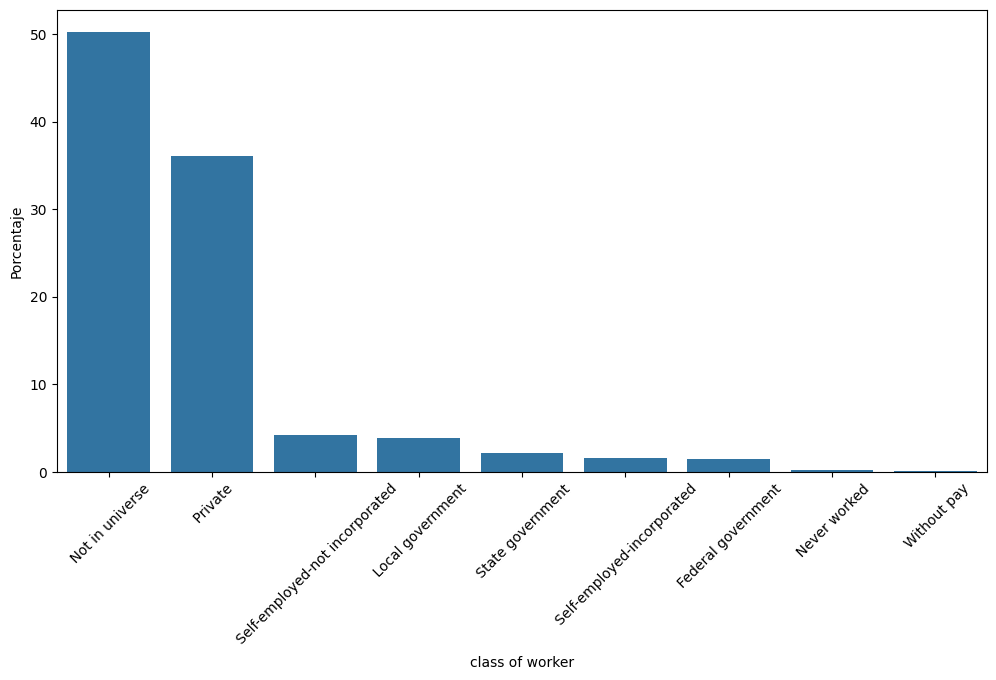

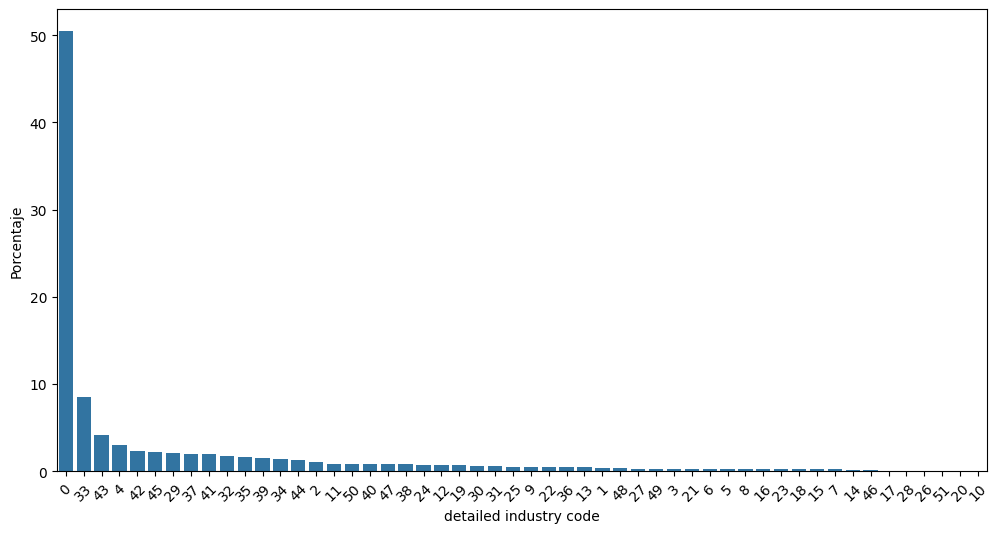

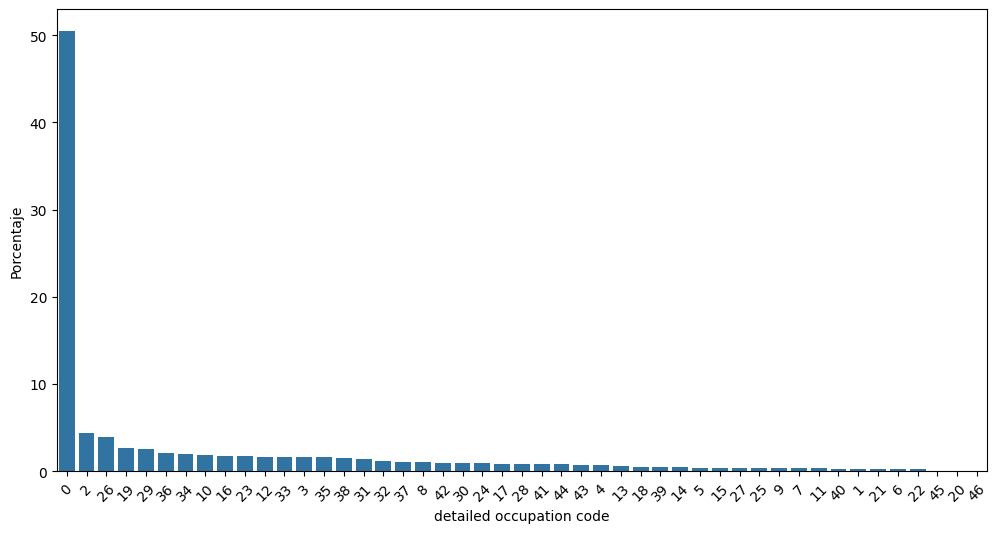

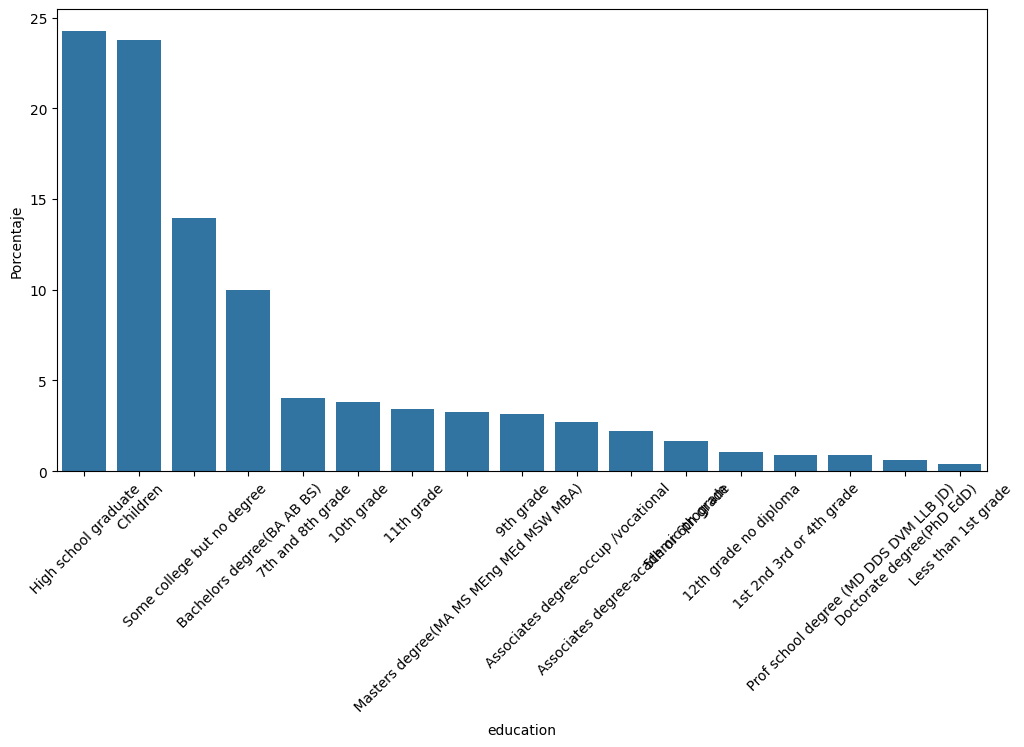

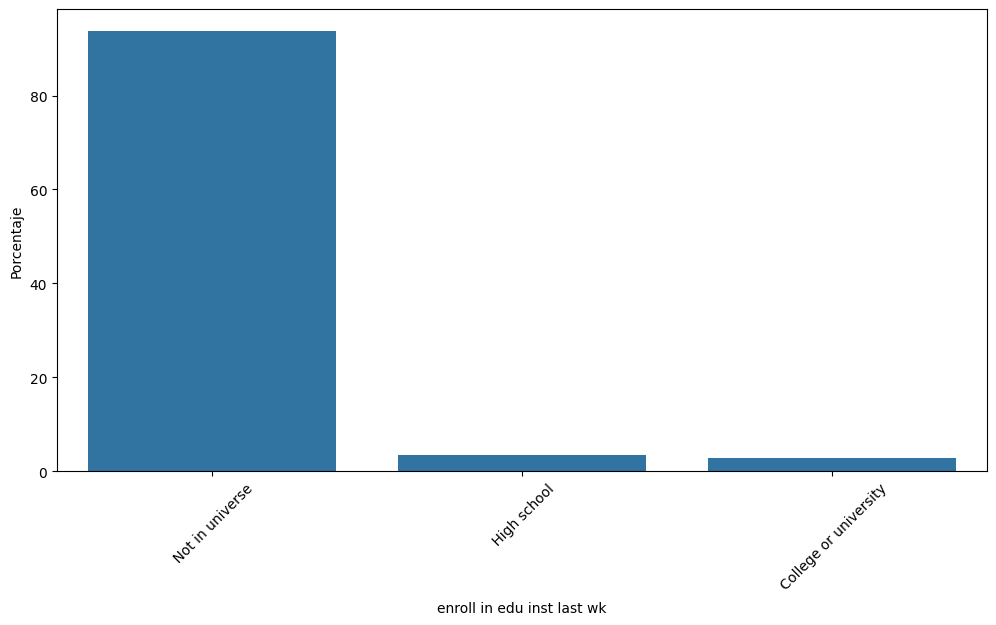

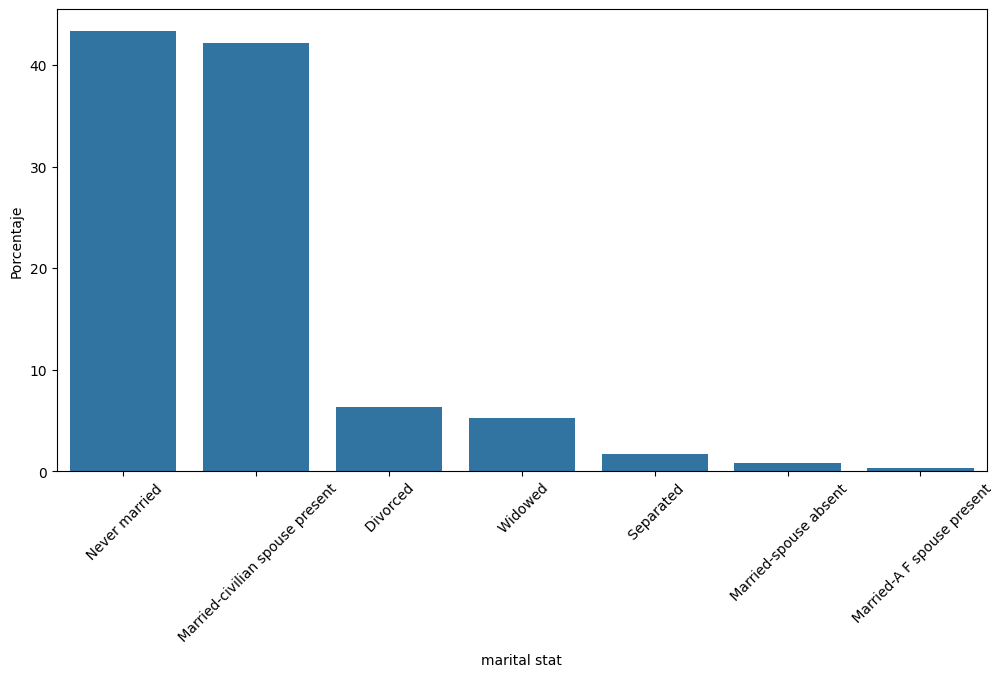

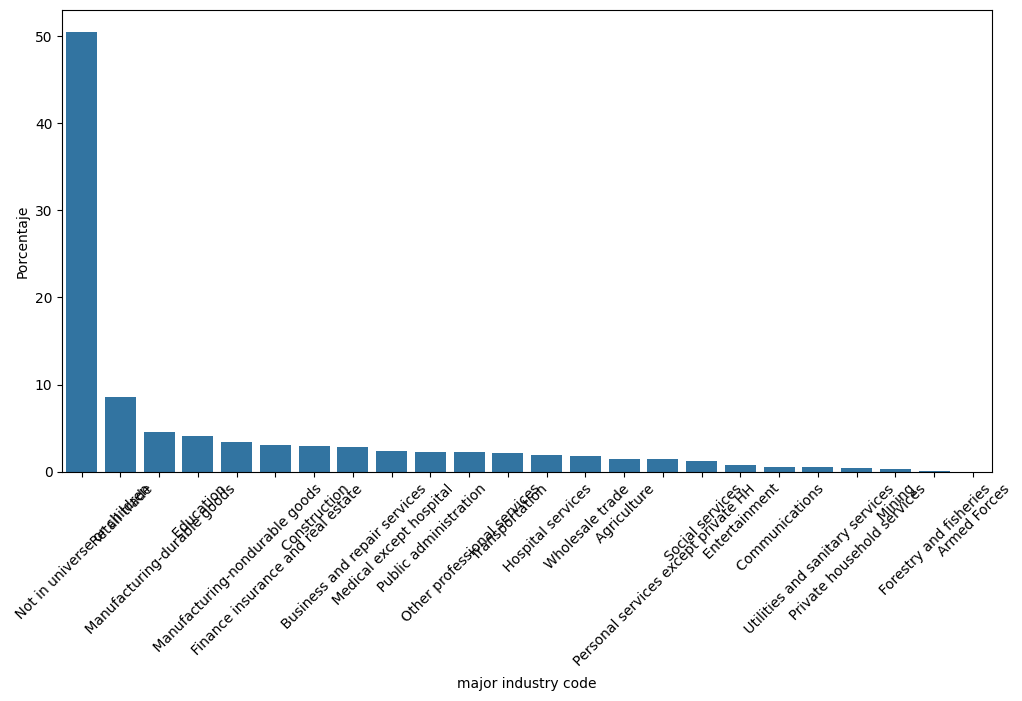

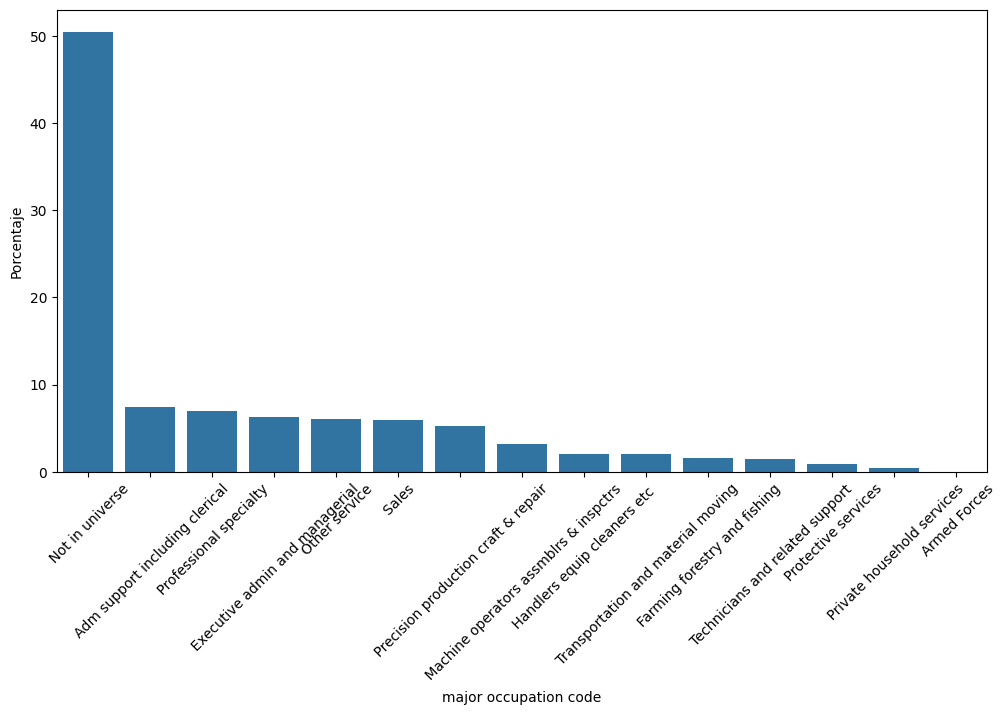

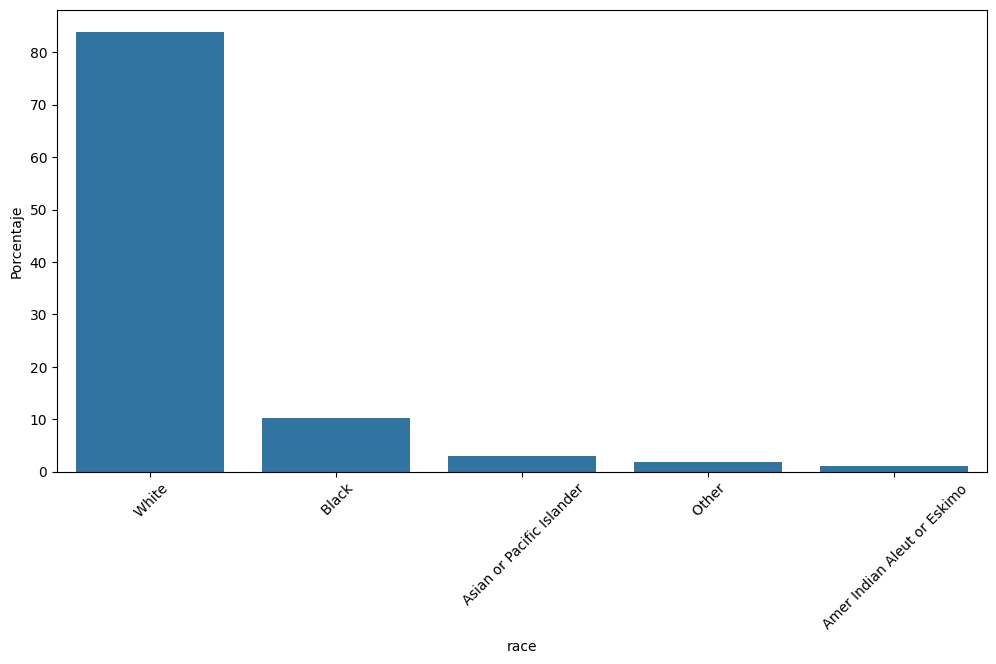

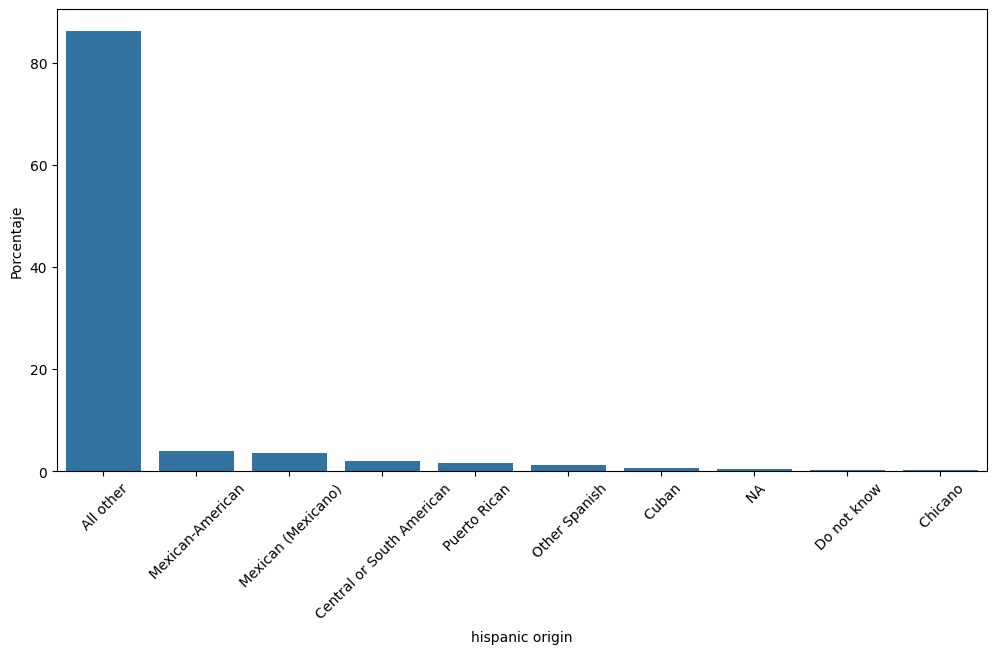

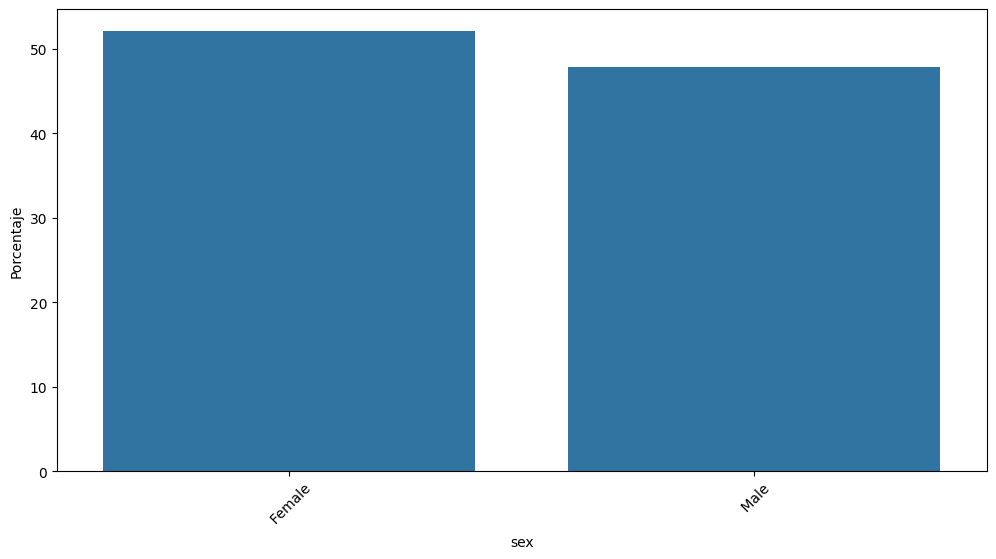

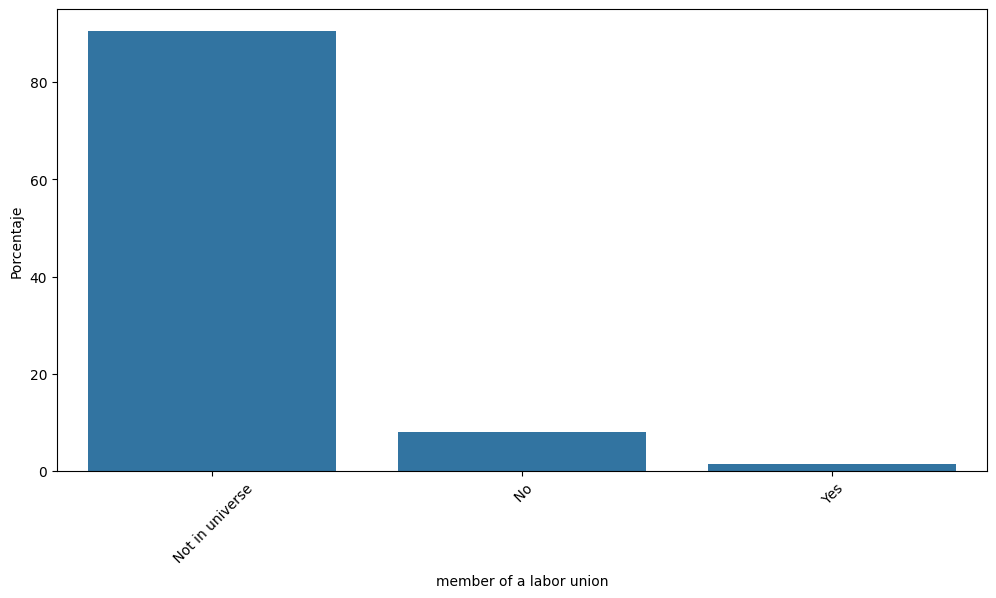

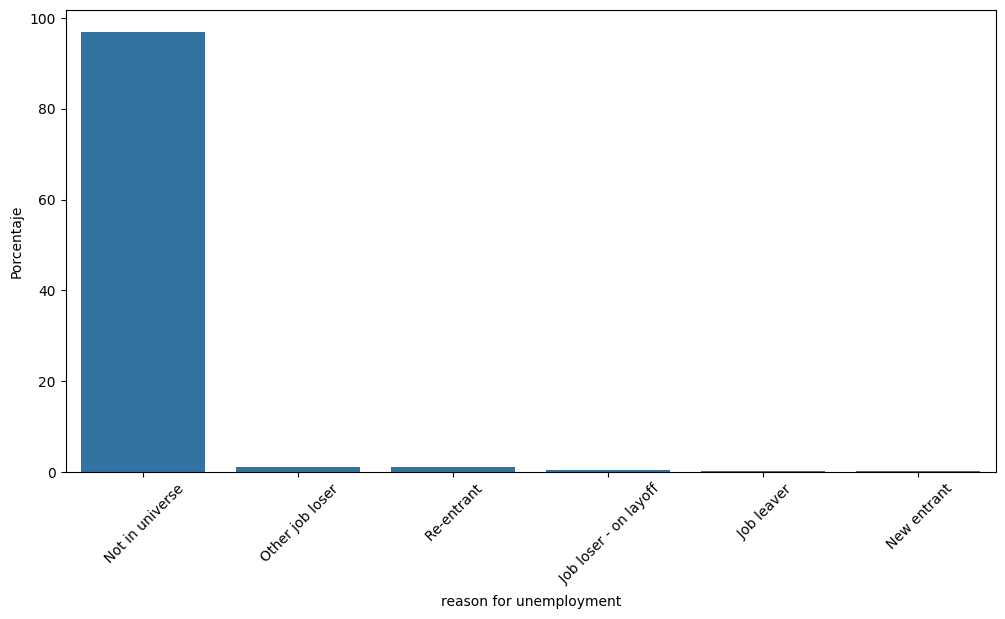

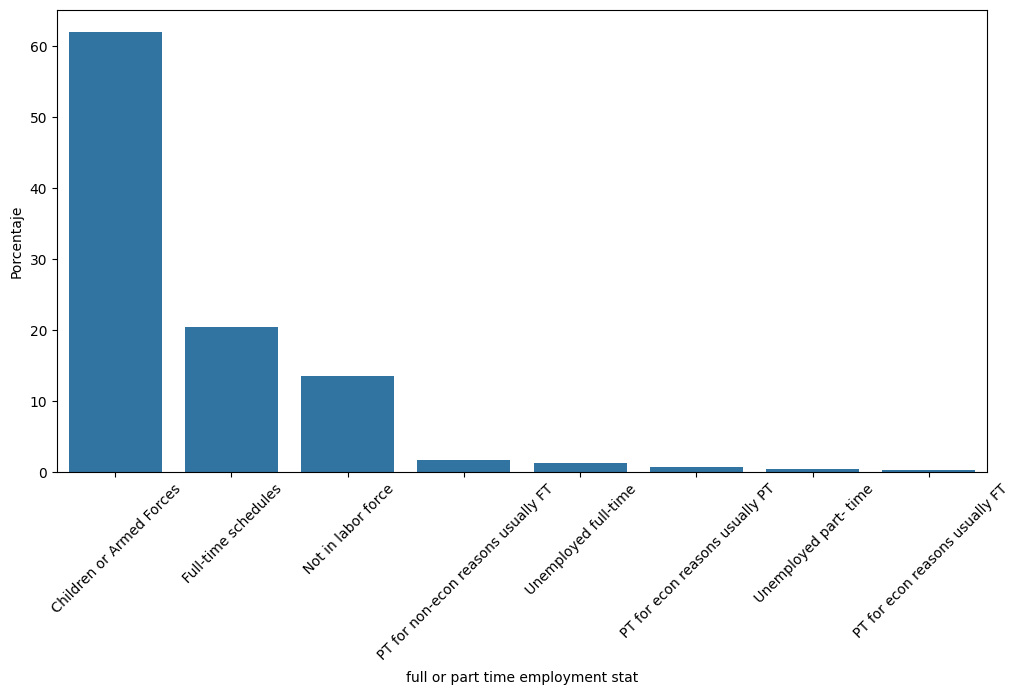

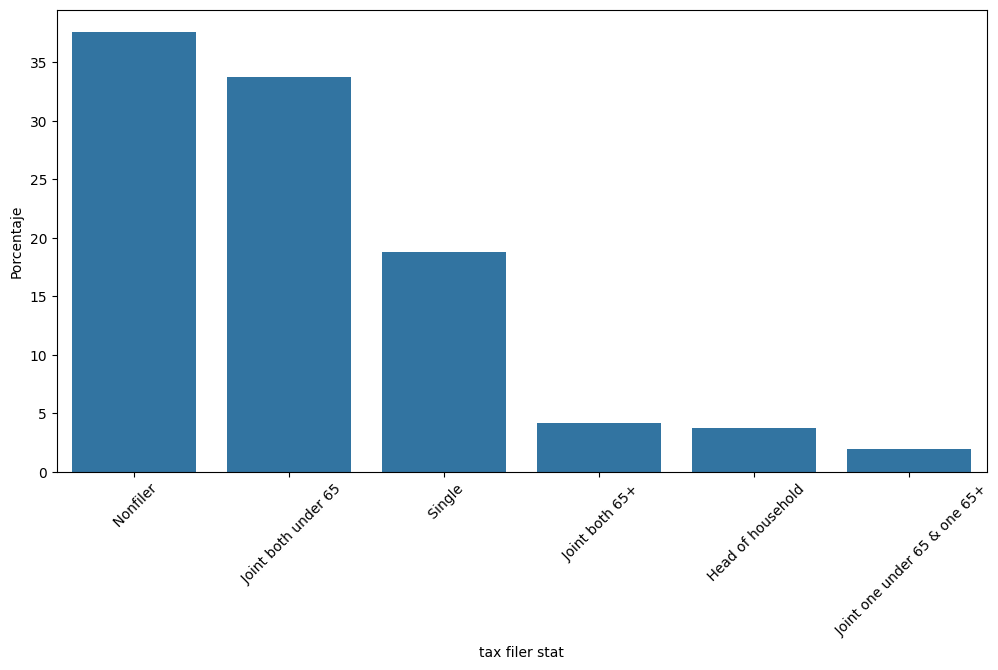

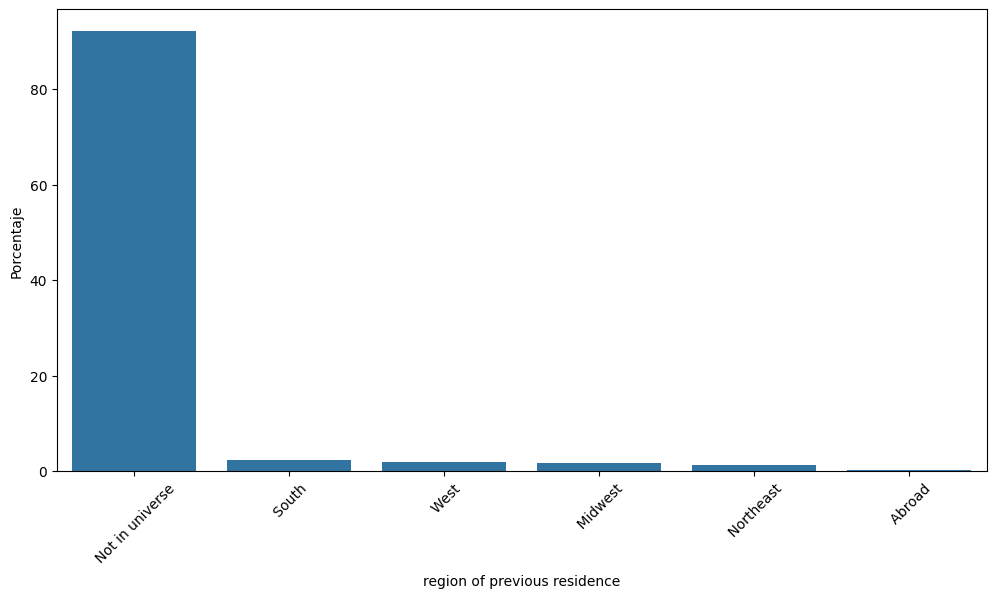

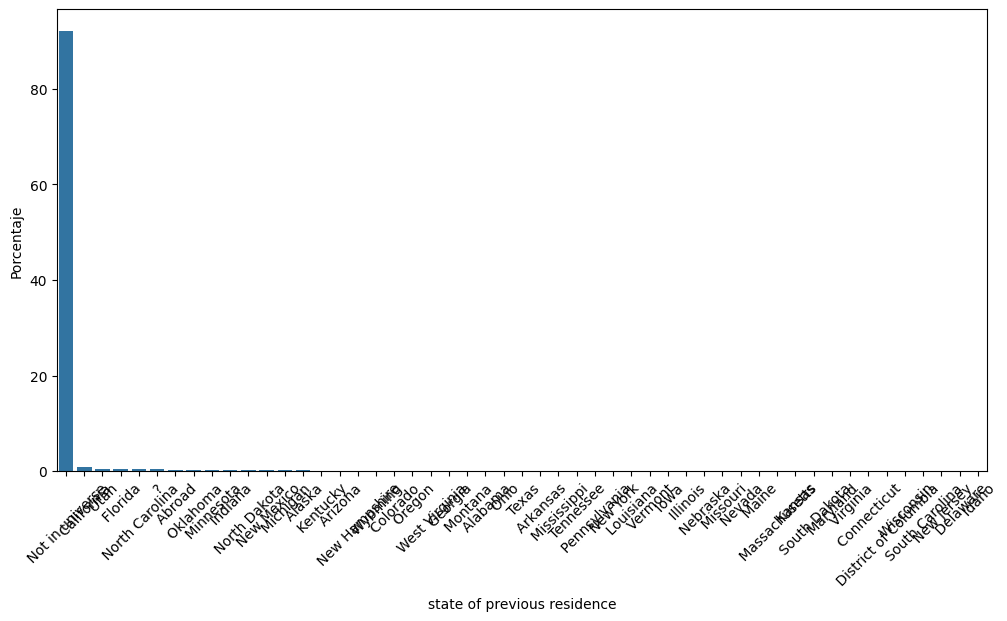

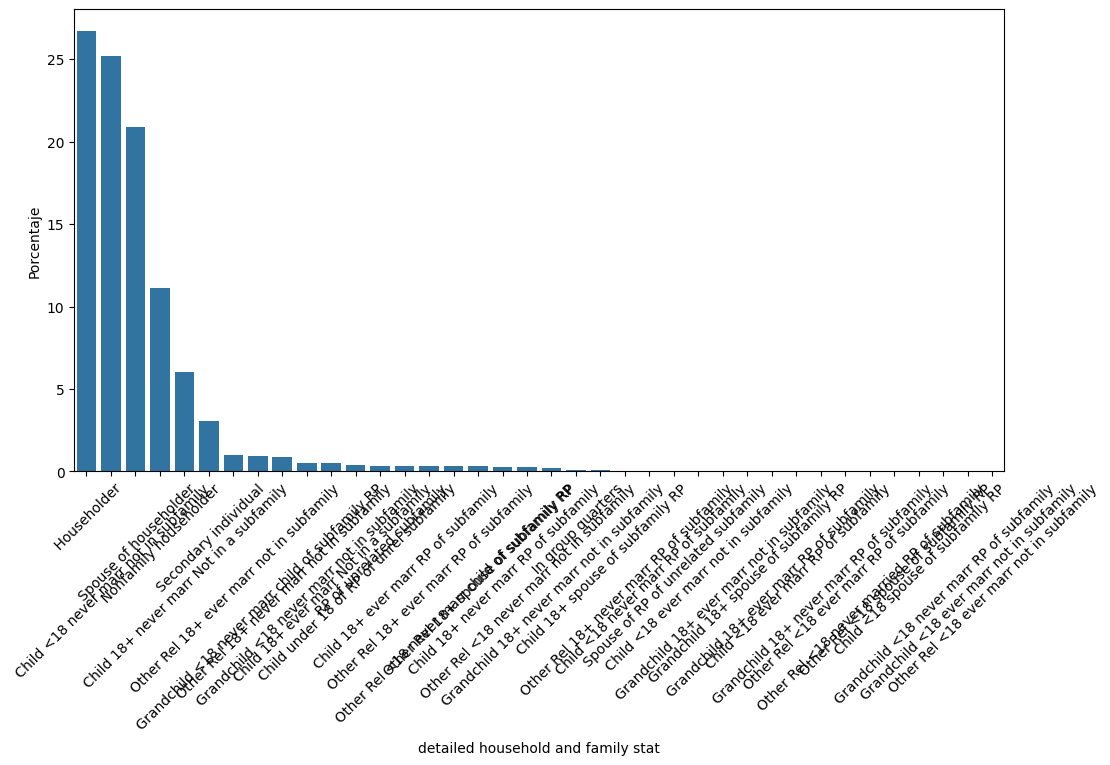

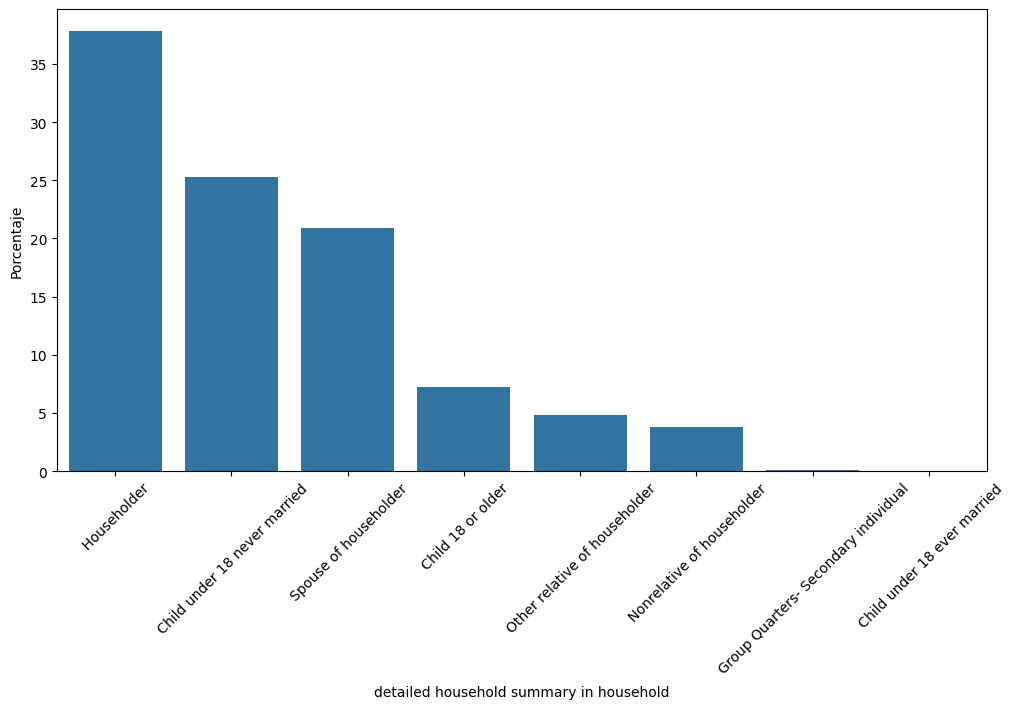

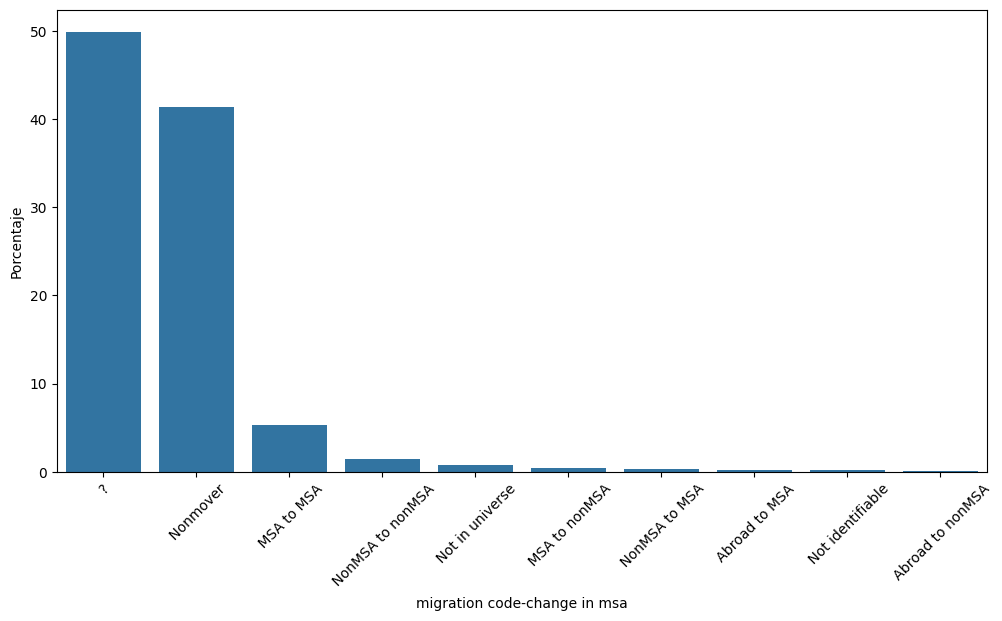

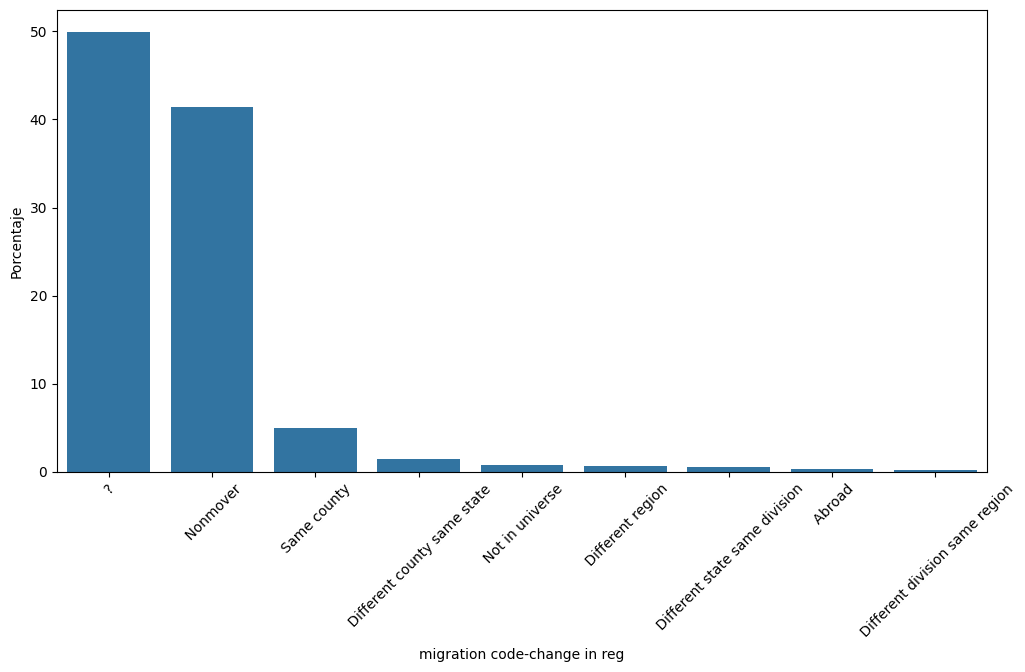

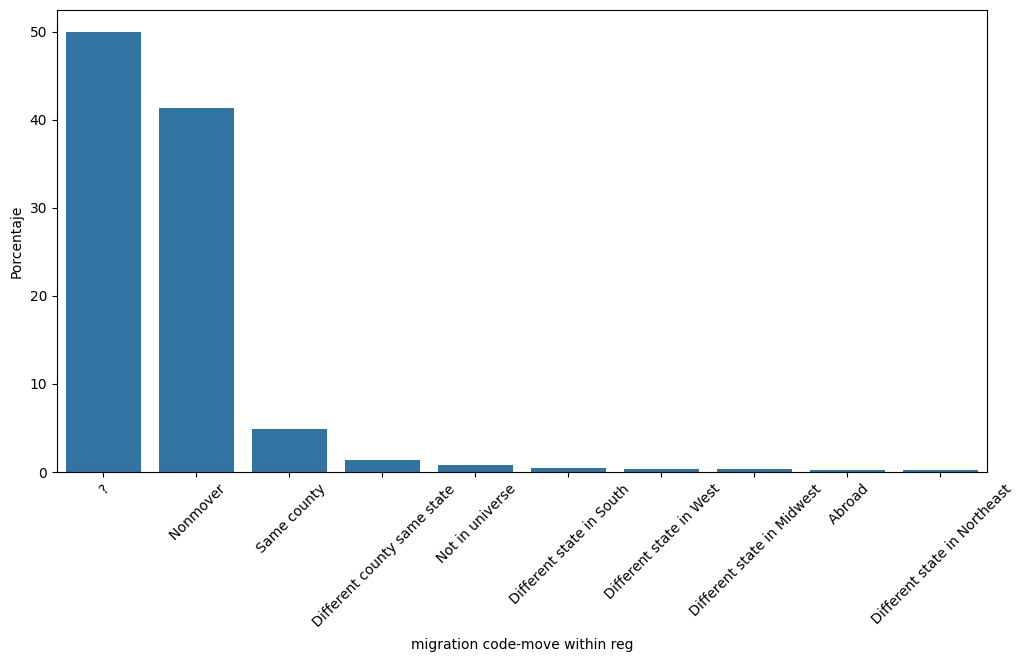

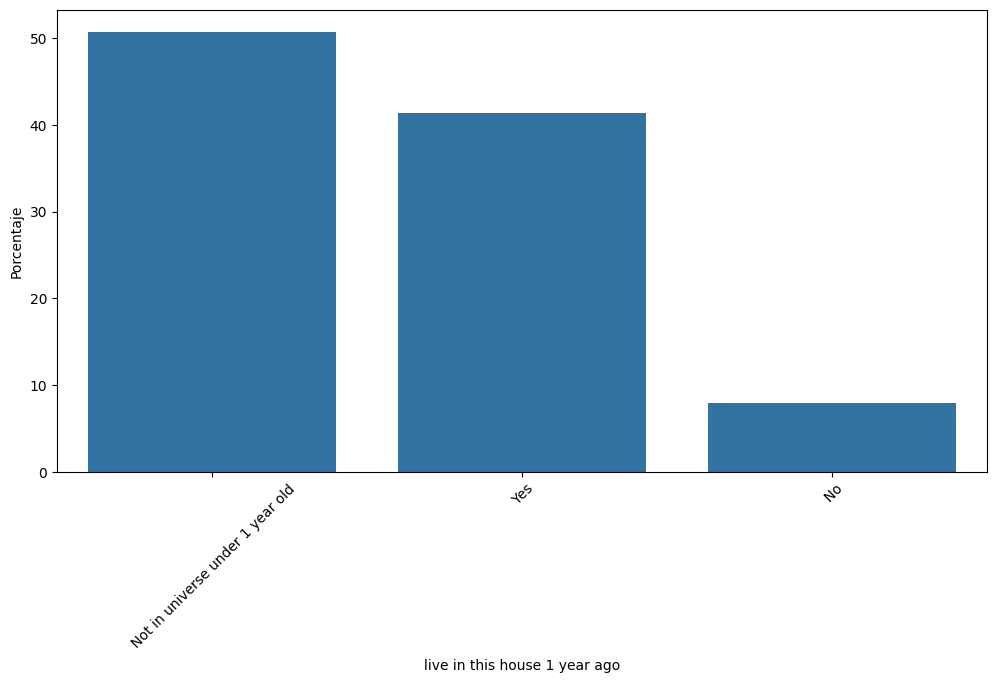

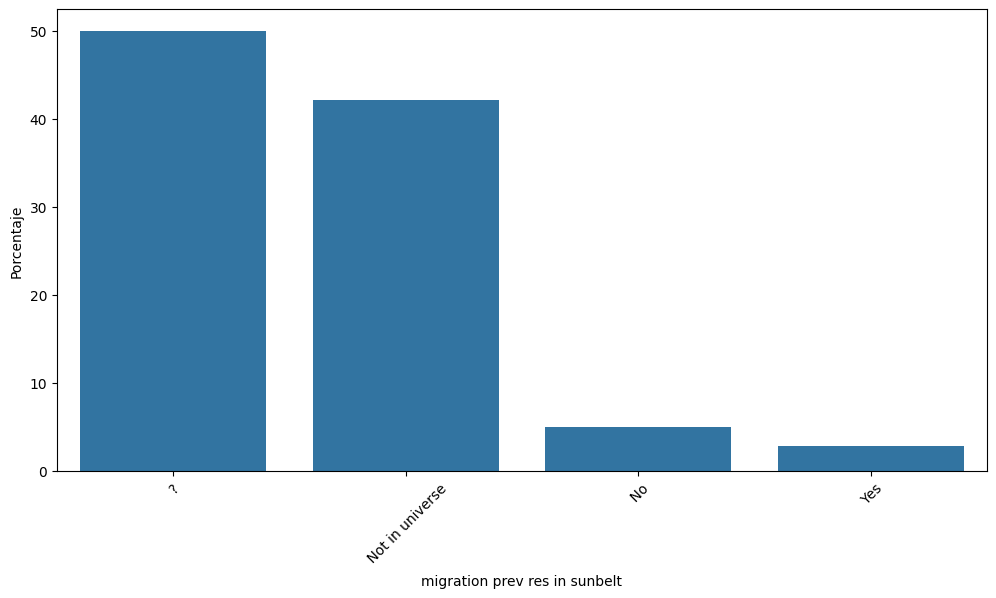

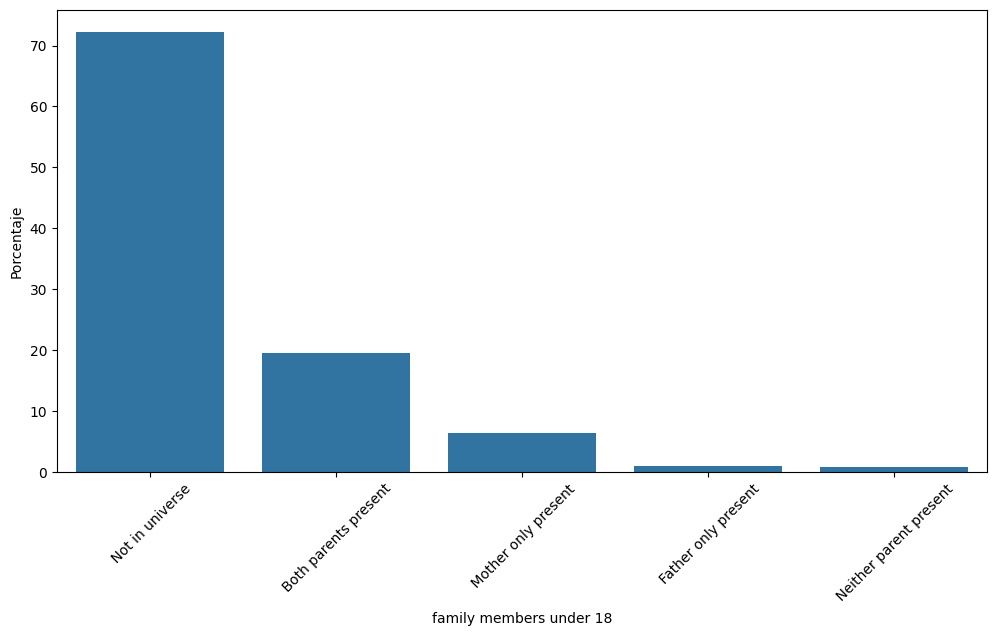

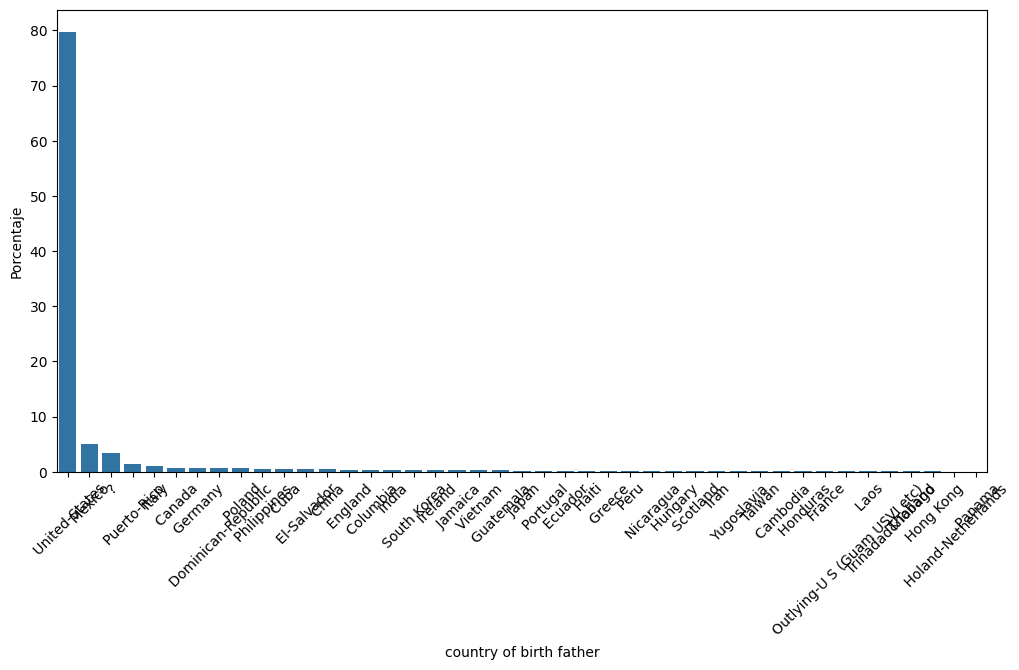

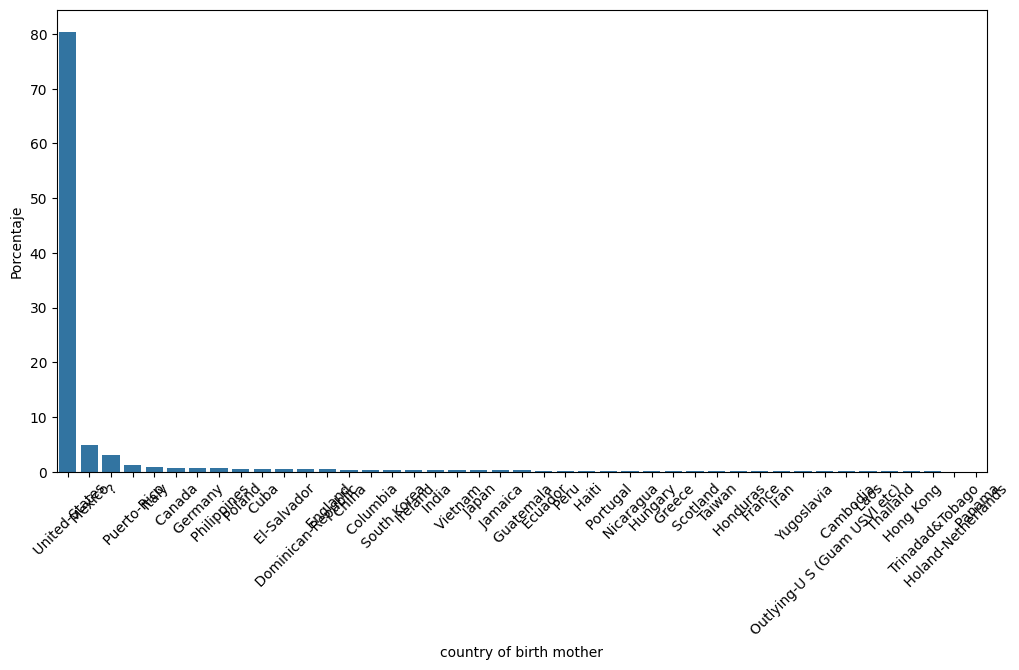

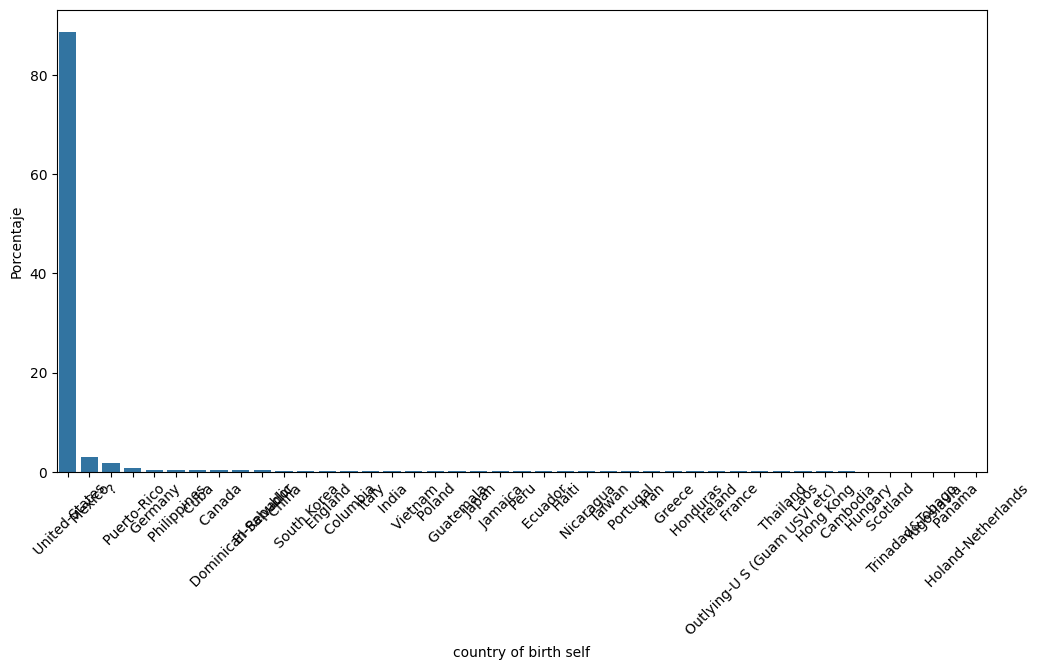

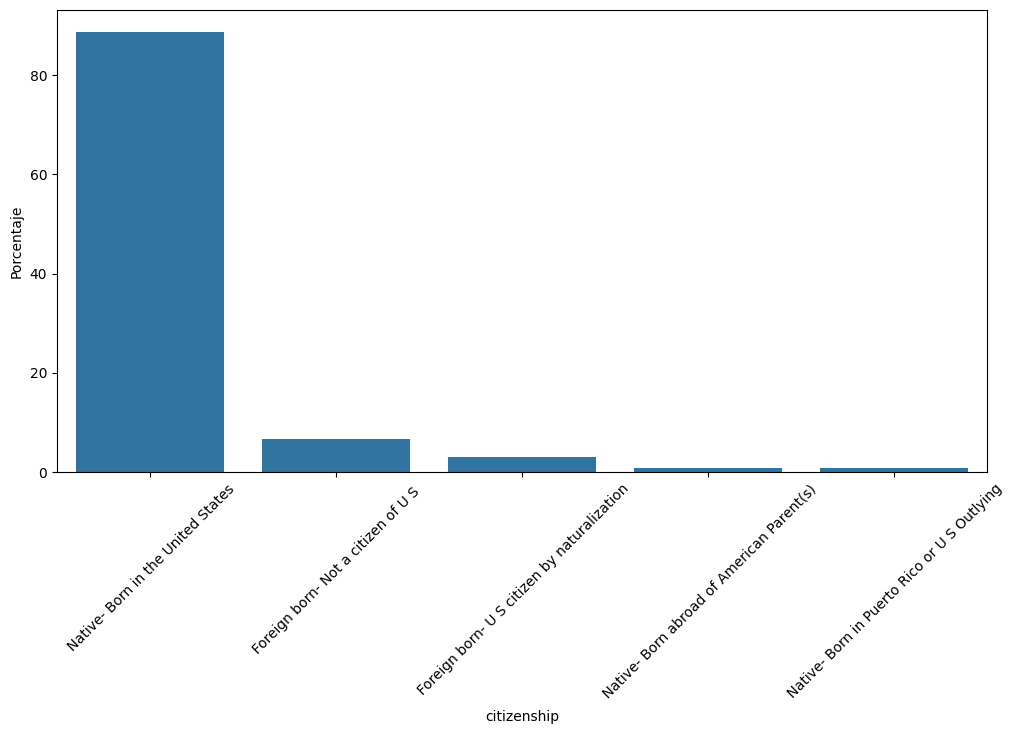

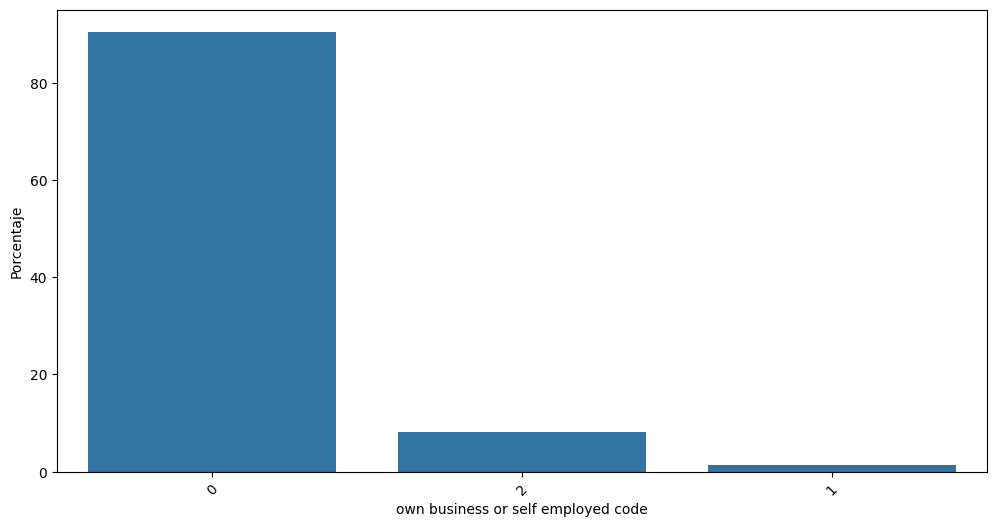

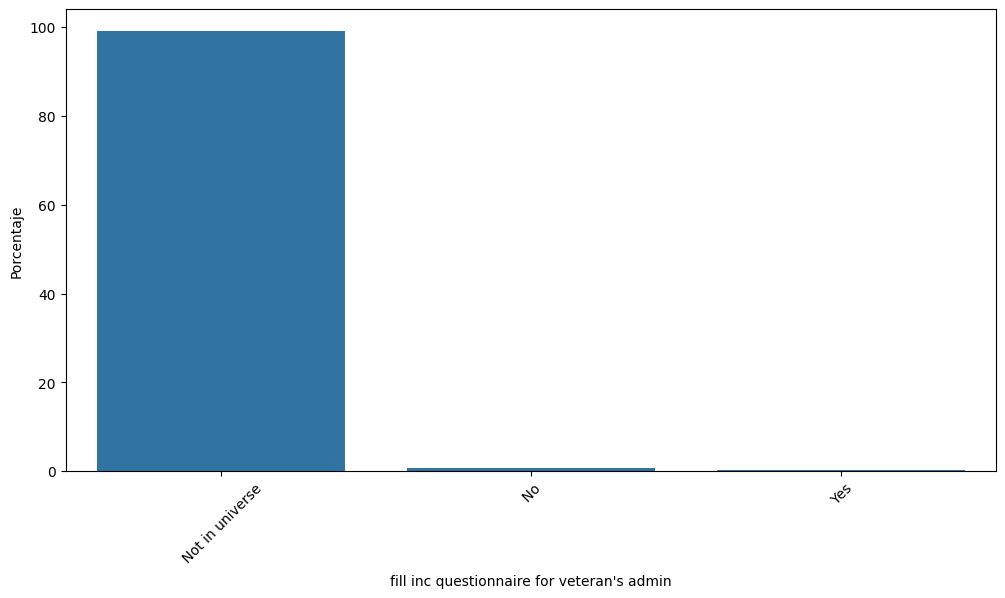

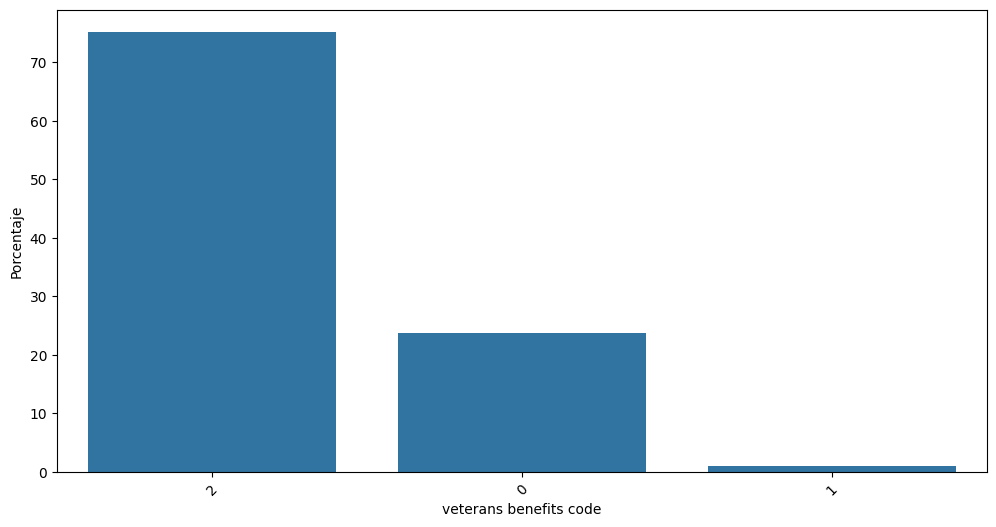

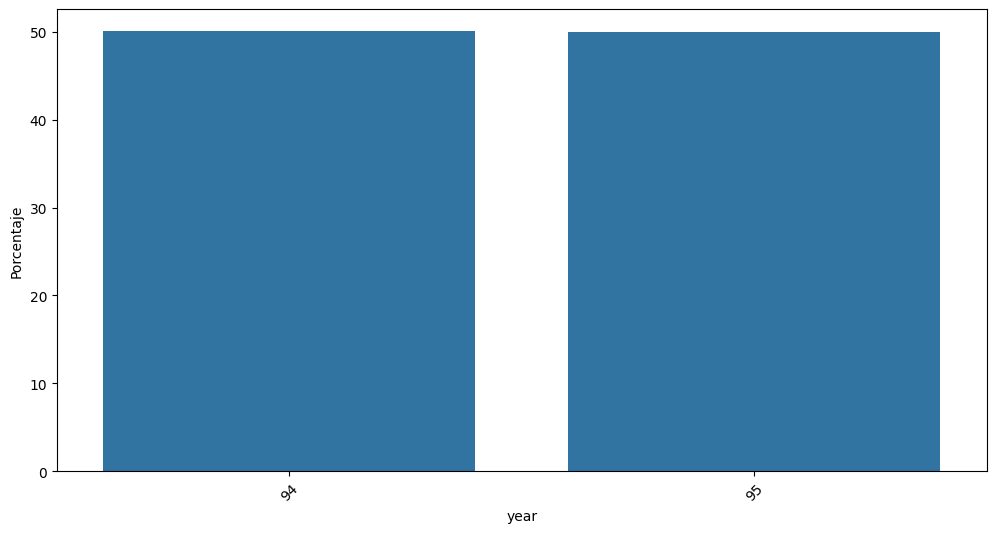

In [4]:
# Porcentajes de cada predictor categórico
num_observaciones = datos.shape[0]
for var_cat in PREDICTORES_CATEGORICOS:
  porcentajes_var_cat = (datos
    .loc[:, [var_cat]]
    .groupby([var_cat]).size()
    .reset_index(name = 'cantidad')
    .sort_values(by = 'cantidad', ascending = False)
    .assign(Porcentaje = lambda d: 100 * (d['cantidad'] / num_observaciones))
  )

  plt.figure(figsize = (12, 6))
  sns.barplot(
    x = var_cat, y = 'Porcentaje',
    data = porcentajes_var_cat,
    order = porcentajes_var_cat[var_cat]
  )
  plt.xticks(rotation = 45)
  plt.show()

En base a los valores en cada variable categórica, se observa que
solo la variable "education" podría considerarse de tipo ordinal;
el resto de variables categóricas son nominales.
Esto implica que, al momento de transformar los datos para que pueden
emplearse en el entrenamiento de modelos, no sería correcto aplicar
"label encoding" a las variables categóricas, pues no es el caso que
exista un orden claramente establecido entre las clases de cada
variable categórica.

Incluso para la variable "education", aquel orden entre clases no
está claramente definido. Note que no es trivial cómo ordenar su 
clase "Children" con respecto a las otras.

De manera similar, aquellas variables que presentan "Not in universe"
como una de sus clases, se tratan de variables nominales. Esto pues,
por definición, la clase "Not in universe" no es comparable con el 
resto de clases en la variable categórica que lo incluye como clase.

Por otro lado, todos los predictores categóricos, salvo por 
"education", "marital stat", "tax filer stat", "detailed household and family stat"
y "detailed household summary in household" presentan una clase con
que representa aproximadamente al menos el 50% de las observaciones.

Además, la distribución de las variables 
"migration code-change in reg" y "migration code-move within reg"
parecen ser casi idénticas (en porcentajes), salvo en los nombres
de las clases de cada variables.

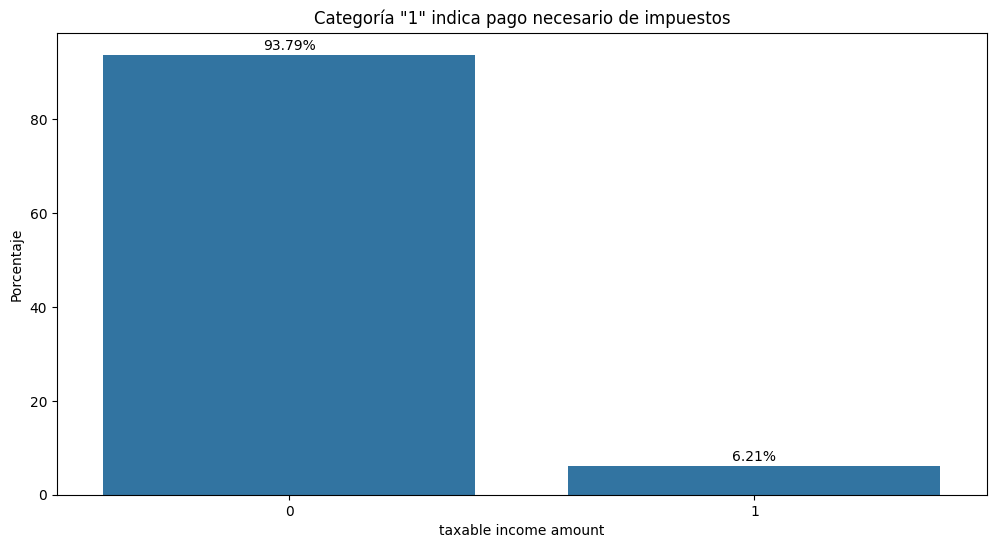

In [5]:
# Porcentajes en la variable objetivo, variable categórica nominal
porcentajes_var_cat = (datos
  .loc[:, [COLUMNA_OBJETIVO]]
  .groupby([COLUMNA_OBJETIVO]).size()
  .reset_index(name = 'cantidad')
  .sort_values(by = 'cantidad', ascending = False)
  .assign(Porcentaje = lambda d: 100 * (d['cantidad'] / num_observaciones))
)

plt.figure(figsize = (12, 6))
sns.barplot(
  x = COLUMNA_OBJETIVO, y = 'Porcentaje',
  data = porcentajes_var_cat,
  order = porcentajes_var_cat[COLUMNA_OBJETIVO]
).set_title('Categoría "1" indica pago necesario de impuestos')

for index, value in enumerate(porcentajes_var_cat["Porcentaje"]):
  plt.text(index, value + 1, f'{round(value, 2)}%', ha = 'center')

plt.show()

Note que la variable objetivo está muy desbalanceada.
Esto debido a que la categoría que se desea predecir,
"taxable income amount" = 1, representa aproximademente solo el
6% de los casos ... un porcentaje muy bajo.

Este desbalance implica que no es adecuado emplear la exactitud
(accuracy) para concluir que un modelo predictivo es mejor que otro.
Aquello debido, en parte, a que fácilmente se puede obtener una 
exactitud de aproximadamente 93.79%, por medio de un modelo que 
a cualquier observación la clasifique como que no debe pagar impuestos.

En ese sentido, requerimos alguna métrica para comparar modelos
predictivos, apropiada para casos, como este, donde las clases de la
variable objetivo están muy desbalanceadas.
Para ello emplearemos el coeficiente de Kappa de Cohen.

### Variables numéricas

In [6]:
# Número de variables numéricas
len(VARIABLES_NUMERICAS)

8

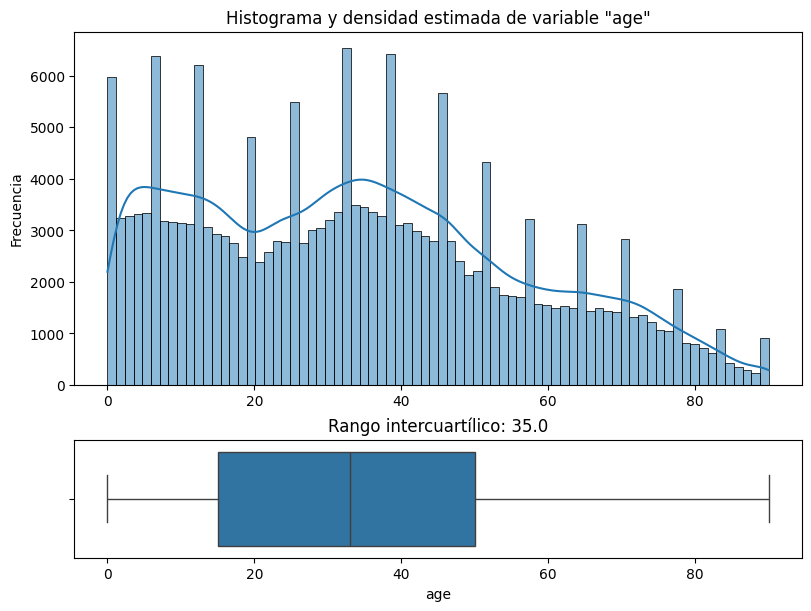

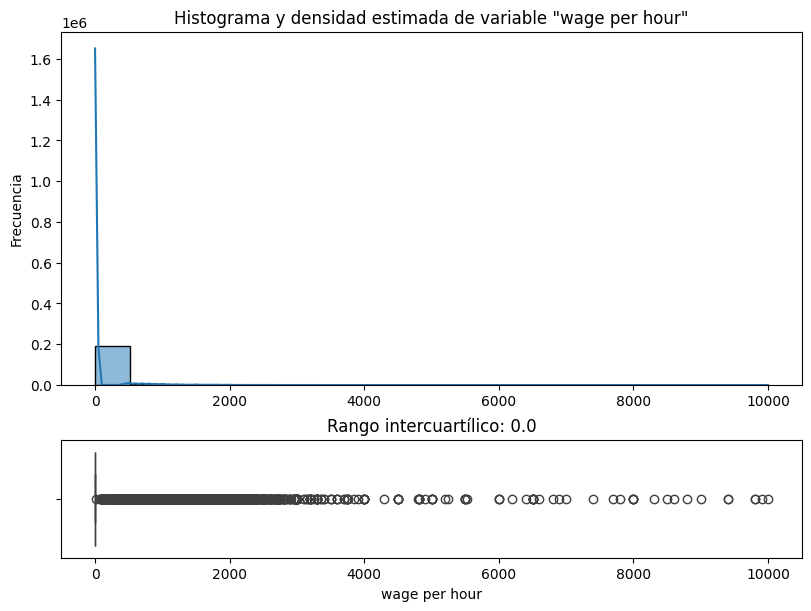

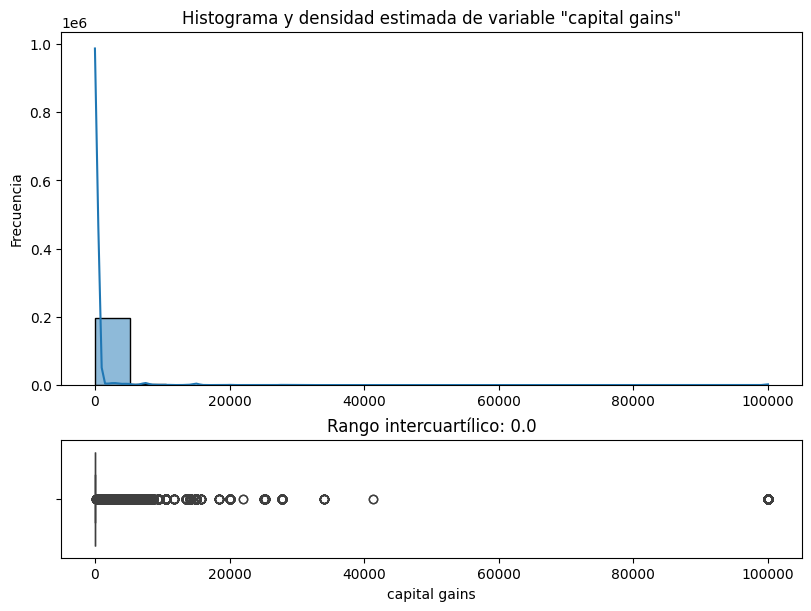

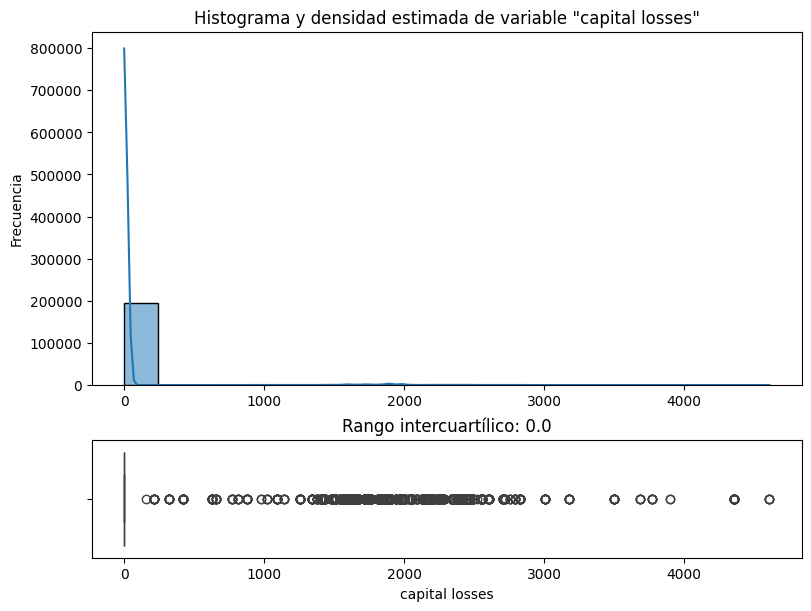

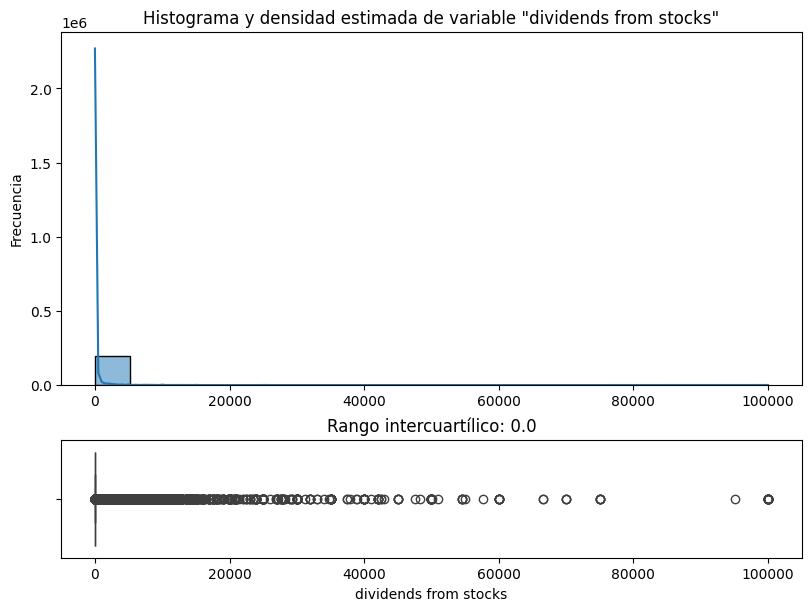

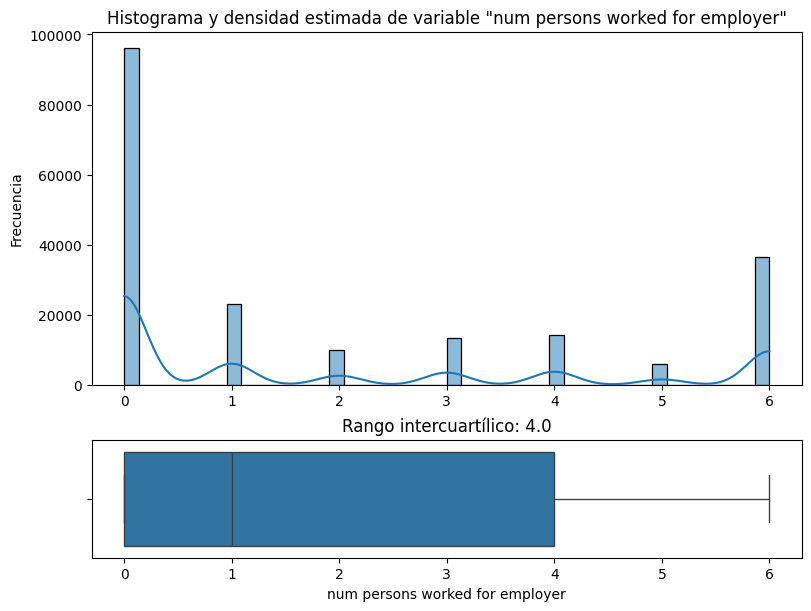

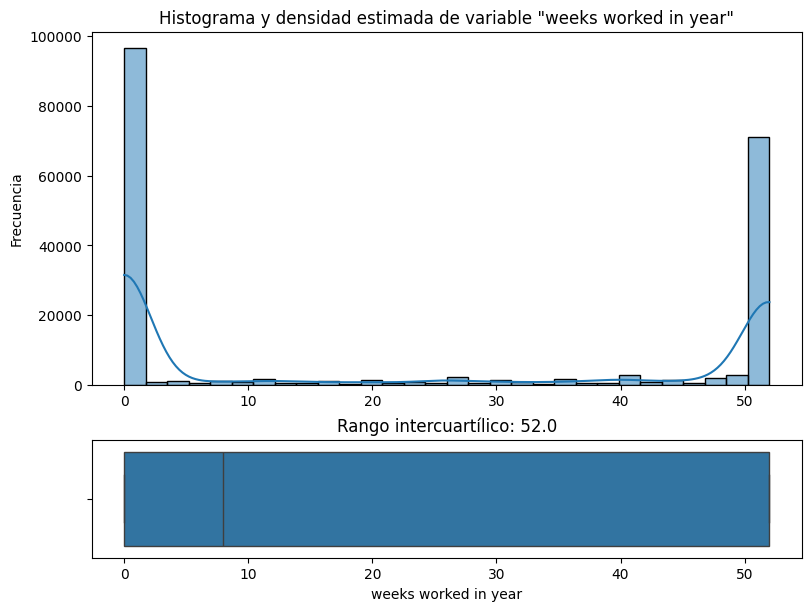

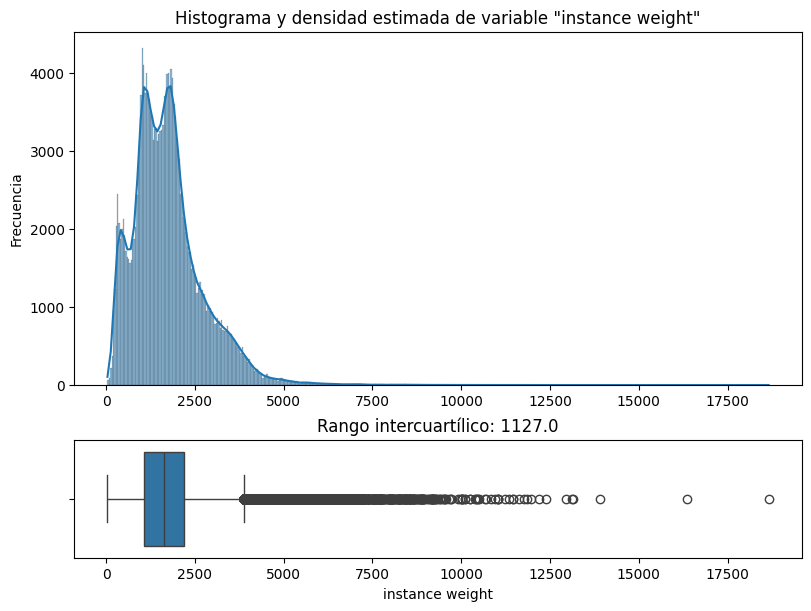

In [7]:
for var_num in VARIABLES_NUMERICAS:
  fig = plt.figure(constrained_layout = True, figsize = (8, 6))
  spec = fig.add_gridspec(2, 1, height_ratios = [3, 1])

  # Histograma
  ax1 = fig.add_subplot(spec[0])
  sns.histplot(datos[var_num], kde = True, ax = ax1)
  plt.xlabel('')
  plt.ylabel('Frecuencia')
  ax1.set_title(f'Histograma y densidad estimada de variable "{var_num}"')

  # Diagrama de caja
  ax2 = fig.add_subplot(spec[1])
  sns.boxplot(x = datos[var_num], ax = ax2, orient = "h")

  iqr = (datos[[var_num]]
    .describe().T
    .assign(IQR = lambda d: d['75%'] - d['25%'])
    ['IQR'][0]
  )
  ax2.set_title(f"Rango intercuartílico: {round(iqr, 2)}")
  plt.show()

De los gráficos notamos que ninguna variable numérica presenta
una distribución aproximadamente normal/gaussiana.

Asimismo, las variables "wage per hour", "capital gains",
"capital losses" y "dividens from stocks", no solo presentan
una gran cantidad de valores atípicos, sino que su rango
intercuatílico es cero. Esto significa que, para cada una de
aquellas variables en particular, el 50% de sus observaciones
consisten del mismo valor.

También se tiene una gran cantidad de datos atípicos para la
variable "instance weight", pero, la forma de su distribución 
y su cola significativa sugiere que podría resultar apropiada 
una transformación del tipo log(1 + "instance weight"), con el fin
de normalizar aquella variable. Esto en caso fuese a emplearse
tal variable para el entrenamiento de los modelos, mas, en el 
archivo `census_income/census-income_doc.txt` se sugiere que no
se utilice aquella variable para los modelos de clasificación.

Por otro lado, se observa una mayor dispersión de los datos
para las variables "age", "num persons worked for employer" y
"weeks worked in year". Además, estas últimas variables no cuentan
con valores atípicos, según el cálculo estándar vía el IQR, pues sus
diagramas de caja no presentan puntos fuera del rango cubierto por los whiskers.

In [8]:
# Comparamos la homogeneidad de los variables numéricas
(datos[VARIABLES_NUMERICAS]
  .describe().T
  # Calcular el coeficiente de variación (C.V) de cada variable numérica
  .assign(coef_variacion = lambda d: d['std'] / d['mean'])
  # Ordenar las variables numéricas de menor a mayor C.V,
  # es decir, de mayor homogeneidad a menor .
  .sort_values('coef_variacion', ascending = True)
  .loc[:, [
    'coef_variacion', 'mean', 'std',
    'min', '25%', '50%', '75%', 'max'
  ]]
)

coef_variacion         mean          std   
instance weight                        0.571006  1740.380269   993.768156  \
age                                    0.646801    34.494199    22.310895   
weeks worked in year                   1.053359    23.174897    24.411488   
num persons worked for employer        1.209053     1.956180     2.365126   
wage per hour                          4.959621    55.426908   274.896454   
capital losses                         7.286755    37.313788   271.896428   
dividends from stocks                 10.044896   197.529533  1984.163658   
capital gains                         10.805903   434.718990  4697.531280   

                                   min       25%      50%      75%      max  
instance weight                  37.87  1061.615  1618.31  2188.61  18656.3  
age                               0.00    15.000    33.00    50.00     90.0  
weeks worked in year              0.00     0.000     8.00    52.00     52.0  
num persons worked for employer   0.00     0.000     1.00     4.00      6.0  
wage per hour                     0.00     0.000     0.00     0.00   9999.0  
capital losses                    0.00     0.000     0.00     0.00   4608.0  
dividends from stocks             0.00     0.000     0.00     0.00  99999.0  
capital gains                     0.00     0.000     0.00     0.00  99999.0

En la tabla resultante, ninguna varable numérica posee C.V menor o igual que 0.3 (30%).
Esto significa que, para cada variable numérica, su promedio no representa a la variable
adecuadamente, por lo que consisten de variables heterogéneas (no homogéneas).

Esta información sería de mayor utilidad en caso se hubiese requerido imputar valores perdidos
en las variables numéricas, pues, hemos confirmado que una imputación vía la media aritmética
muy probablemente no hubiese sido adecuada. Así, otro tipo de imputación se hubiese requerido.

## Análisis entre variables

### Comparación entre predictores categóricos y variable objetivo

Escenario A:

Cuando comparamos la frecuencia de un predictor categórico, en base
a las clases de la variables objetivo binaria, es de nuestro interés
cuándo las **distribuciones condicionales son significativamente diferentes**.
Esto debido a que, de existir aquella diferencia significativa, se
tendría indicios de cómo diferenciar a las personas que deben pagar
impuestos, con los que no deben pagarlos; aquella comparación en
base al predictor categórico en cuestión.

Escenario B.1:

Por otro lado, al comparar las frecuencias de la variable objetivo,
en cada clase de algún predictor categórico, se espera que los 
predictores que influencien de manera significativa la predicción
sobre el pago de impuestos, presenten para alguna de sus clases una
distribución condicional de 1 (debe pagar impuesto) y 0 # (no debe pagar impuesto) 
significativamente diferente a la distribución
marginal de la variable objetivo. 

Escenario B.2:

Idealmente, se espera exista algún predictor categórico para el cual
una de sus ditribuciones condicionales tenga como porcentaje, de casos
que deben pagar impuesto, un valor muy elevado comparado con 6%,
el porcentaje poblacional (aproximado) de las personas que deben pagar impuestos.

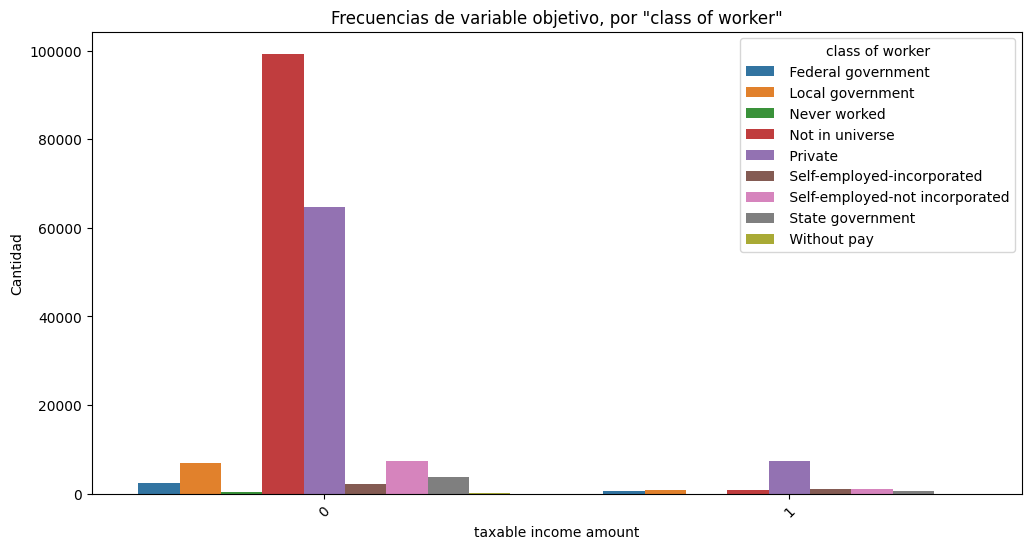

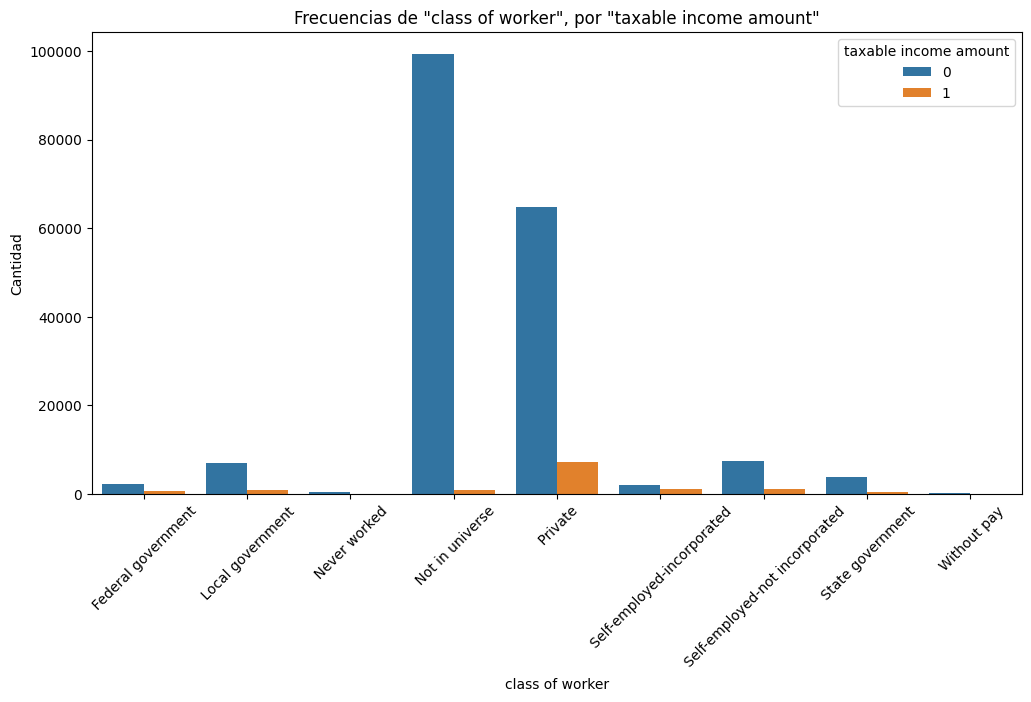

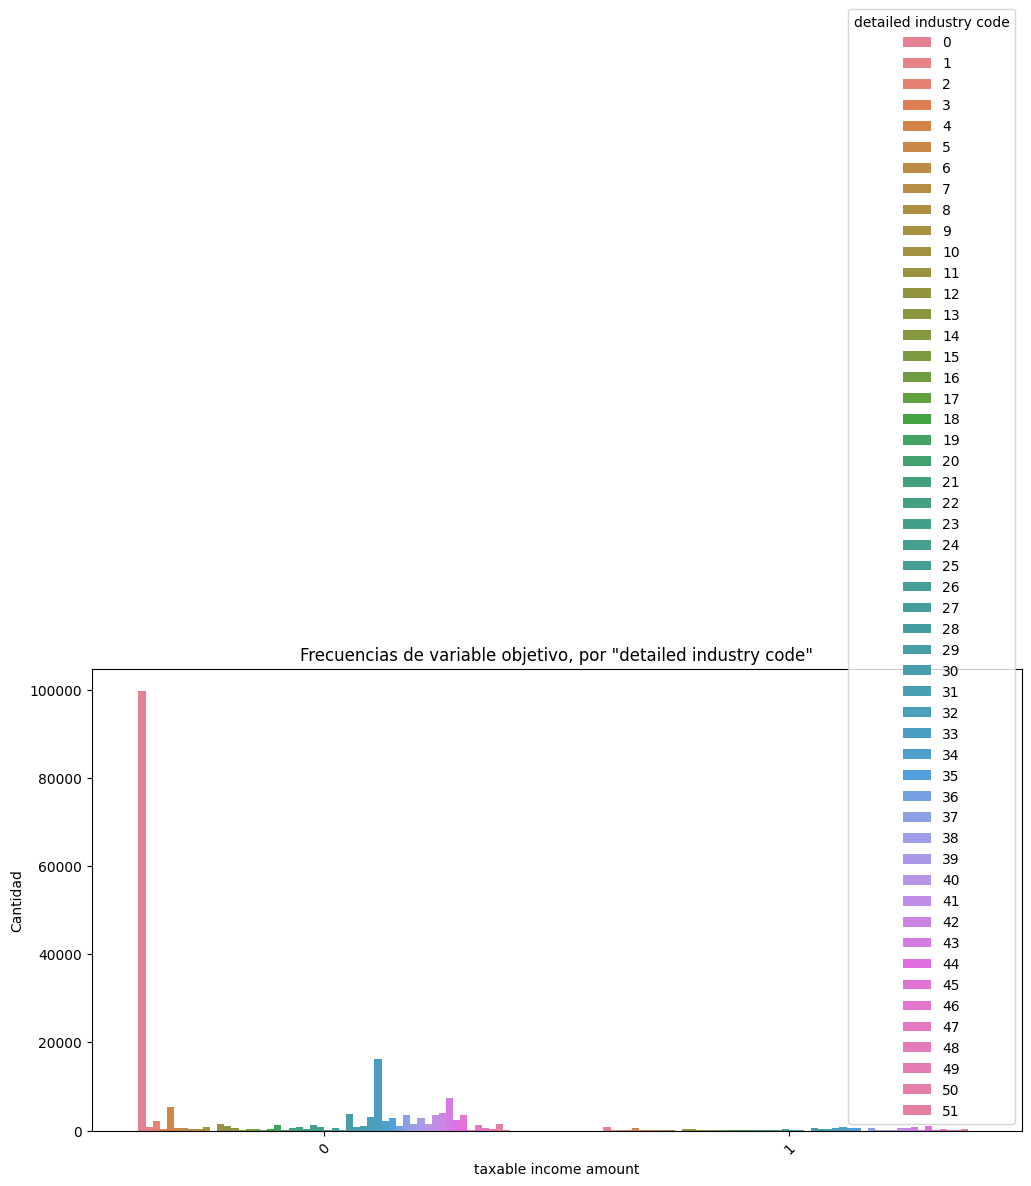

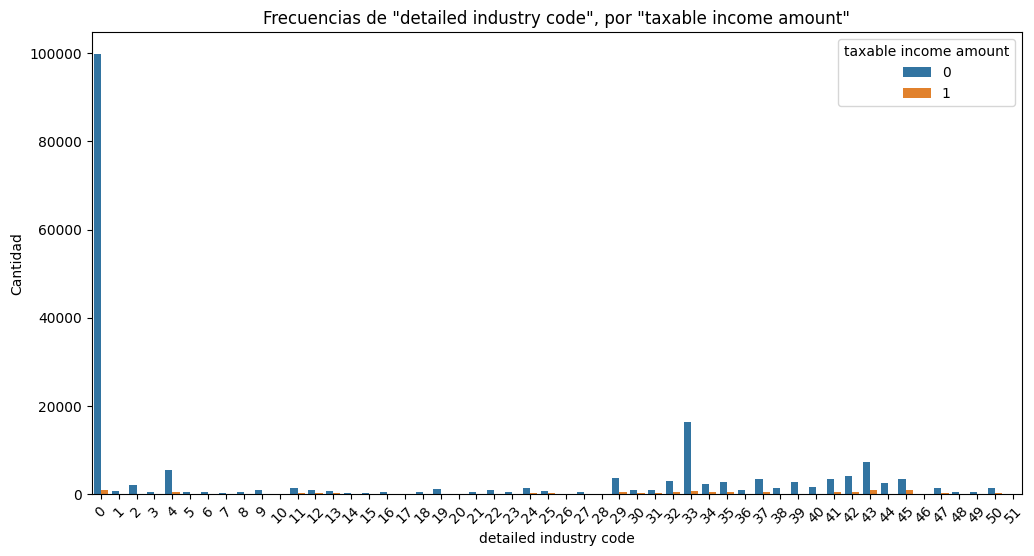

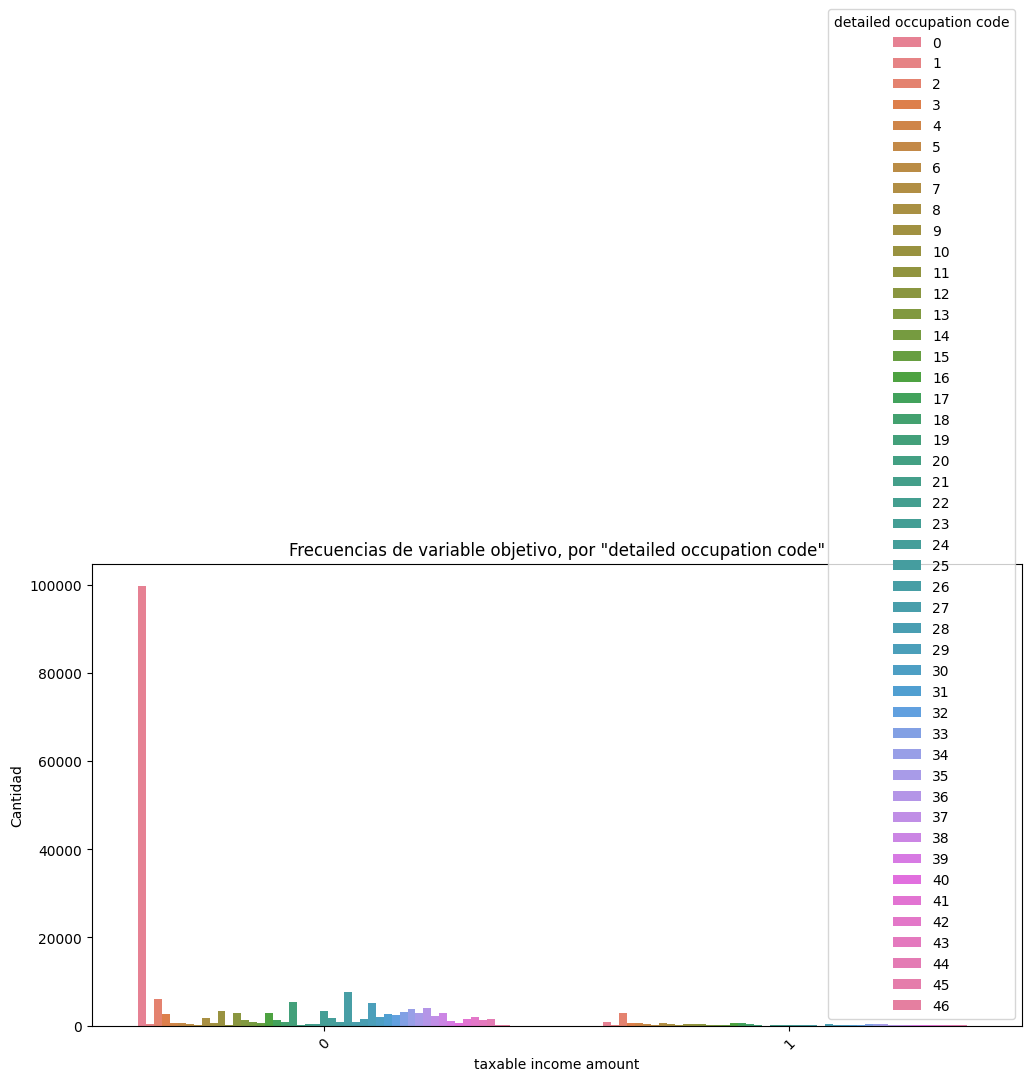

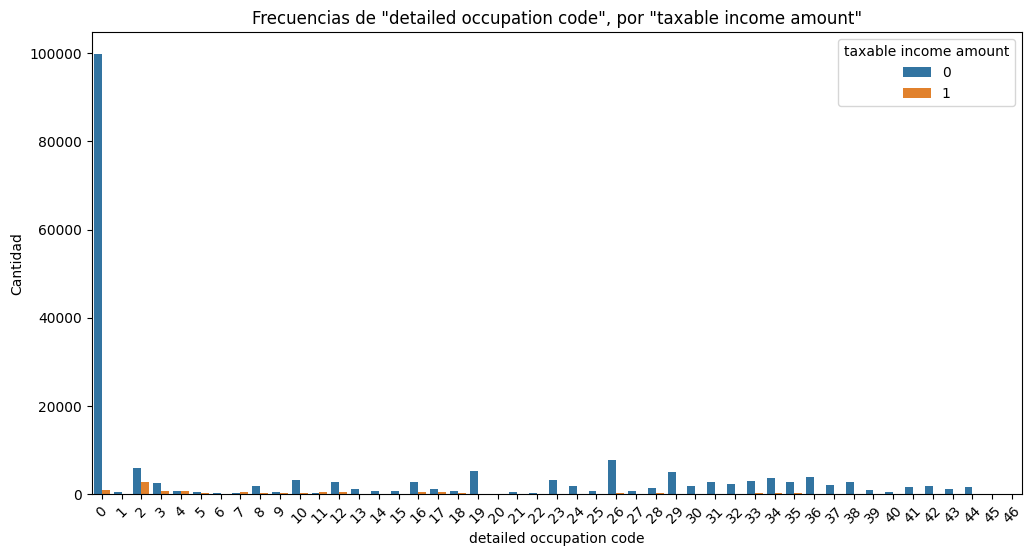

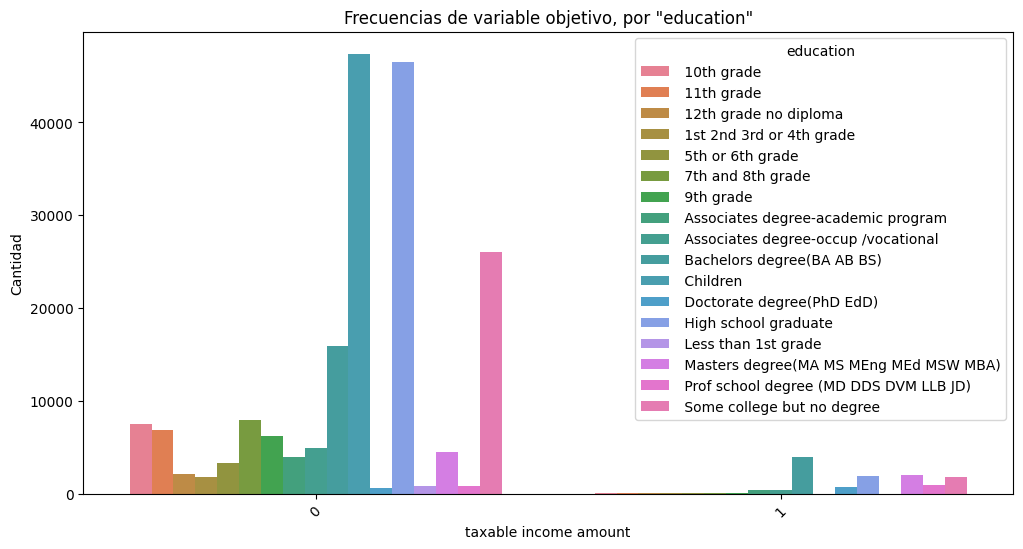

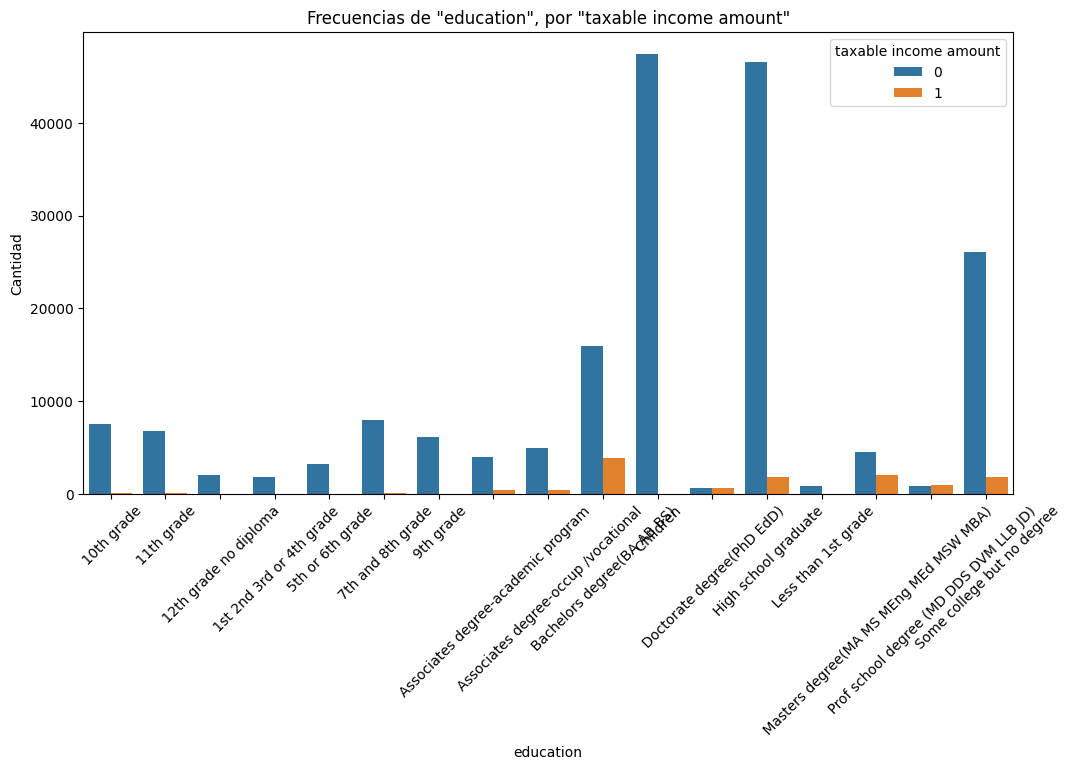

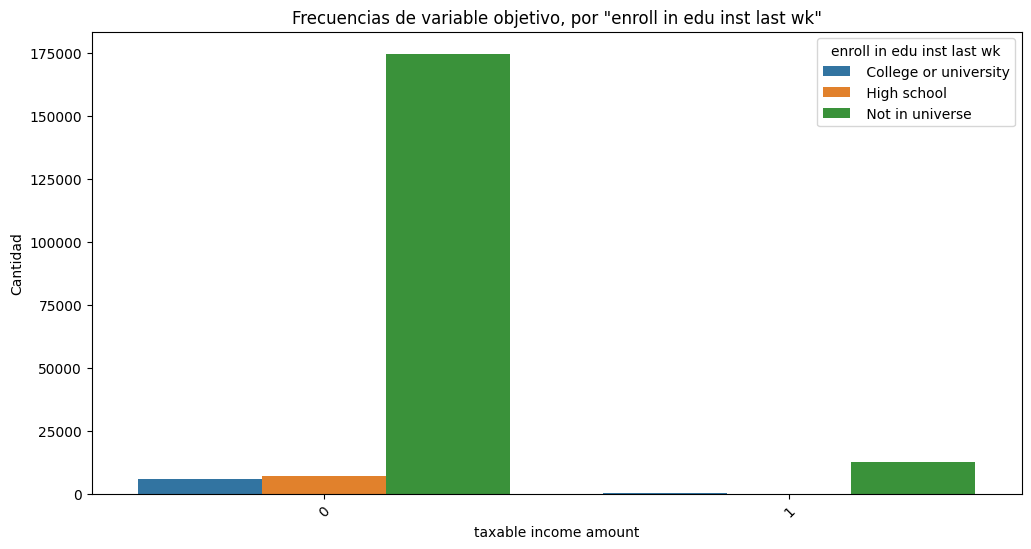

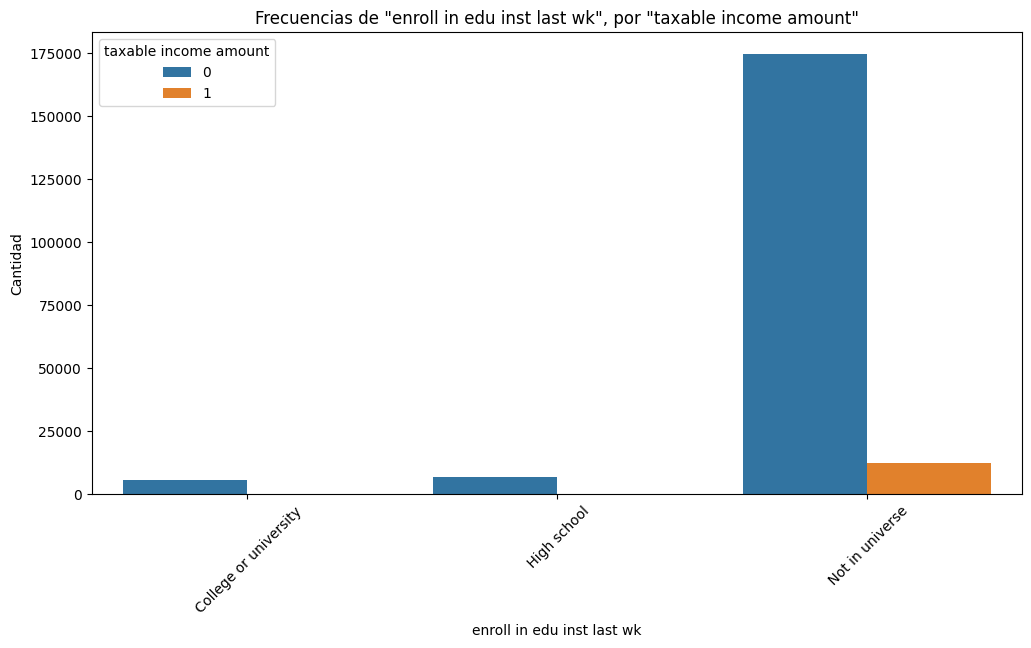

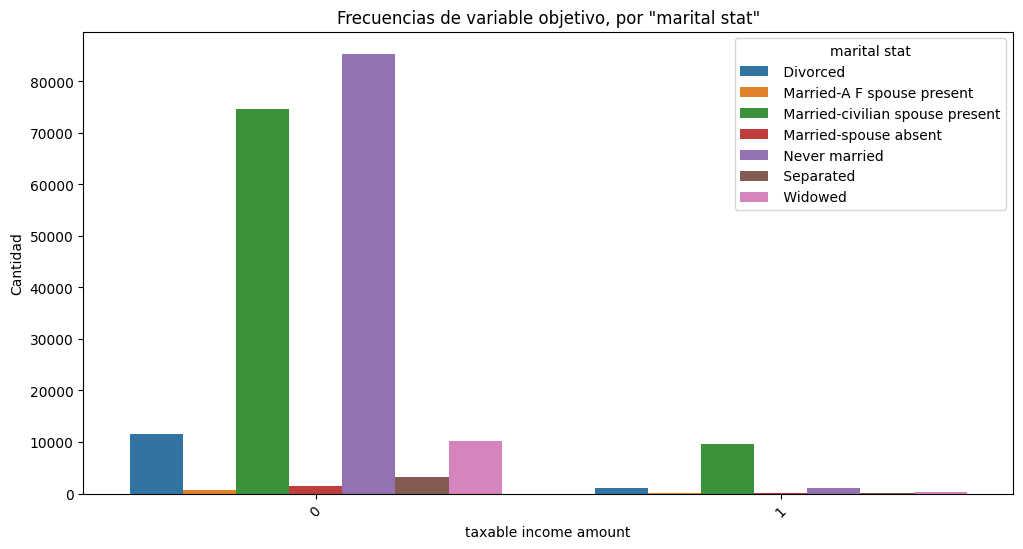

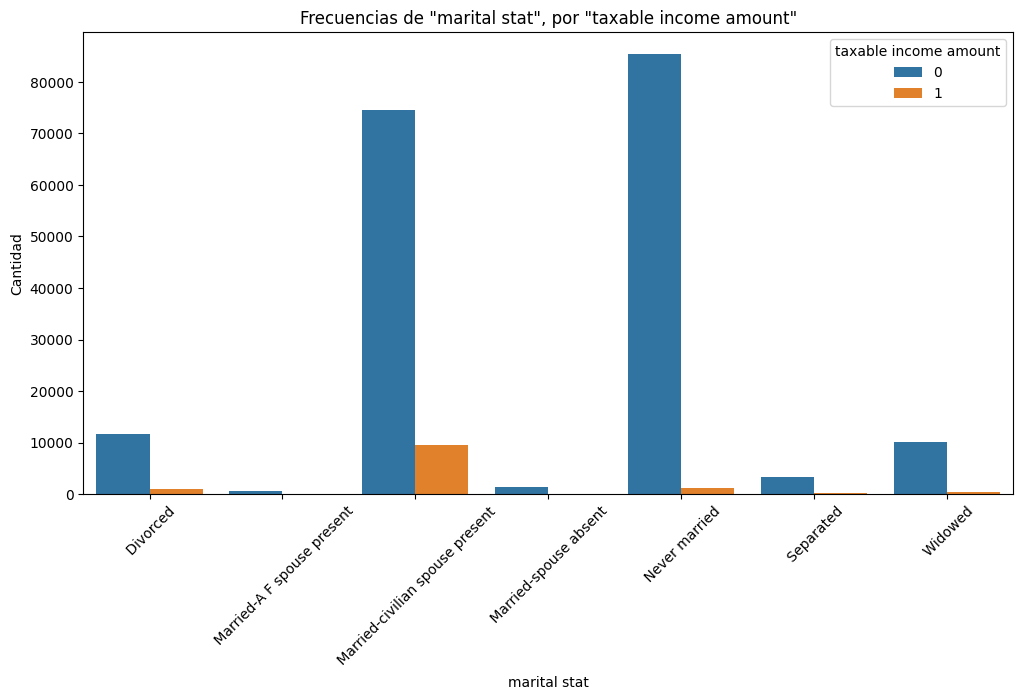

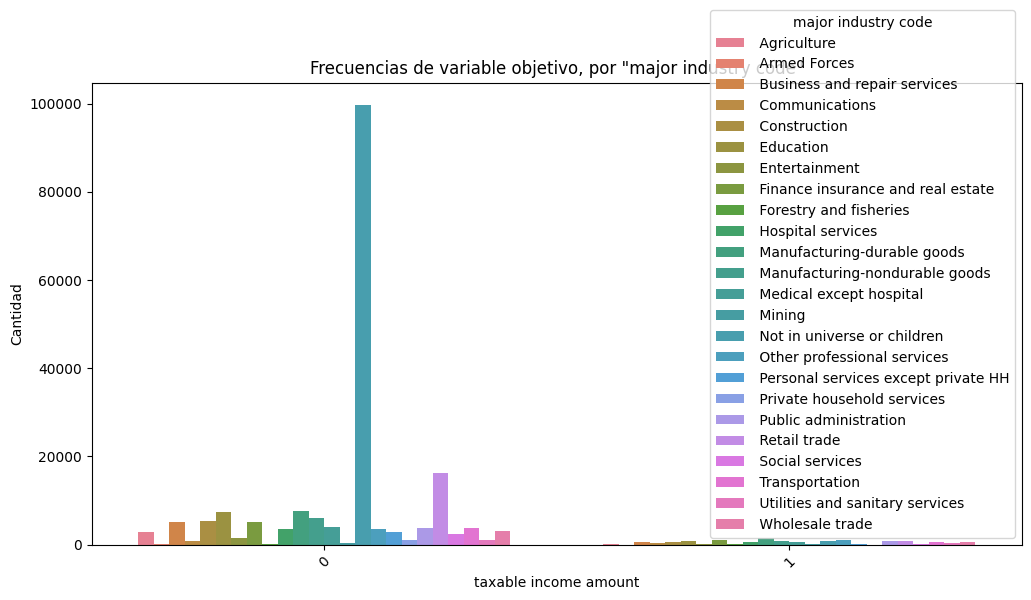

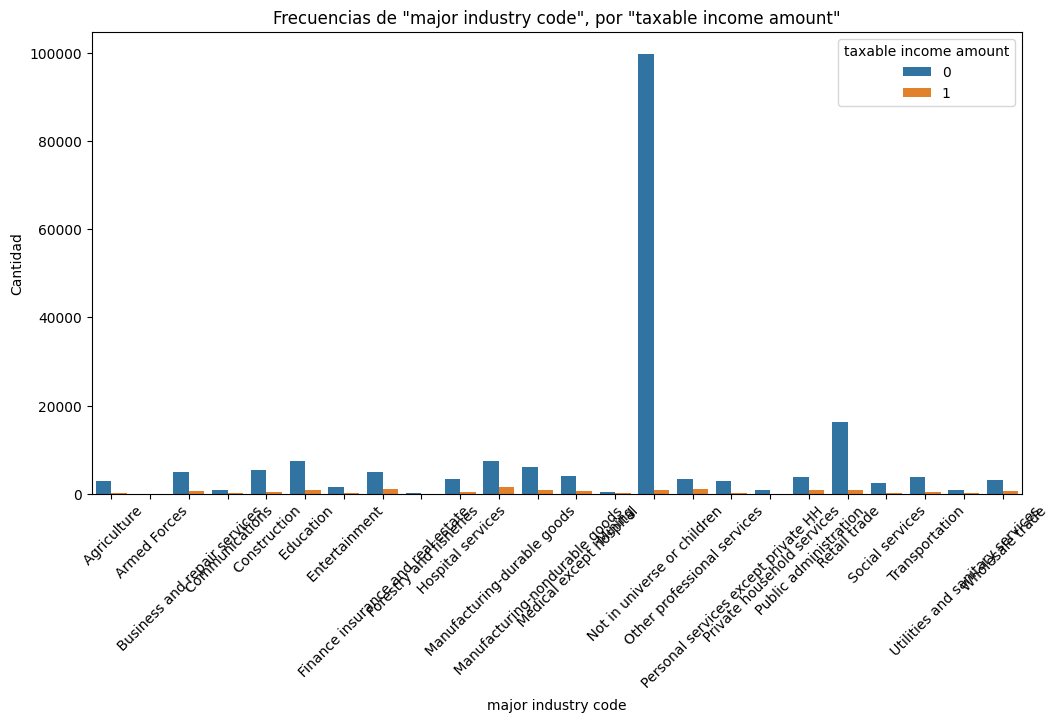

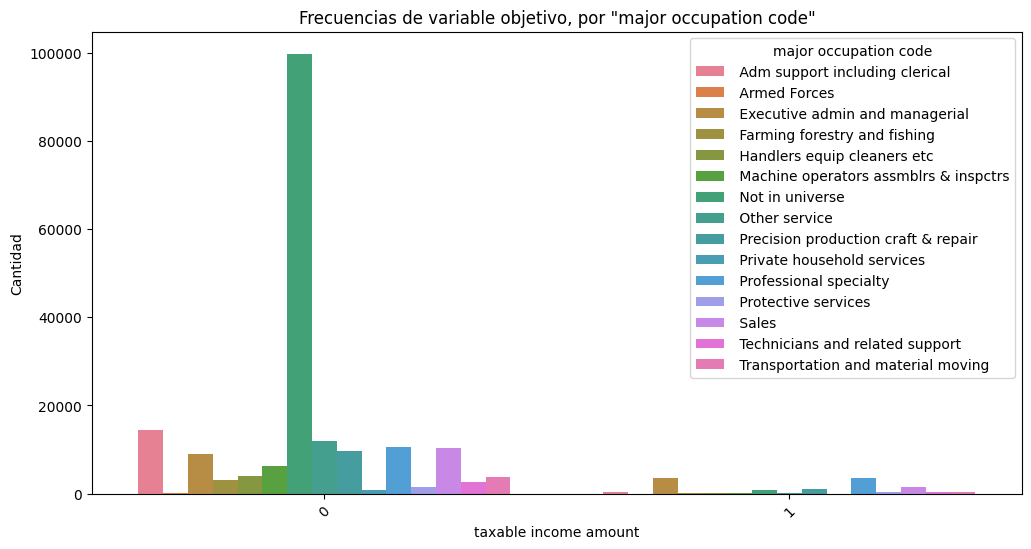

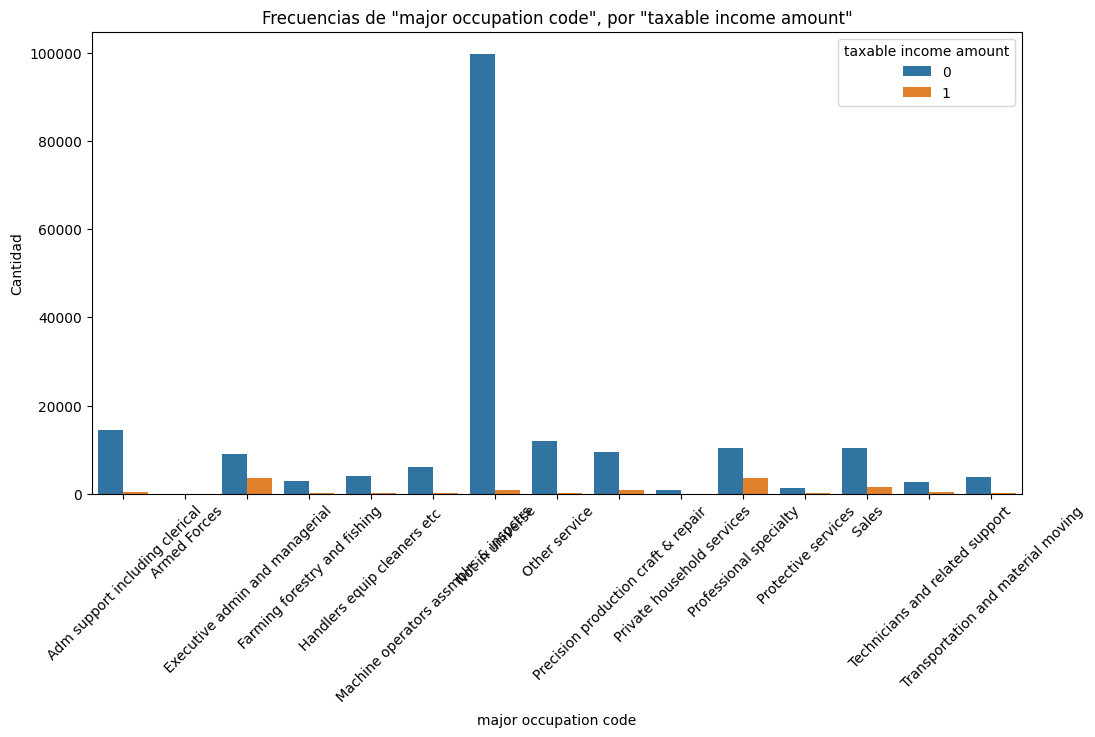

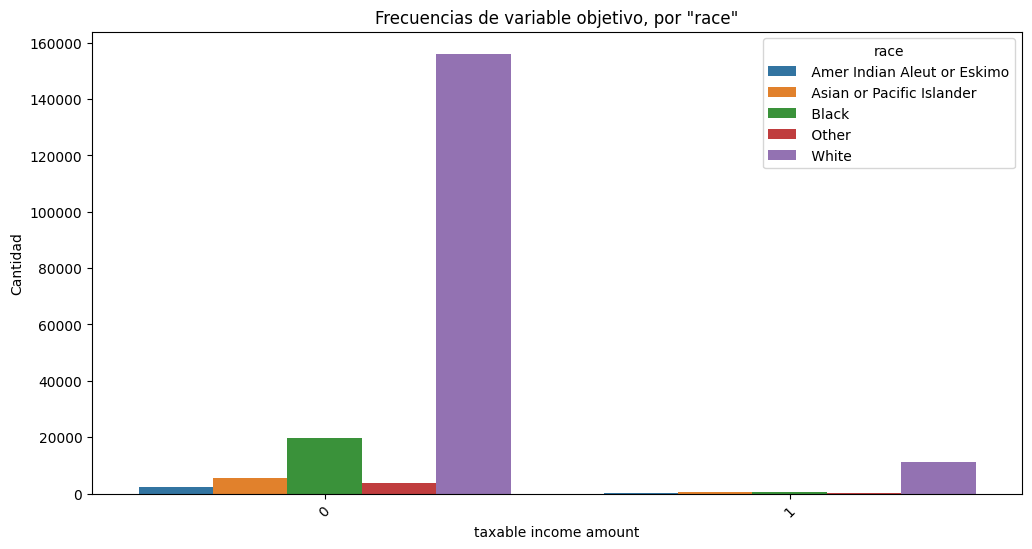

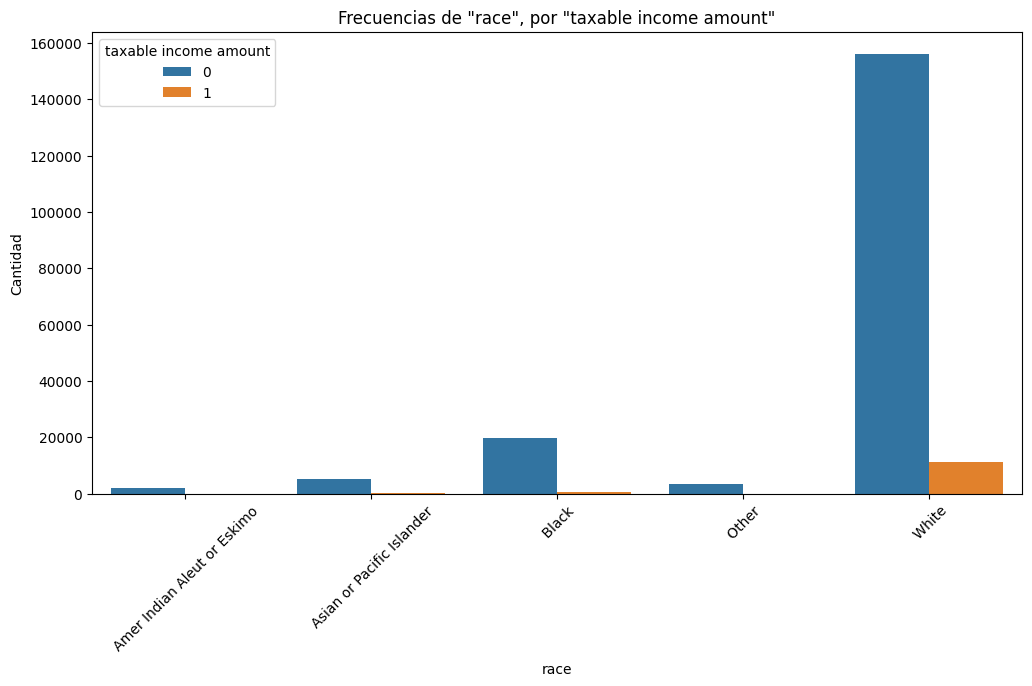

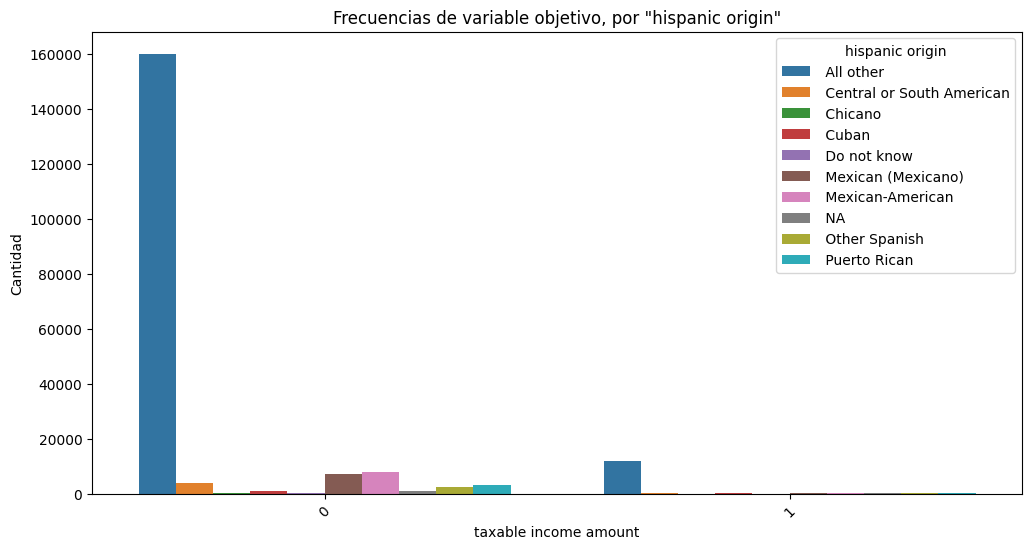

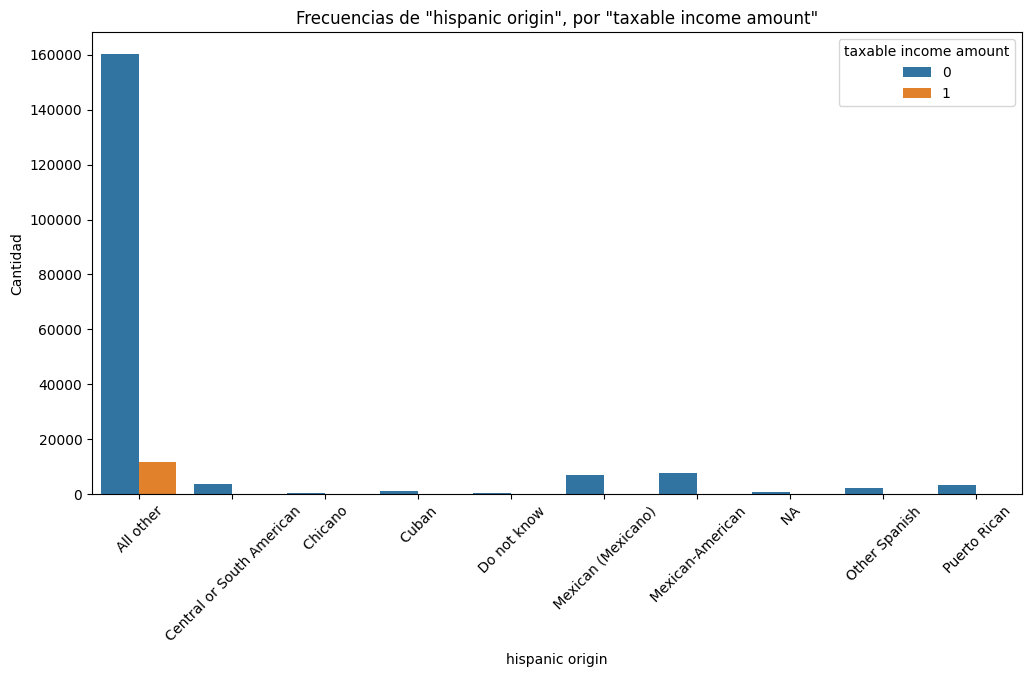

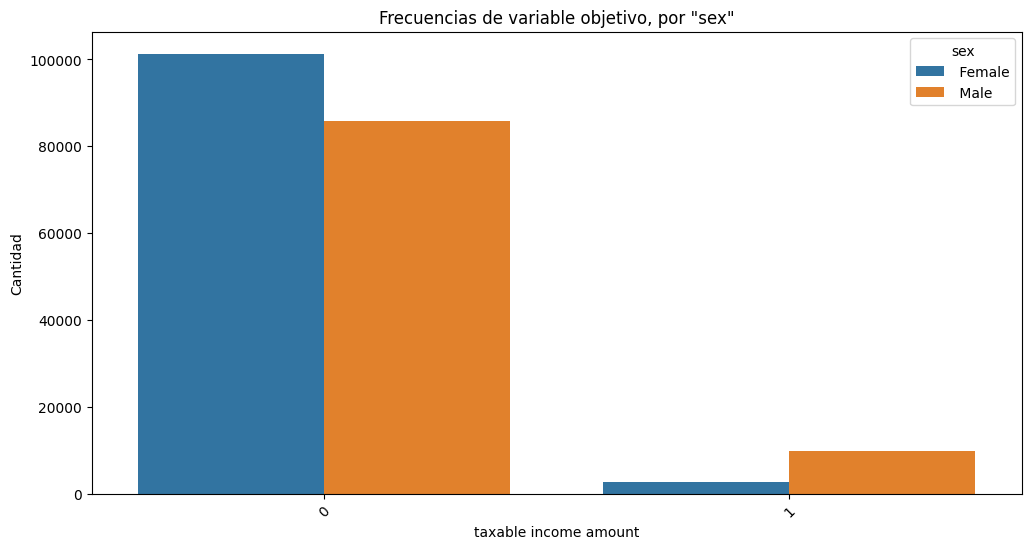

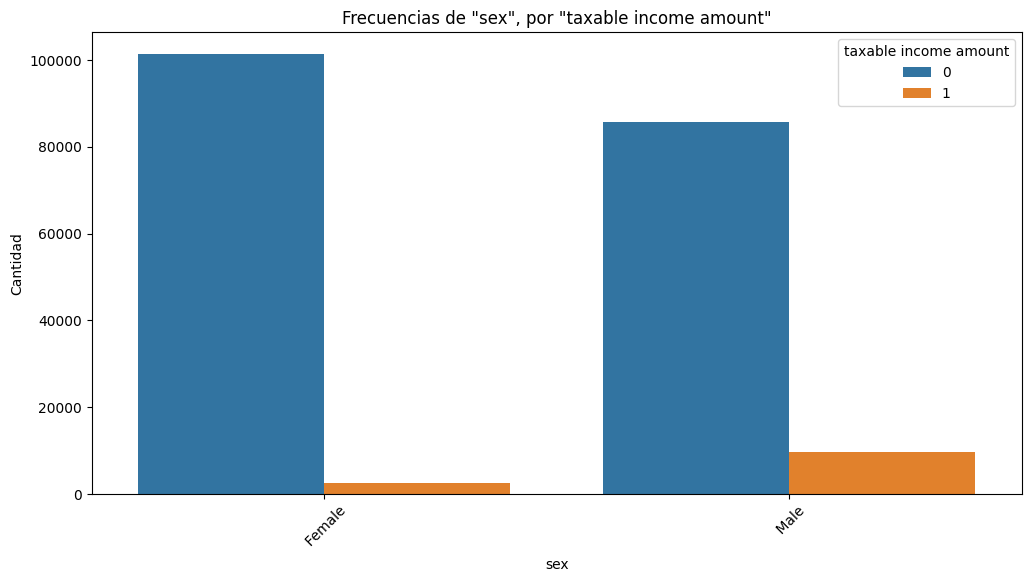

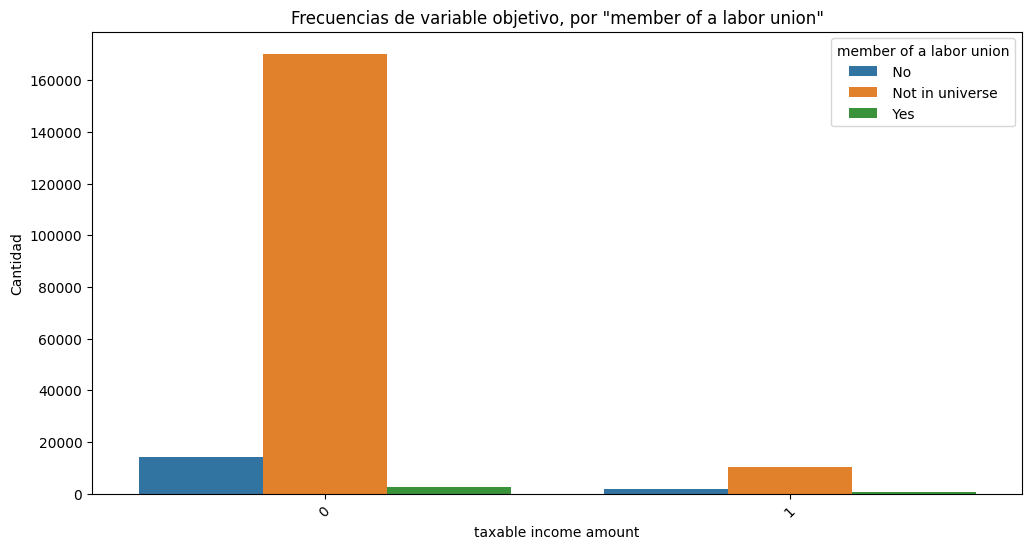

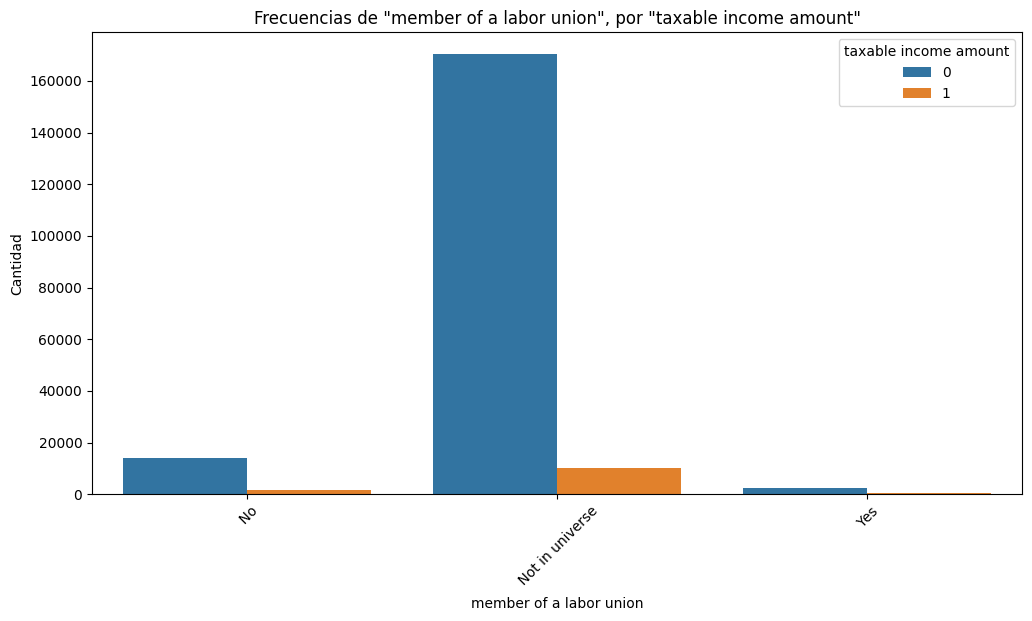

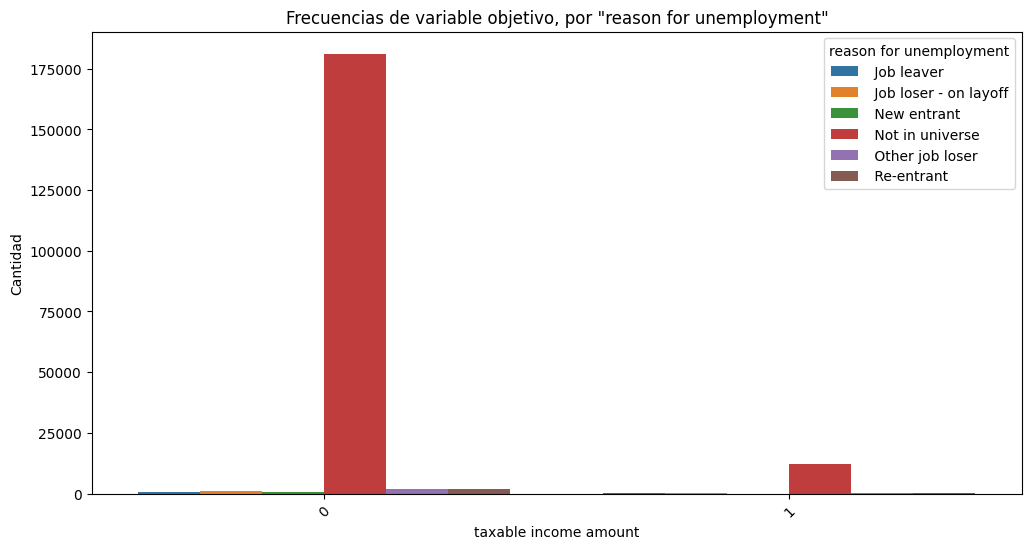

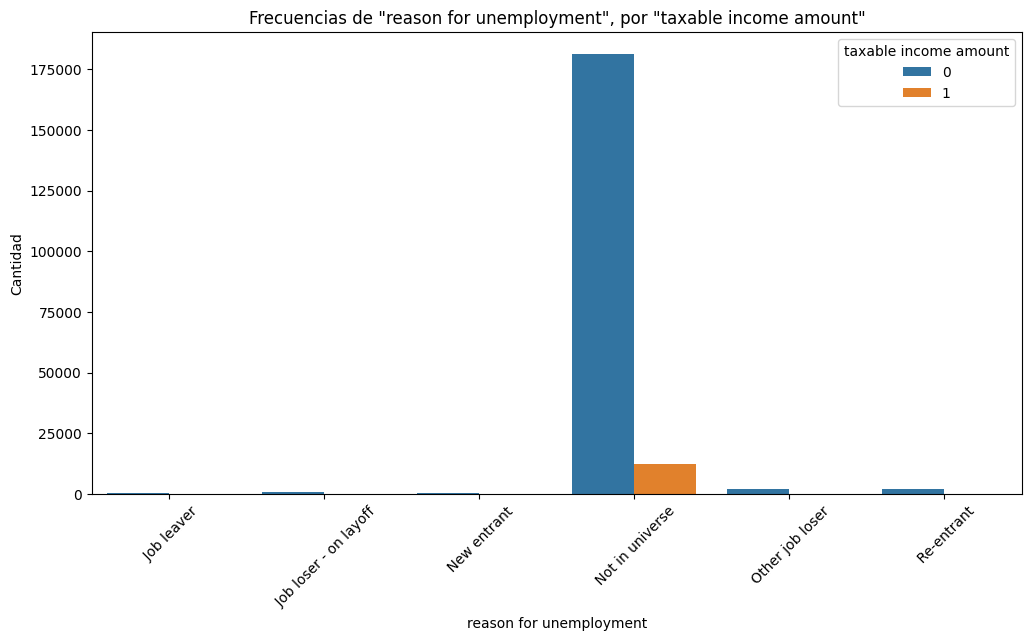

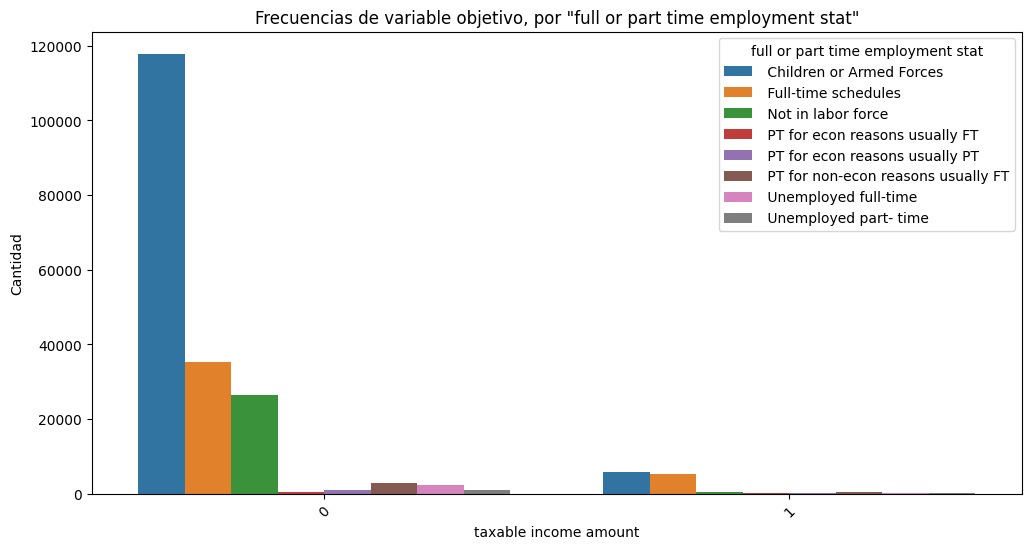

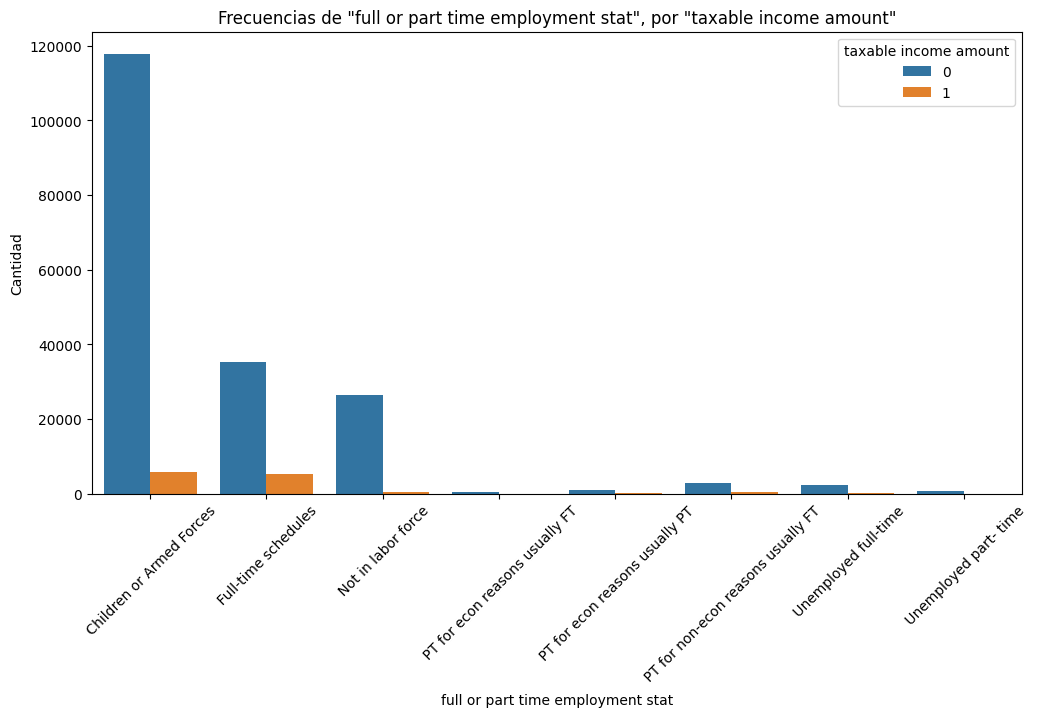

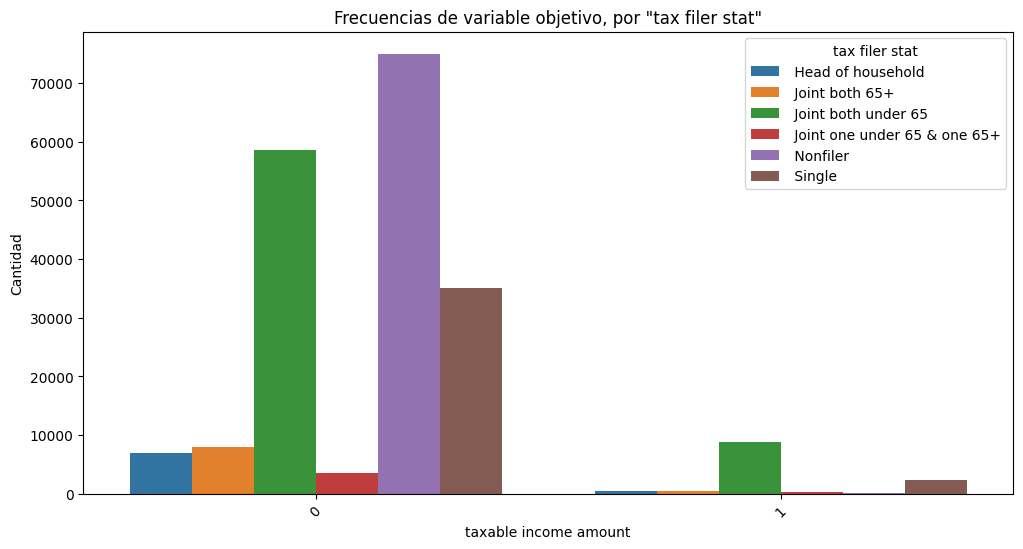

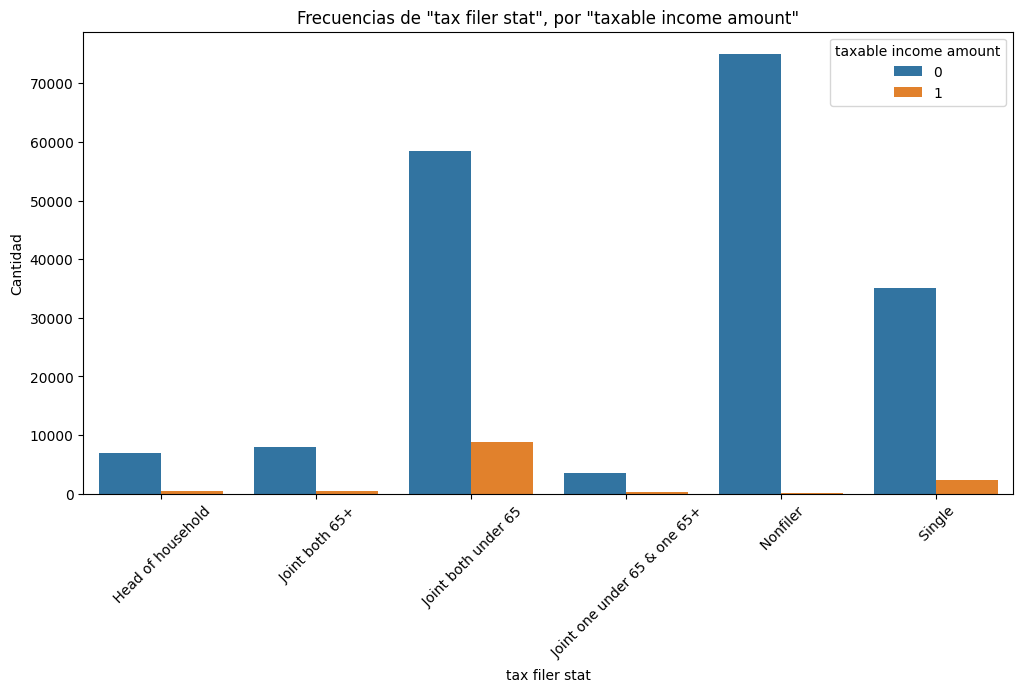

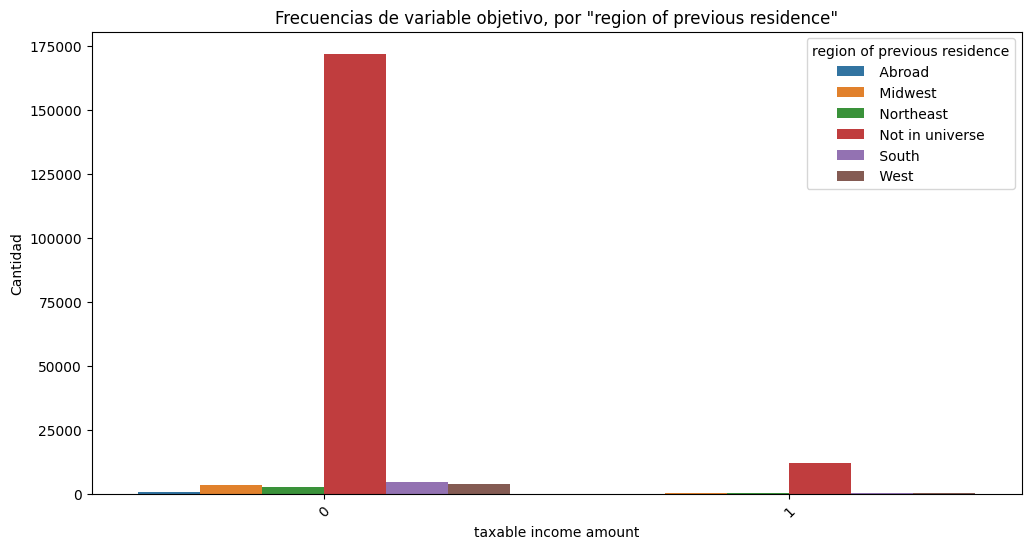

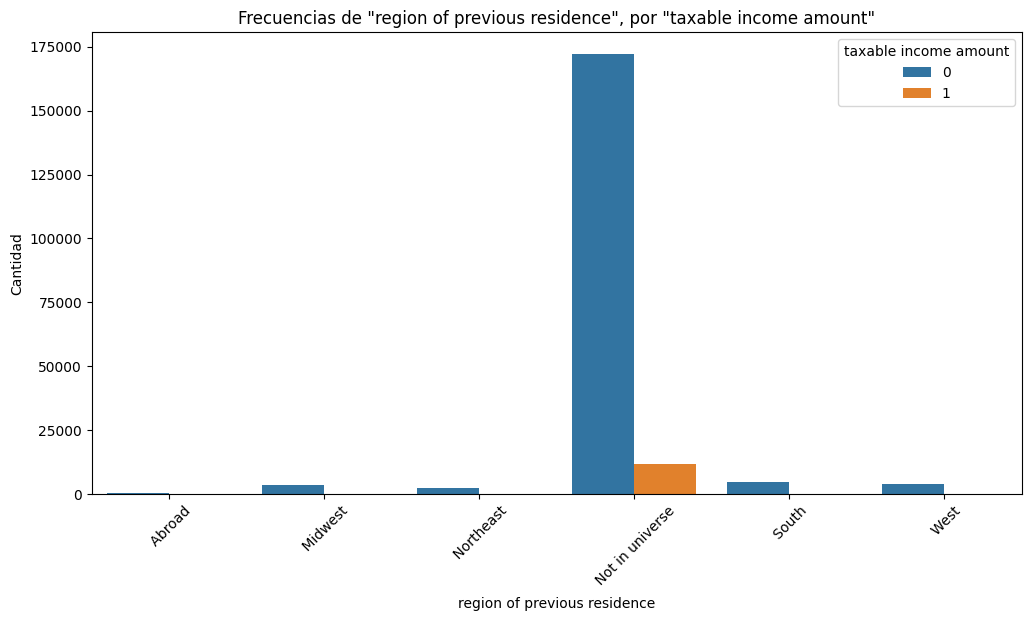

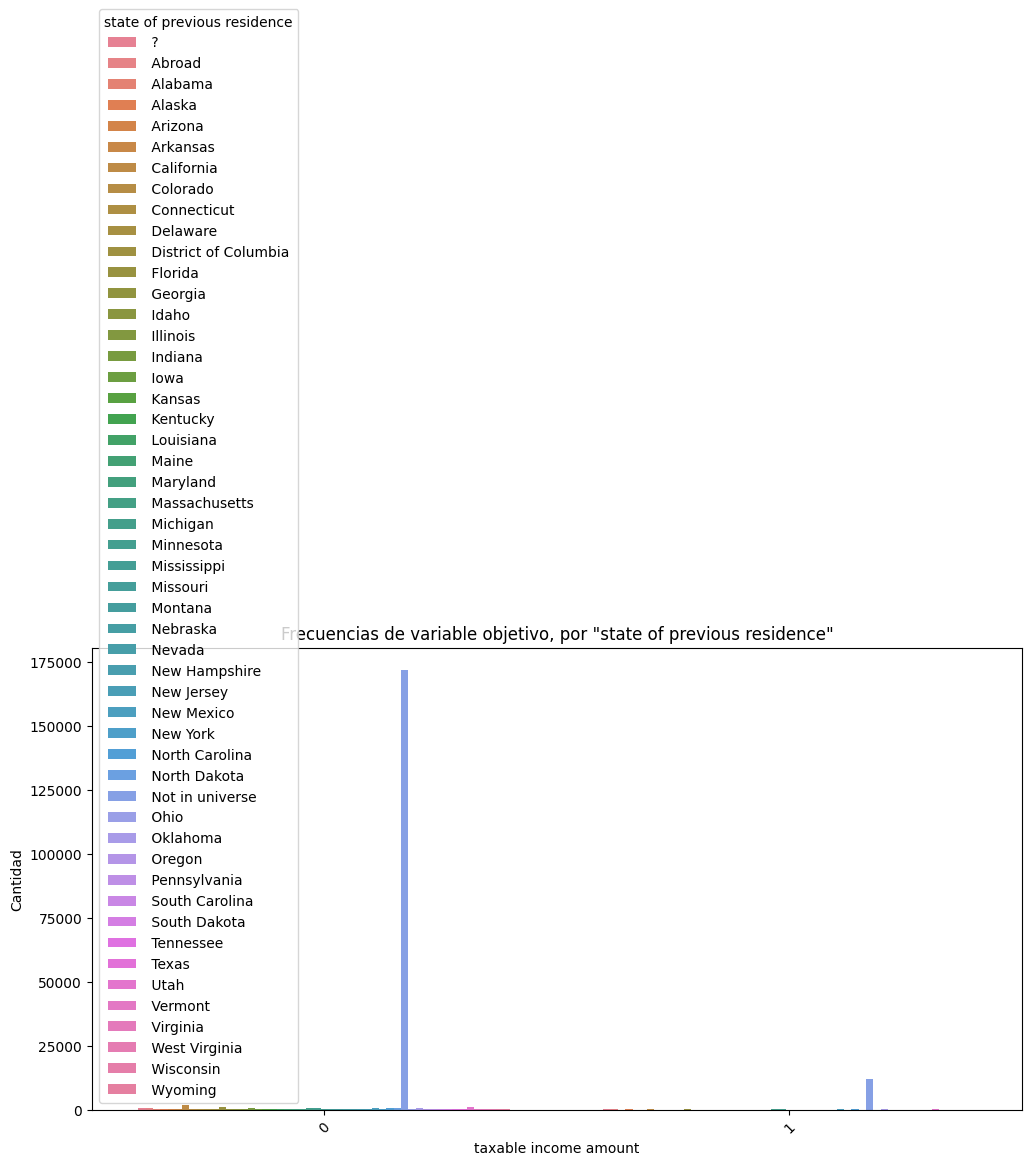

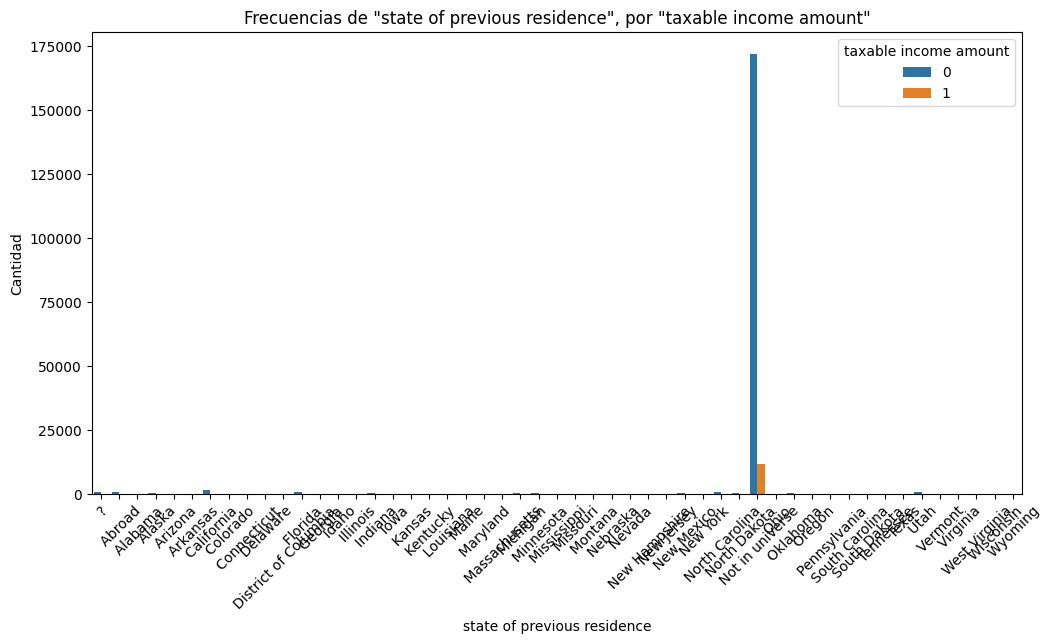

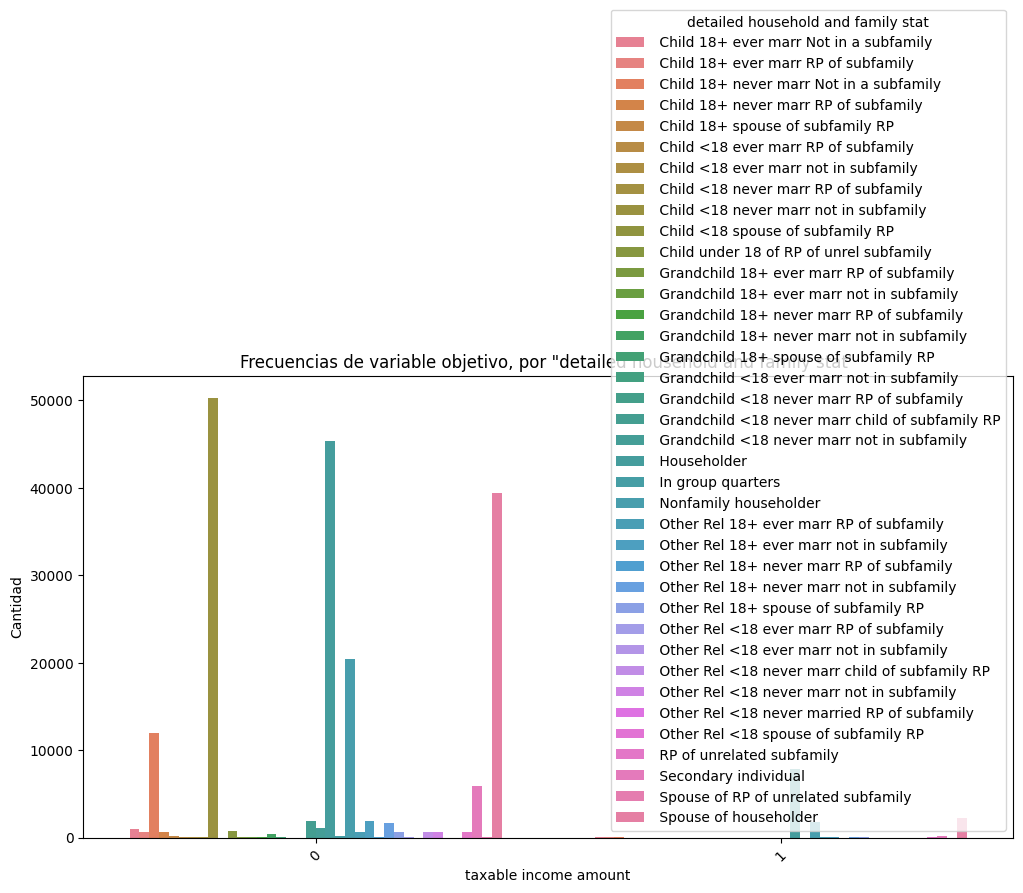

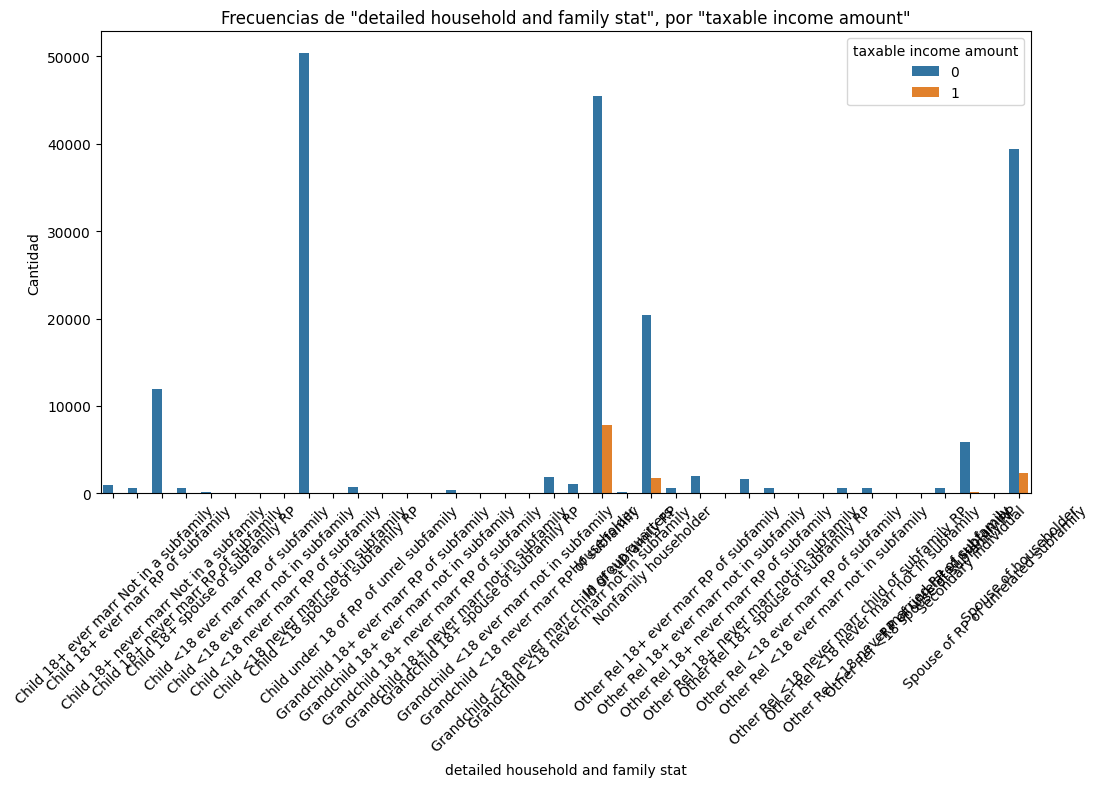

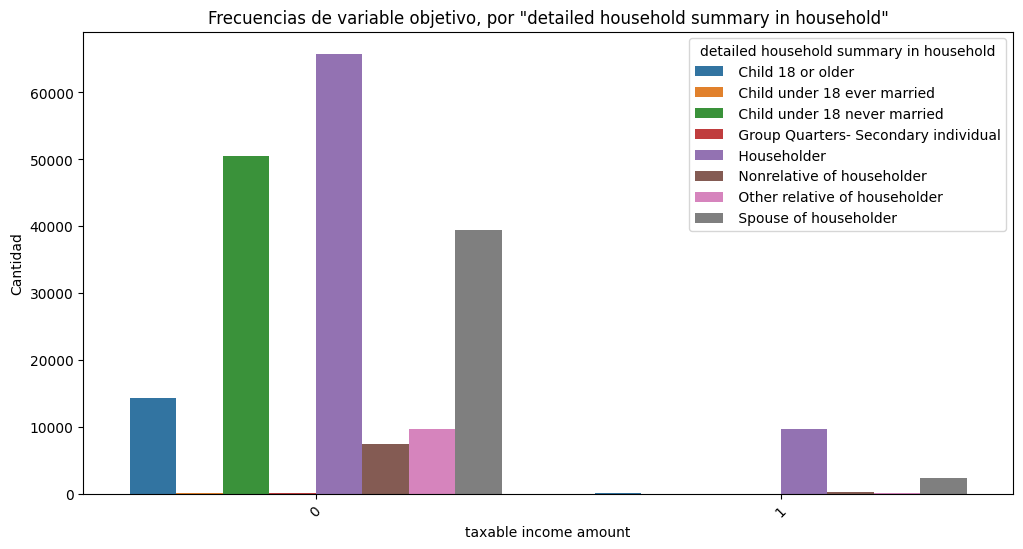

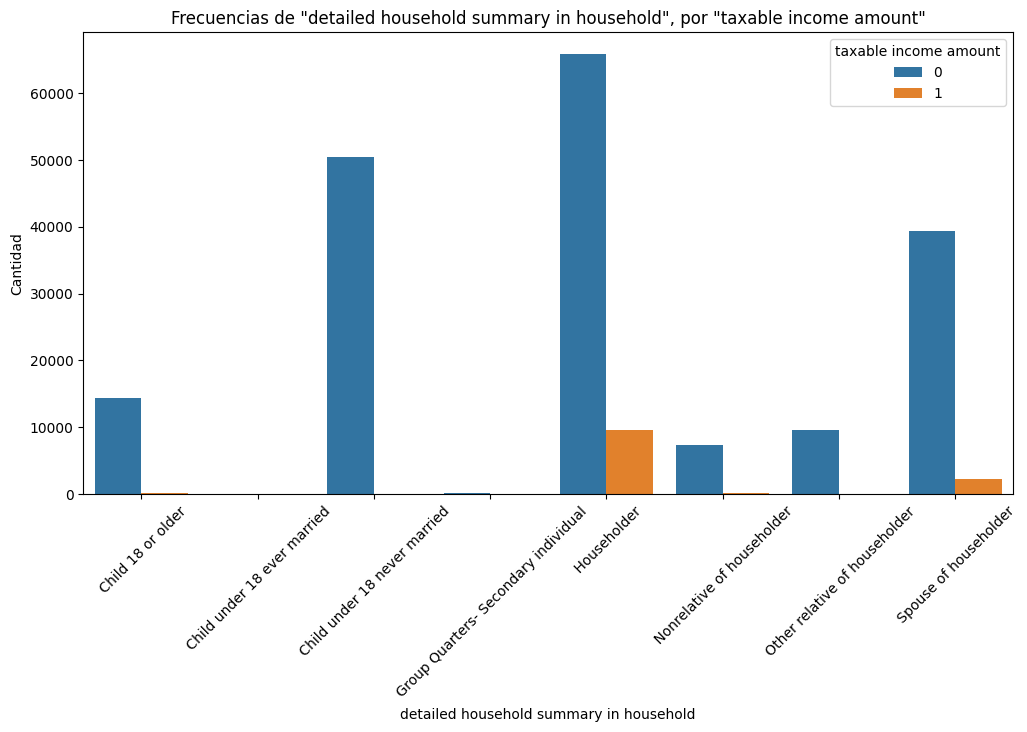

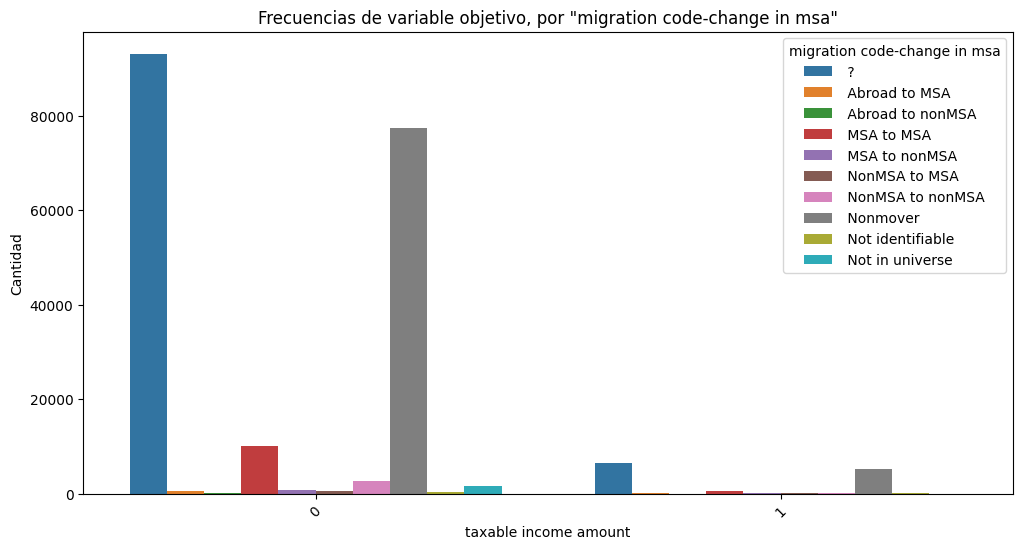

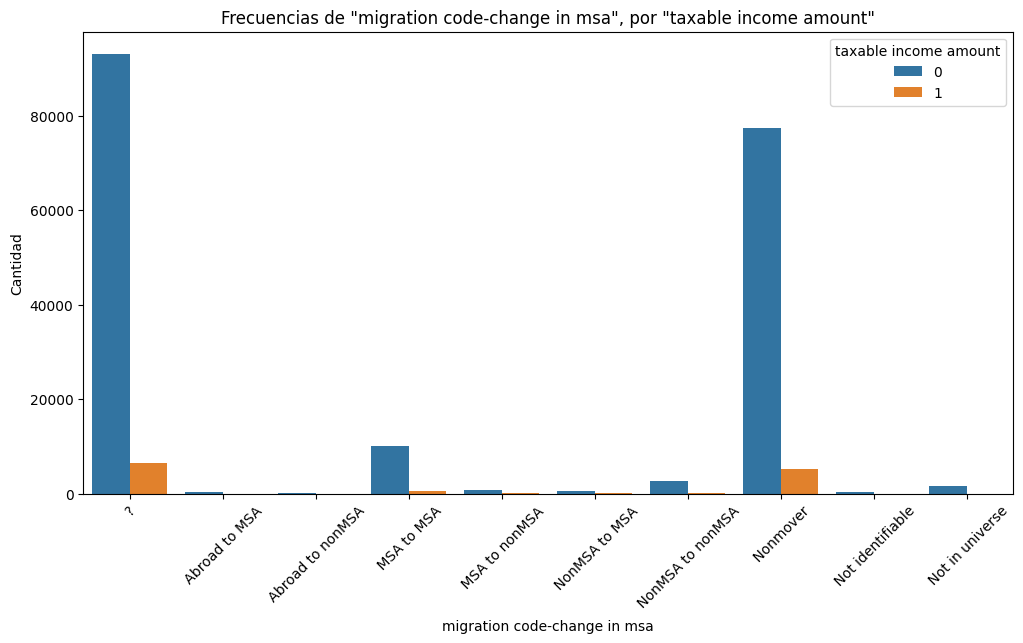

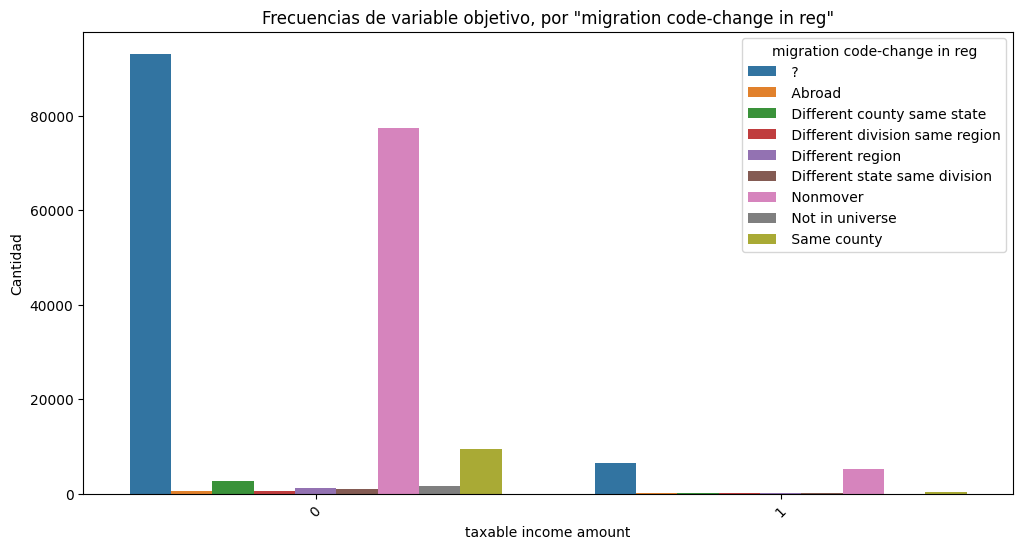

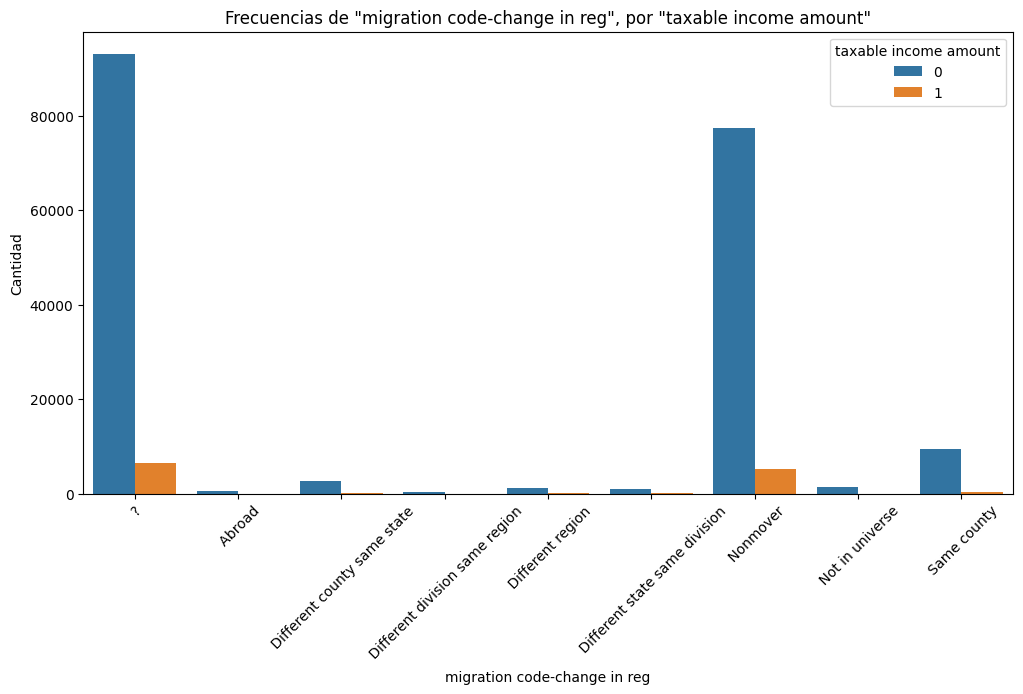

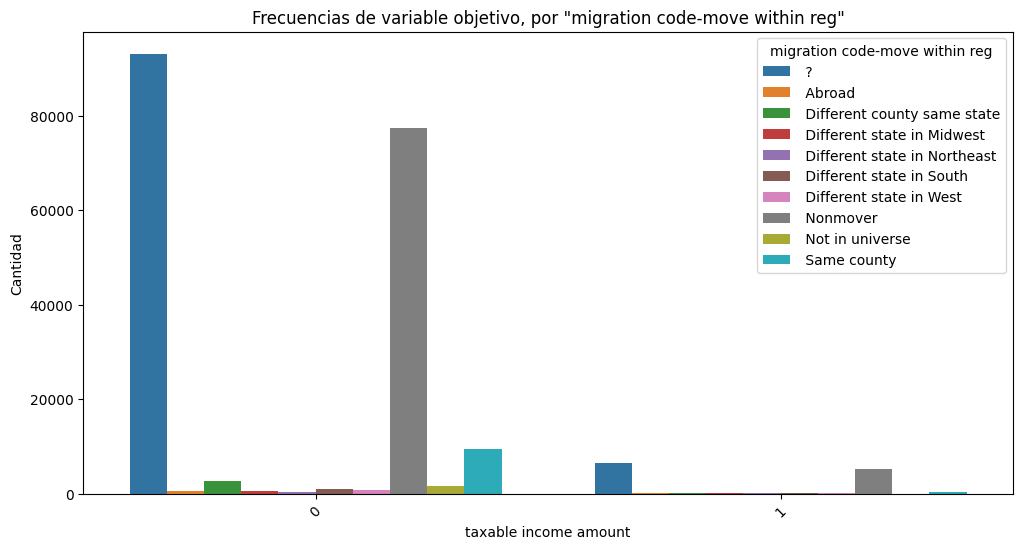

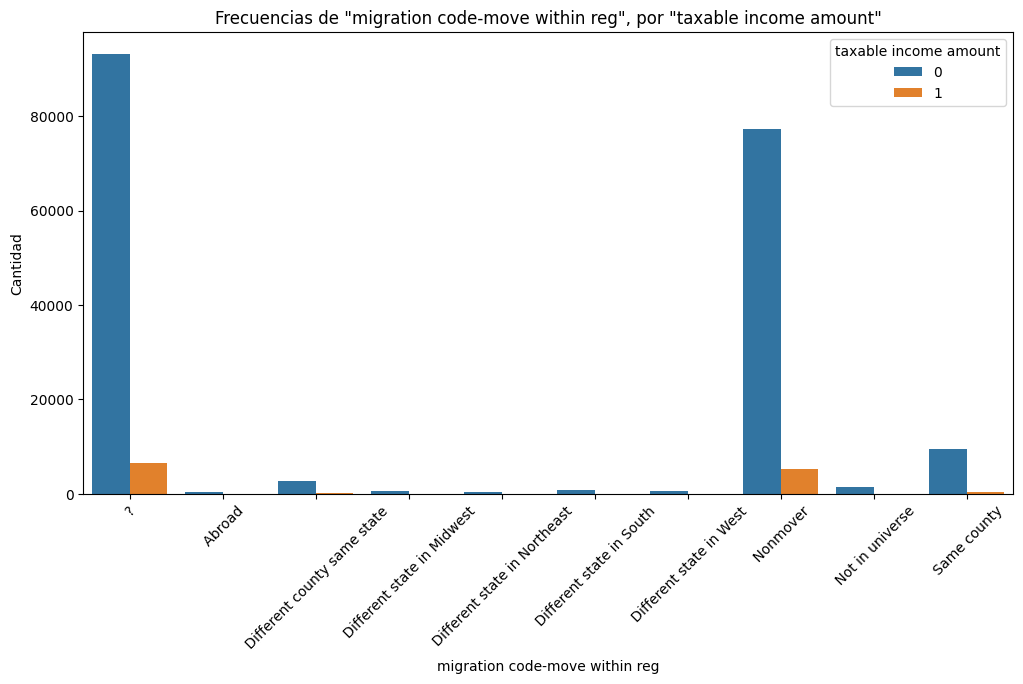

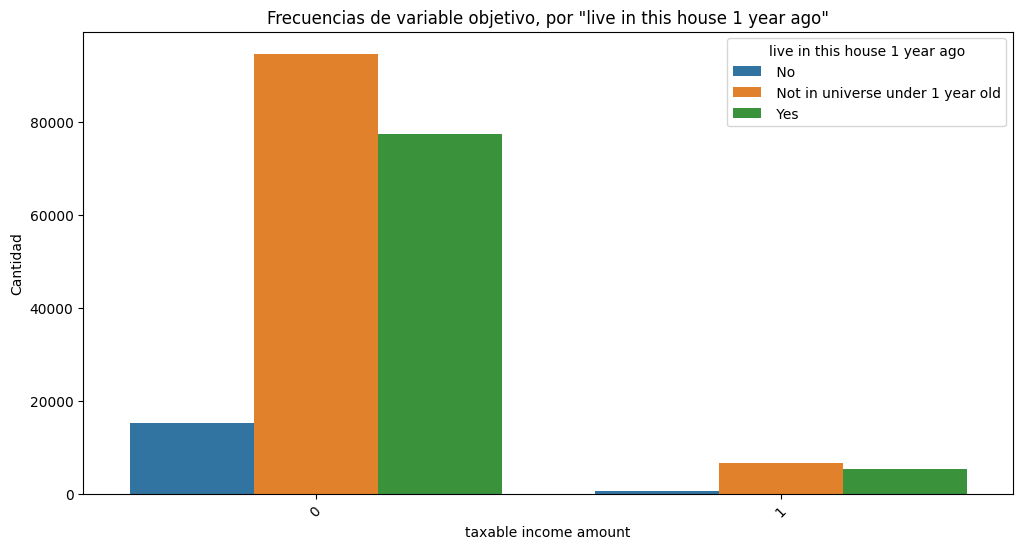

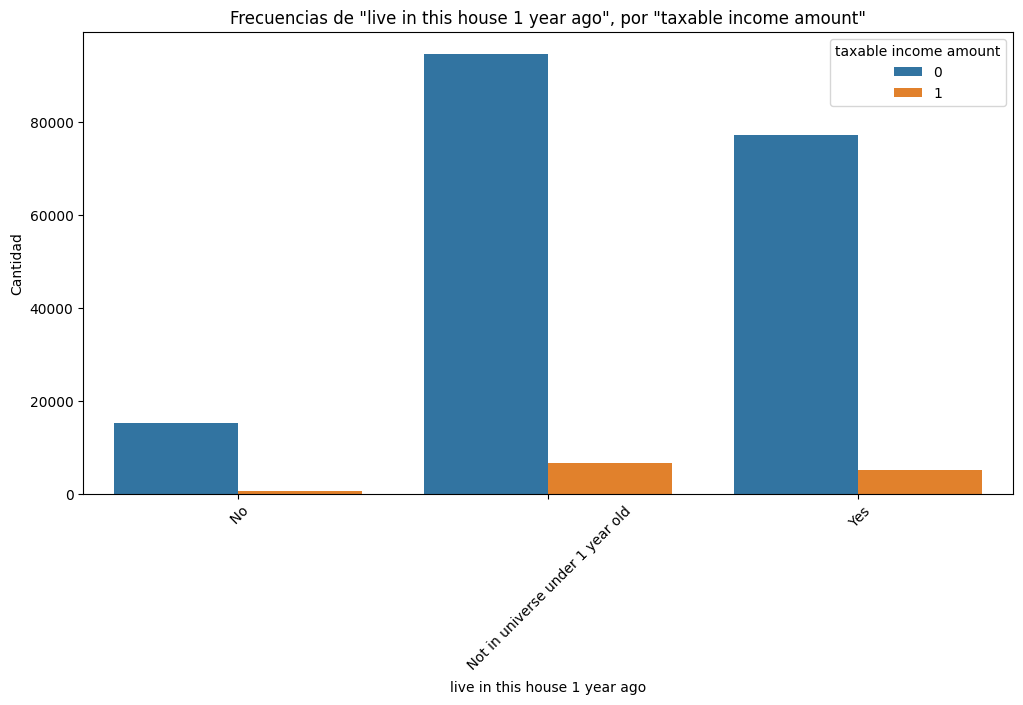

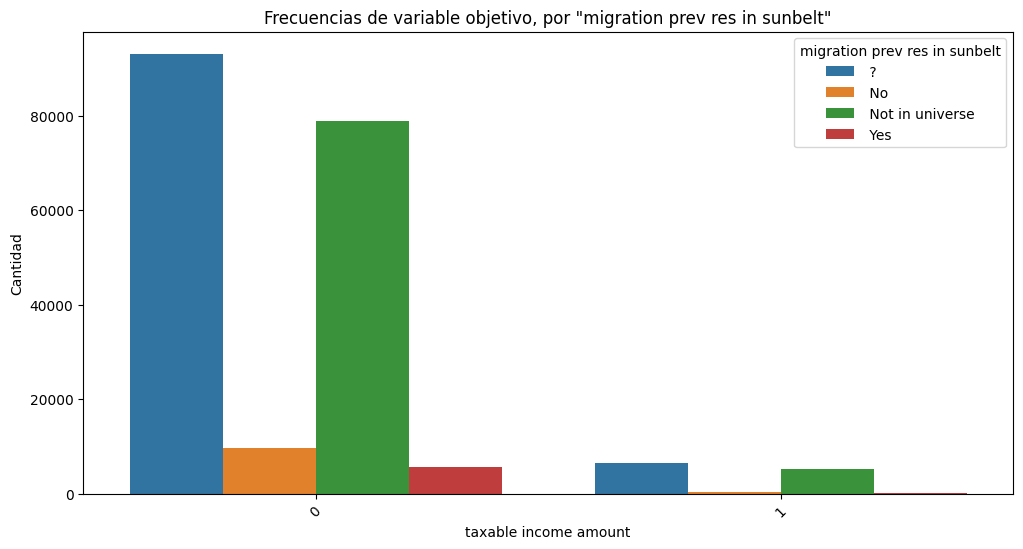

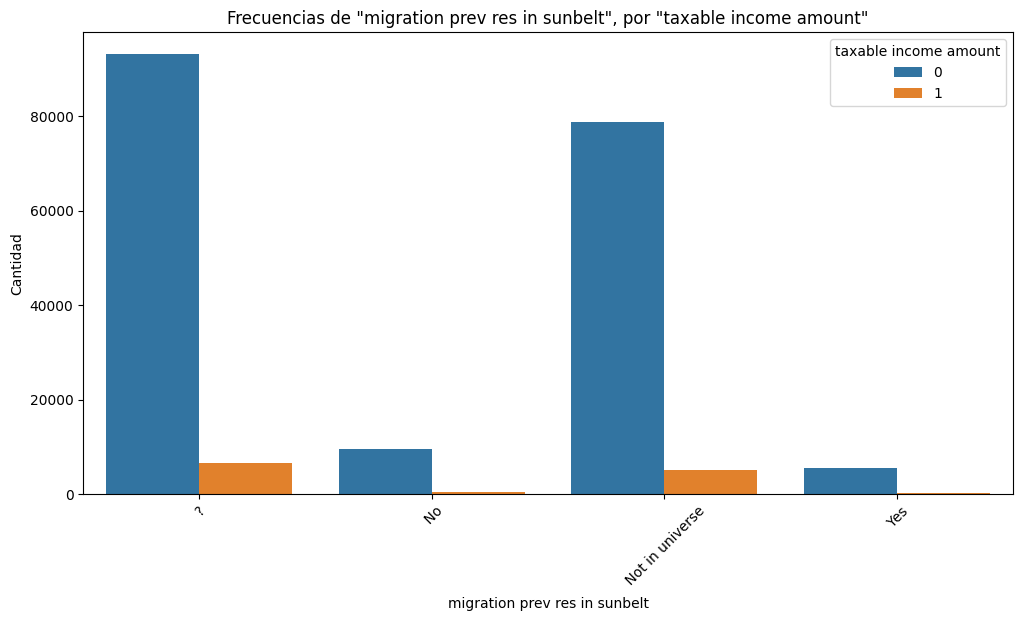

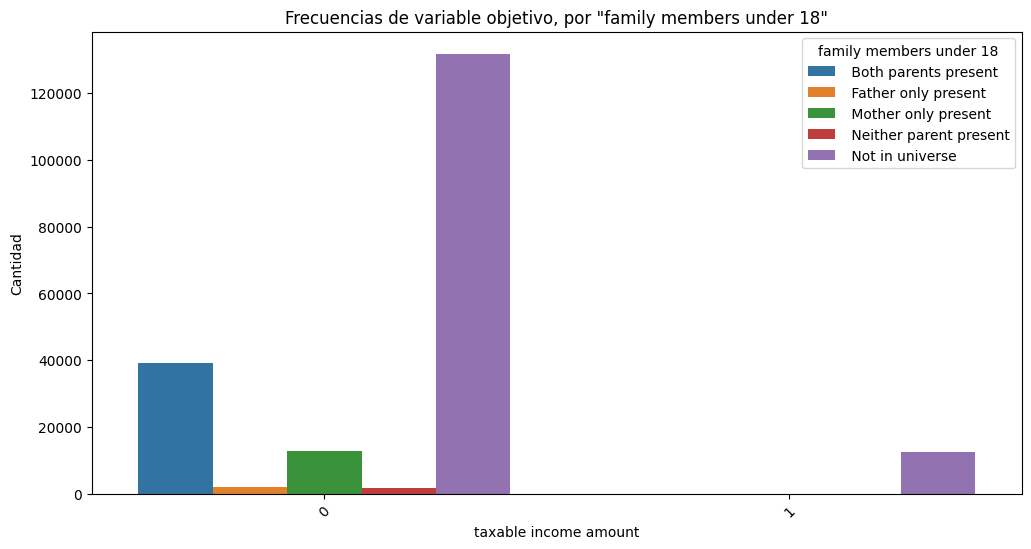

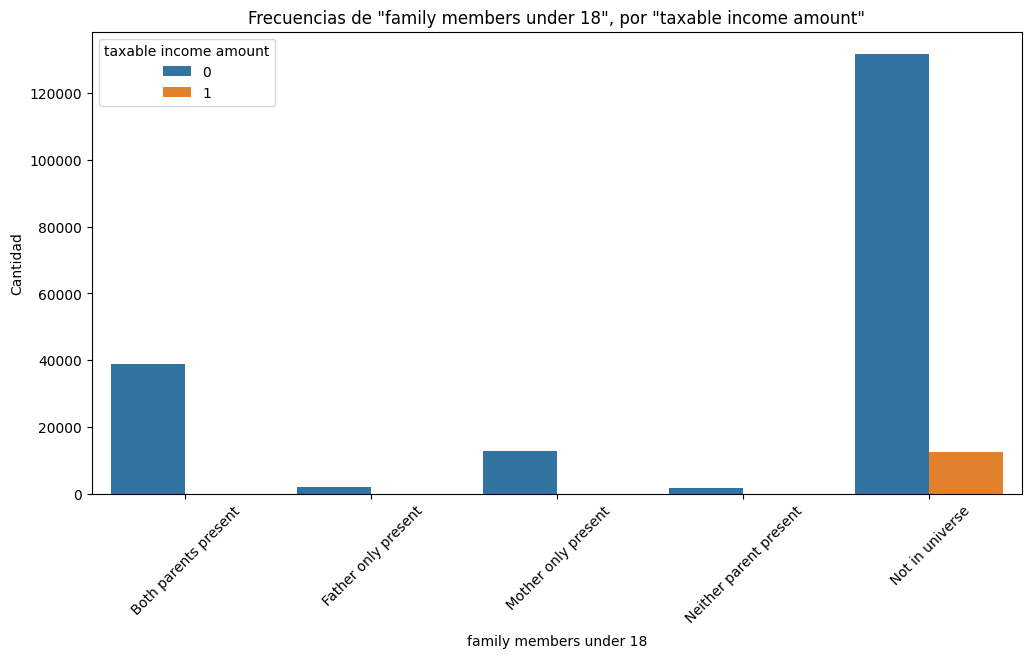

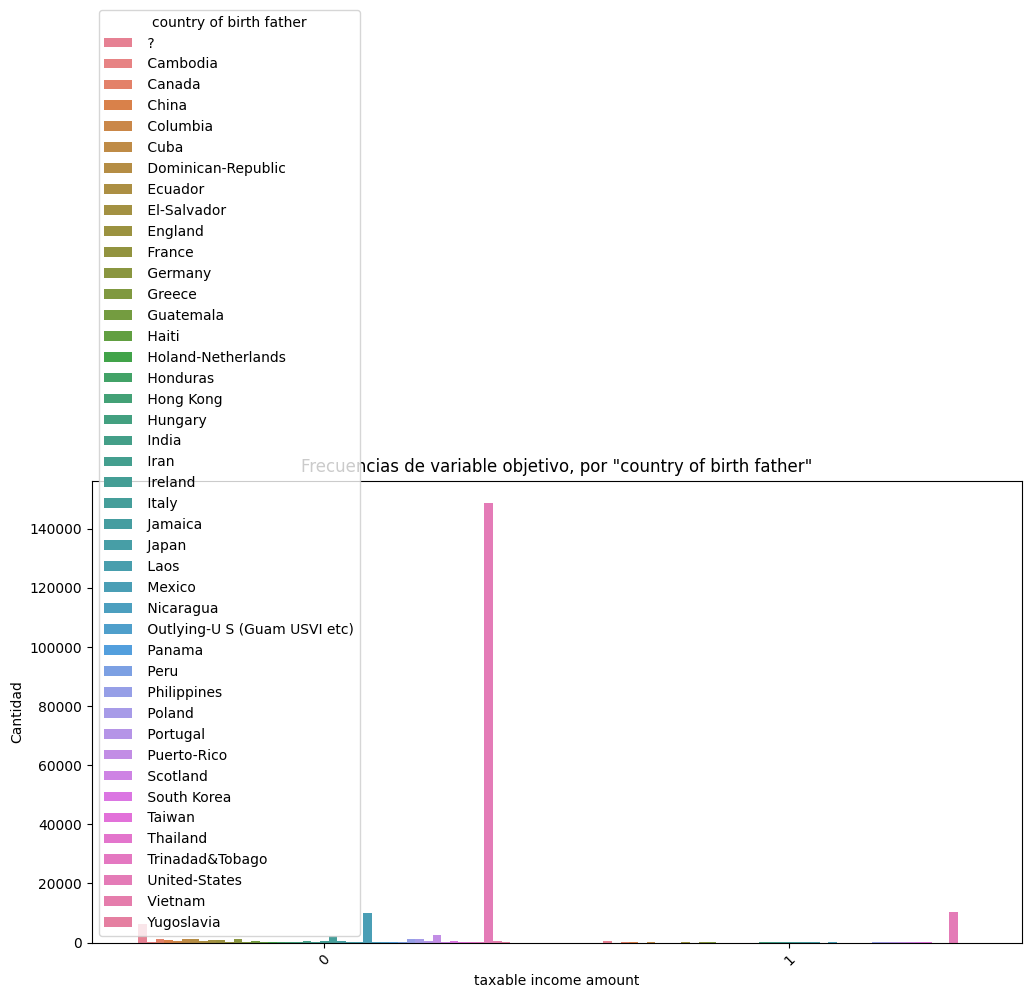

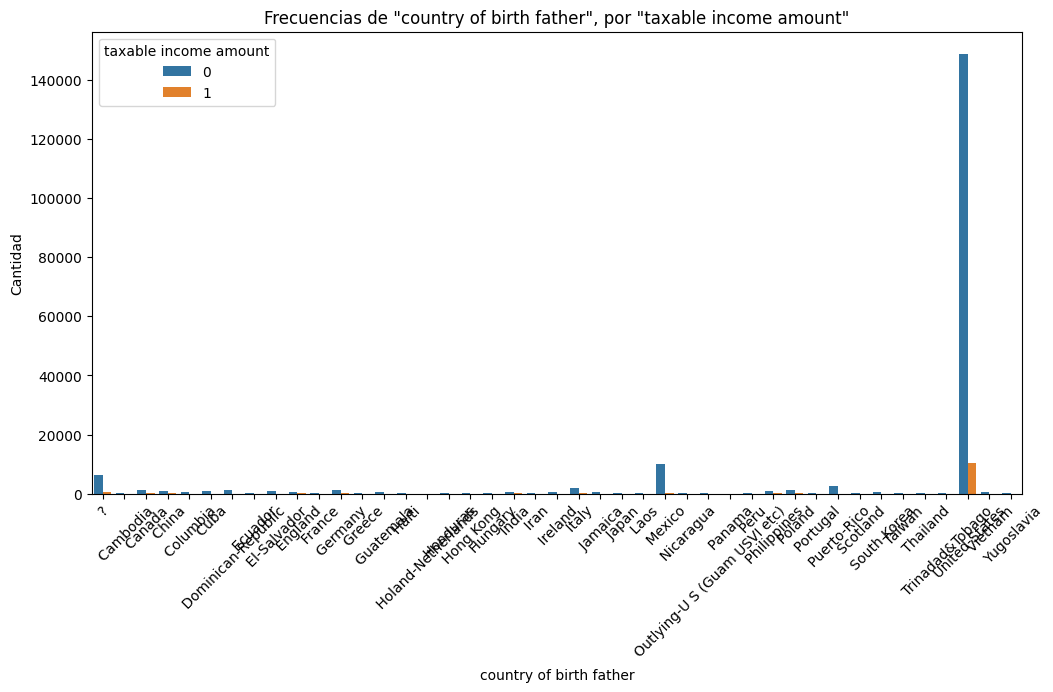

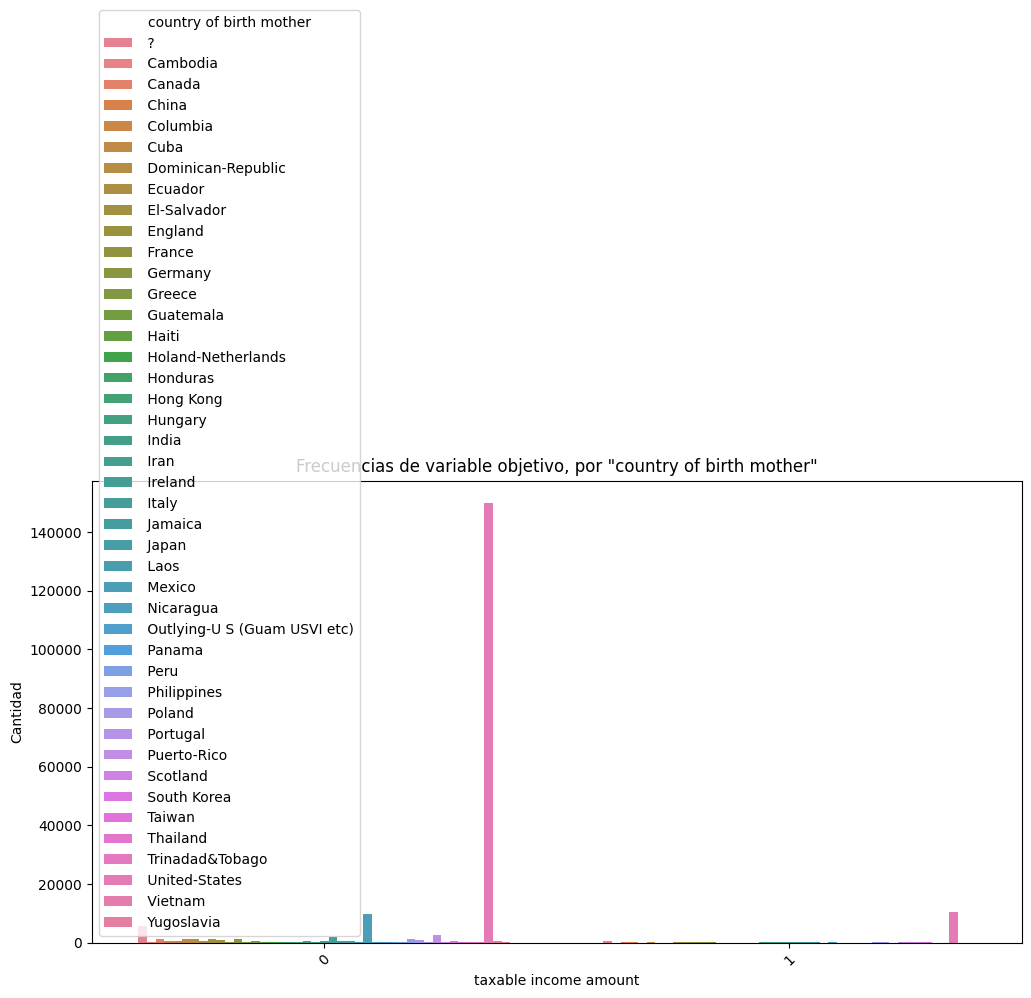

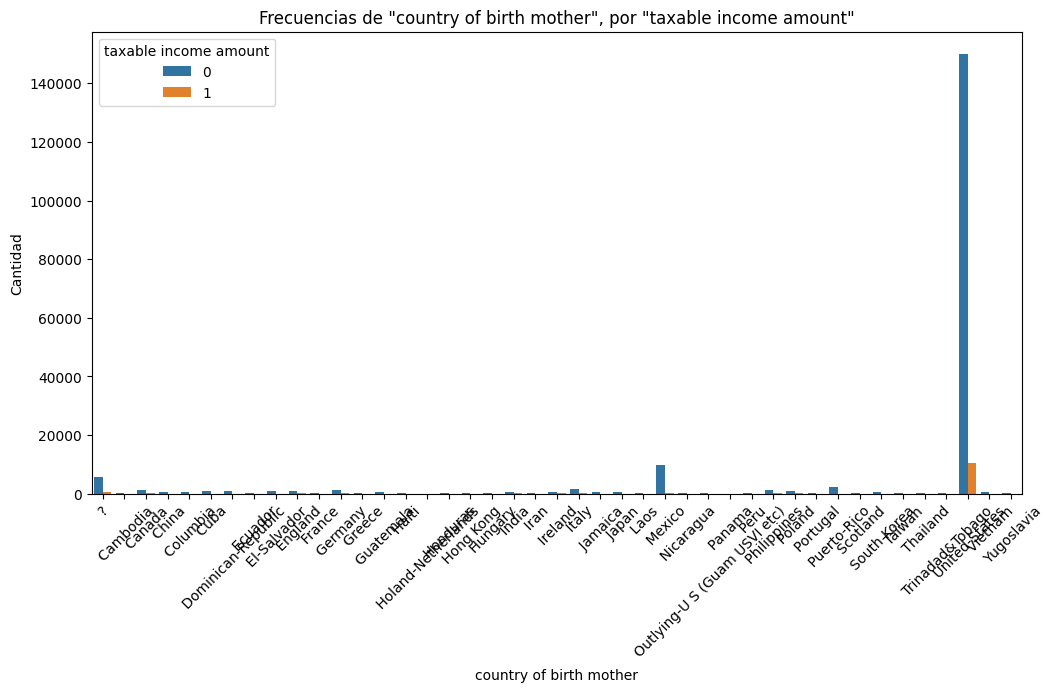

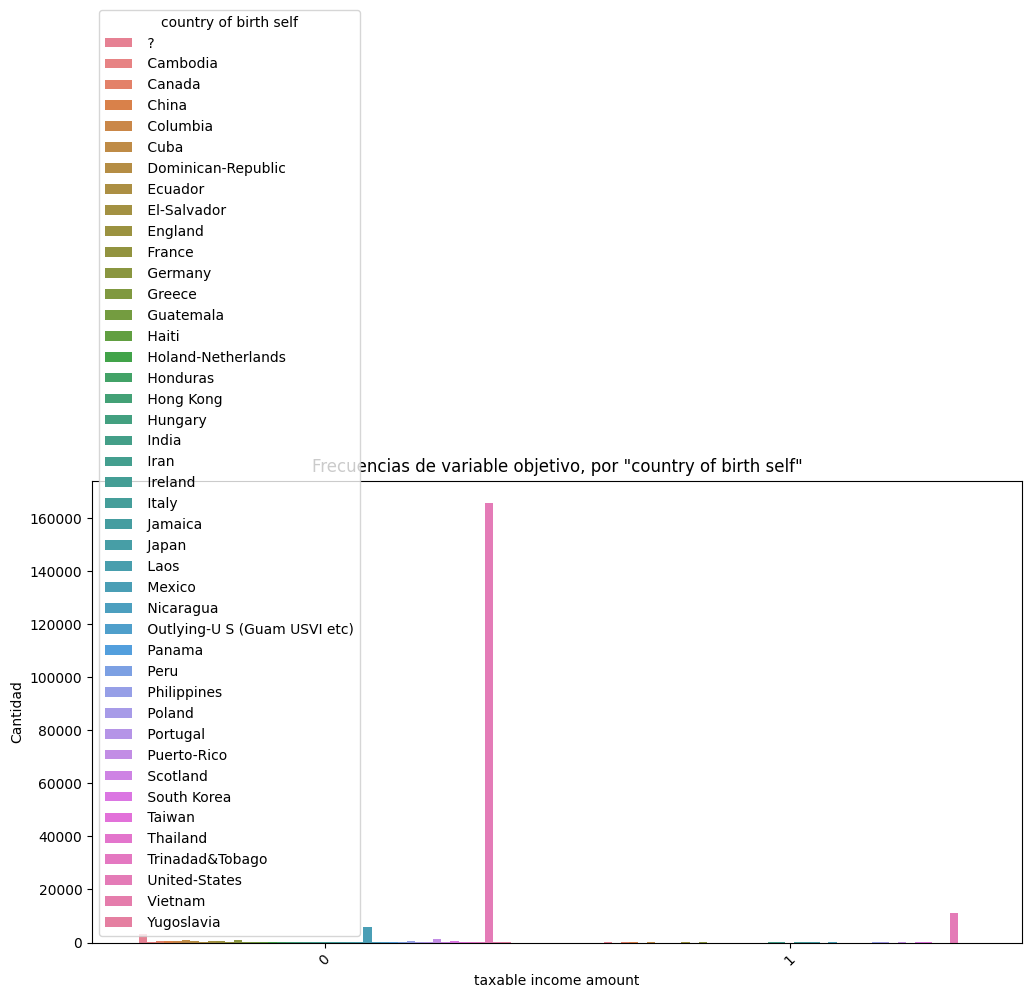

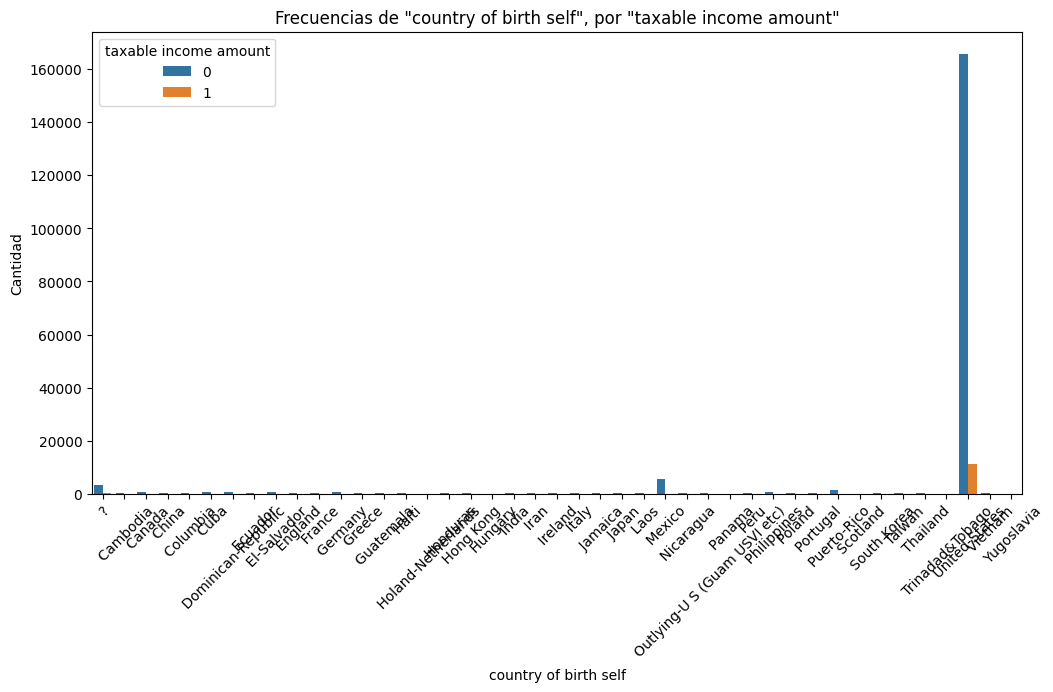

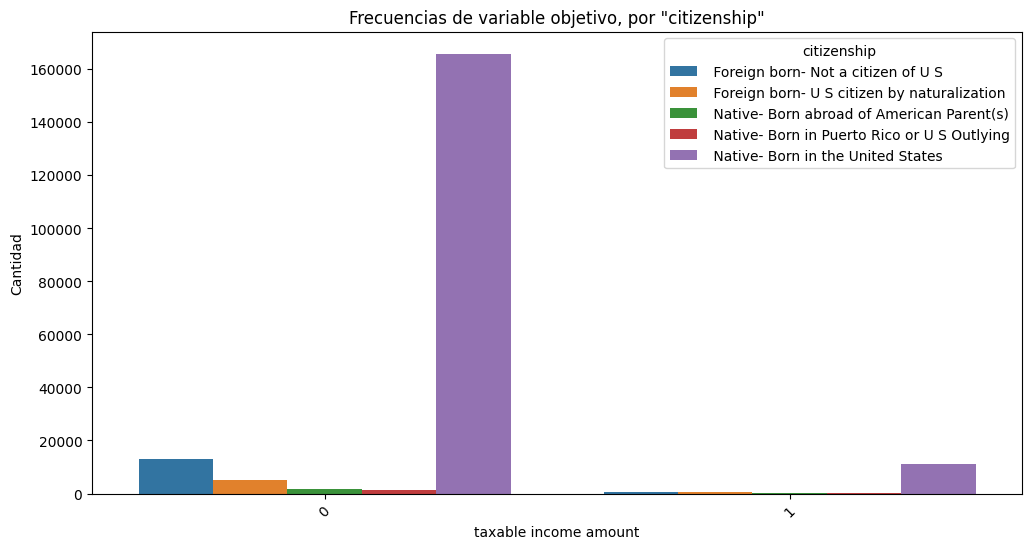

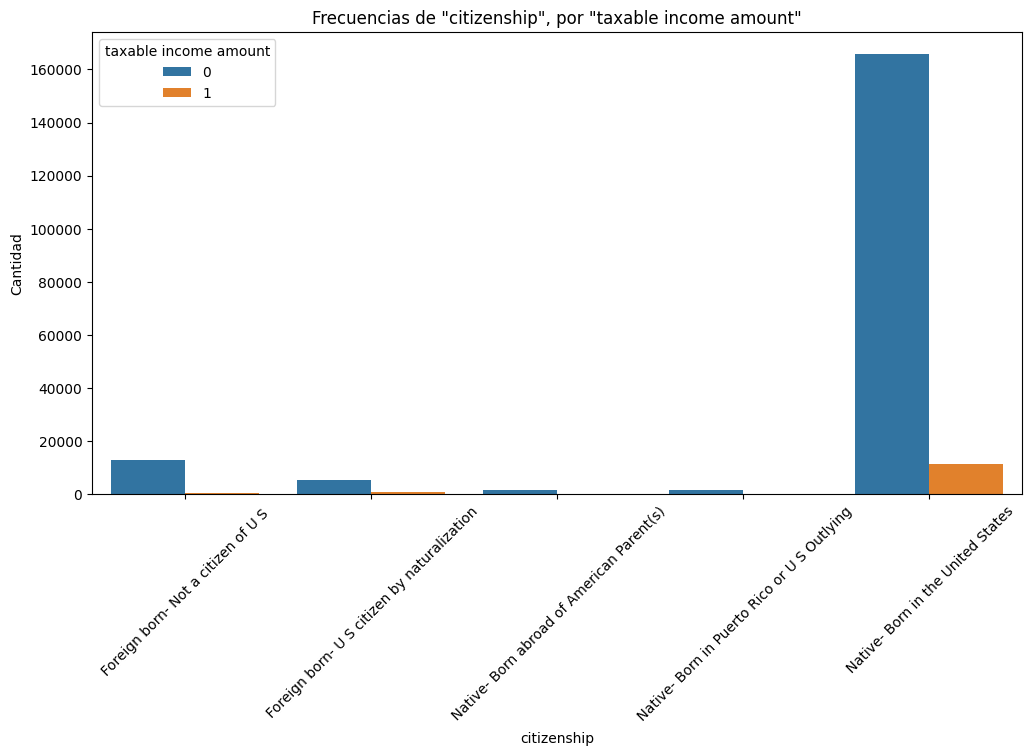

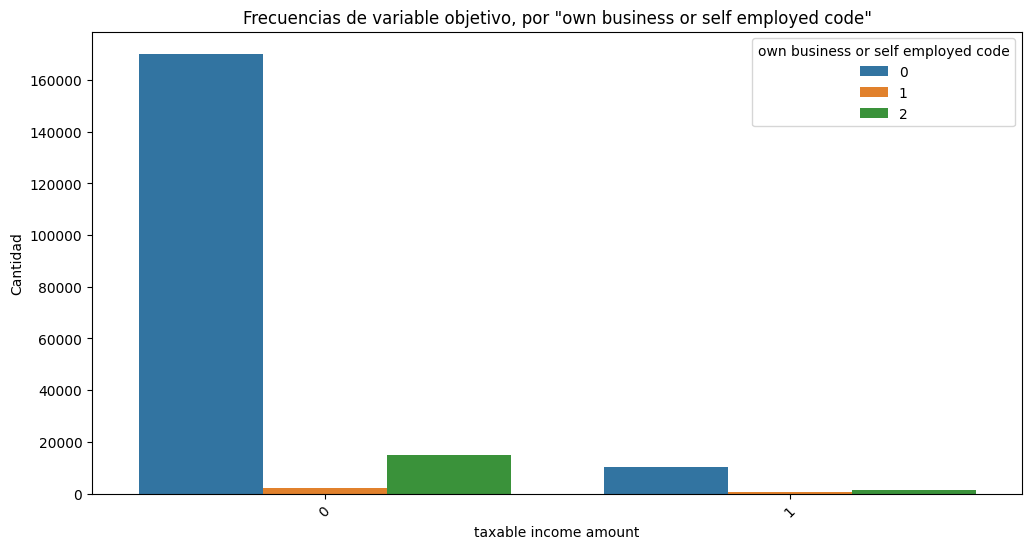

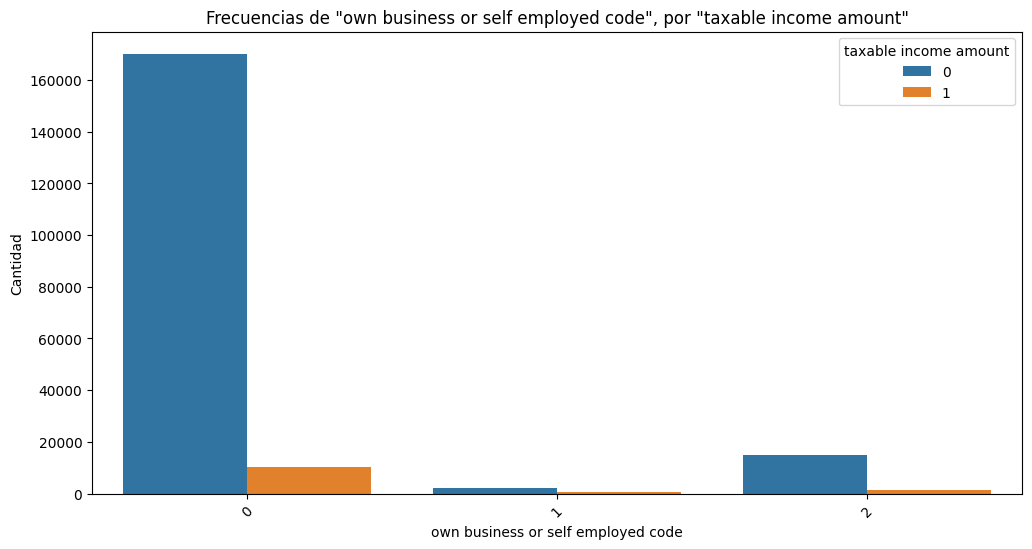

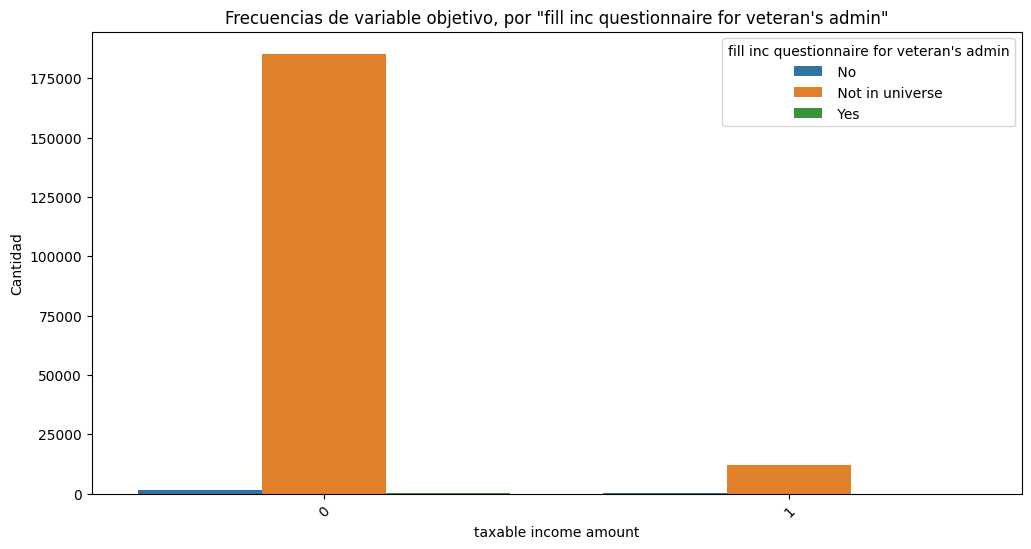

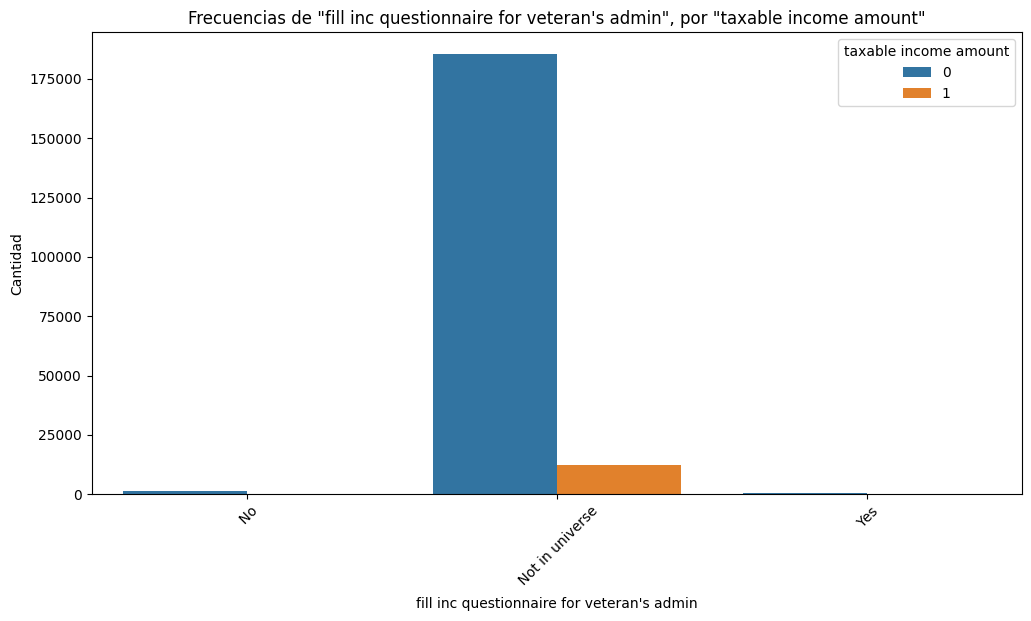

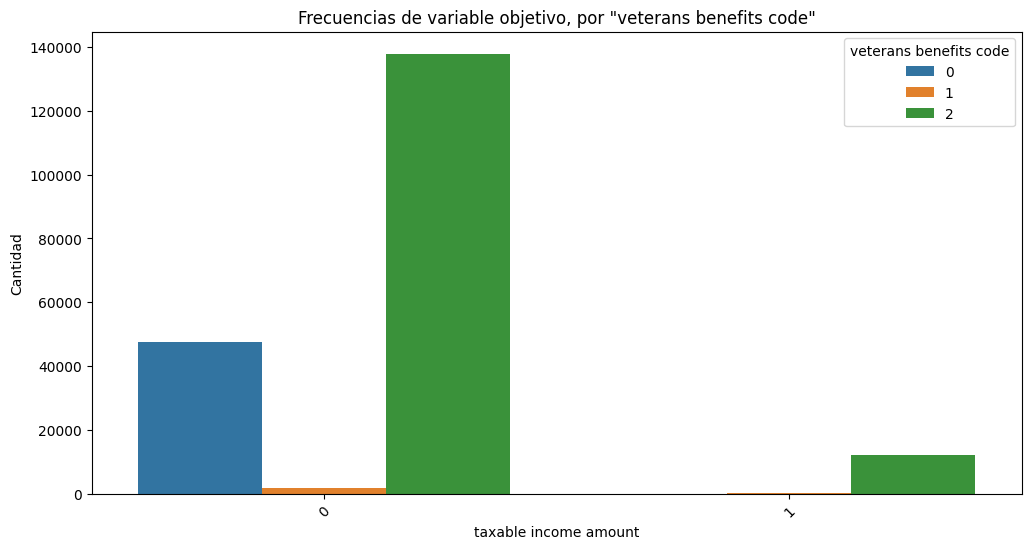

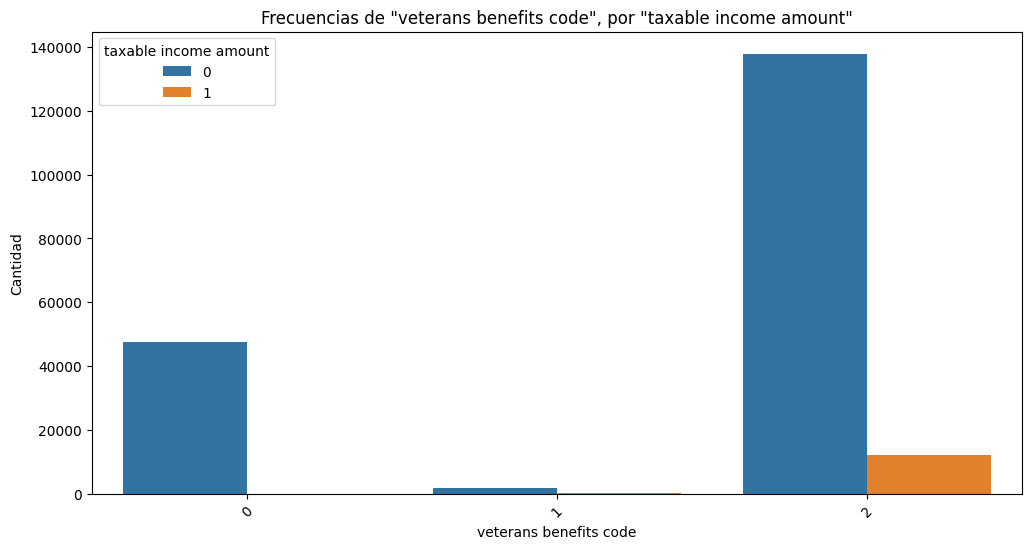

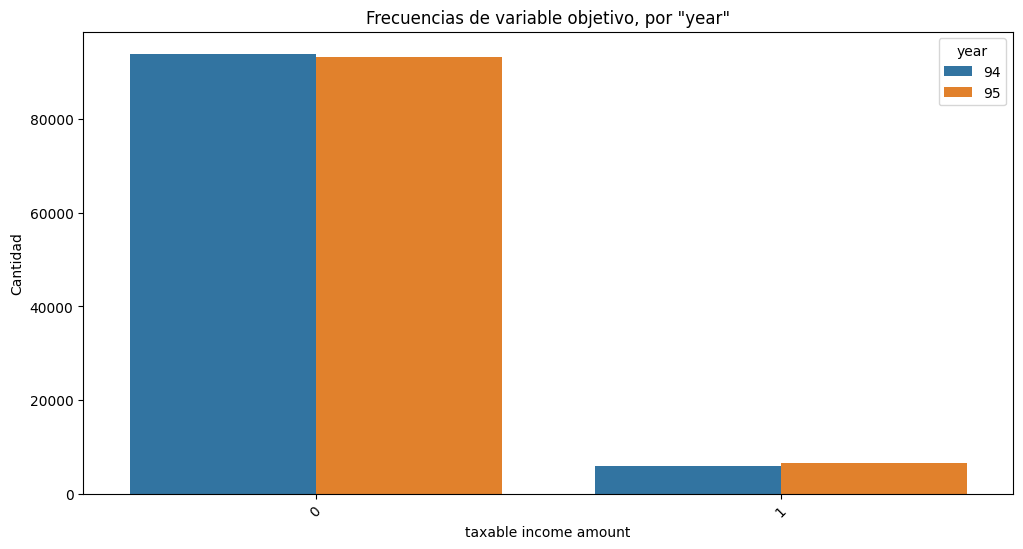

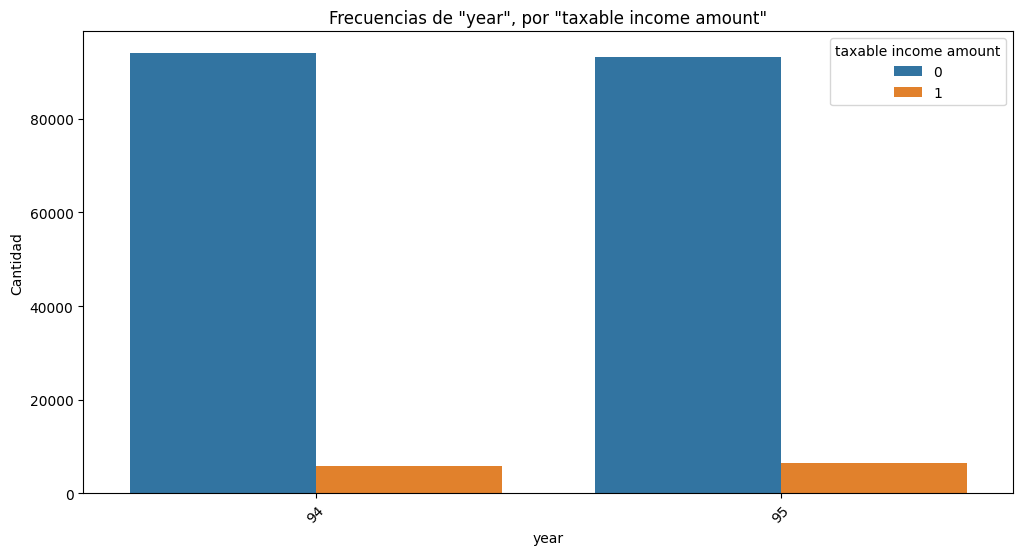

In [9]:
for pred_cat in PREDICTORES_CATEGORICOS:
  frecuencias = datos.groupby([COLUMNA_OBJETIVO, pred_cat]).size().reset_index(name = 'Cantidad')

  # Frecuencias de la variable objetivo en cada clase del predictor categórico
  plt.figure(figsize = (12, 6))
  sns.barplot(x = COLUMNA_OBJETIVO, y = 'Cantidad', hue = pred_cat, data = frecuencias)
  plt.title(f'Frecuencias de variable objetivo, por "{pred_cat}"')
  plt.xticks(rotation = 45)
  plt.show()

  # Frecuencias de las clases del predictor categórico, en cada clase de la variable objetivo
  plt.figure(figsize = (12, 6))
  sns.barplot(x = pred_cat, y = 'Cantidad', hue = COLUMNA_OBJETIVO, data = frecuencias)
  plt.title(f'Frecuencias de "{pred_cat}", por "{COLUMNA_OBJETIVO}"')
  plt.xticks(rotation = 45)
  plt.show()

Notamos que todos los predictores categóricos satisfacen el escenario A
y el escenario B.1 . Sin embargo, ningún predictor categórico 
cumple el escenario B.2 .

### Comparación entre variables numéricas y variable objetivo

Escenario:

Se espera que los predictores numéricos más importantes para la
predicción cumplan que sus distribuciones condicionales, respecto
a los valores (1 y 0) de la variable objetivo sean significativamente
diferentes.

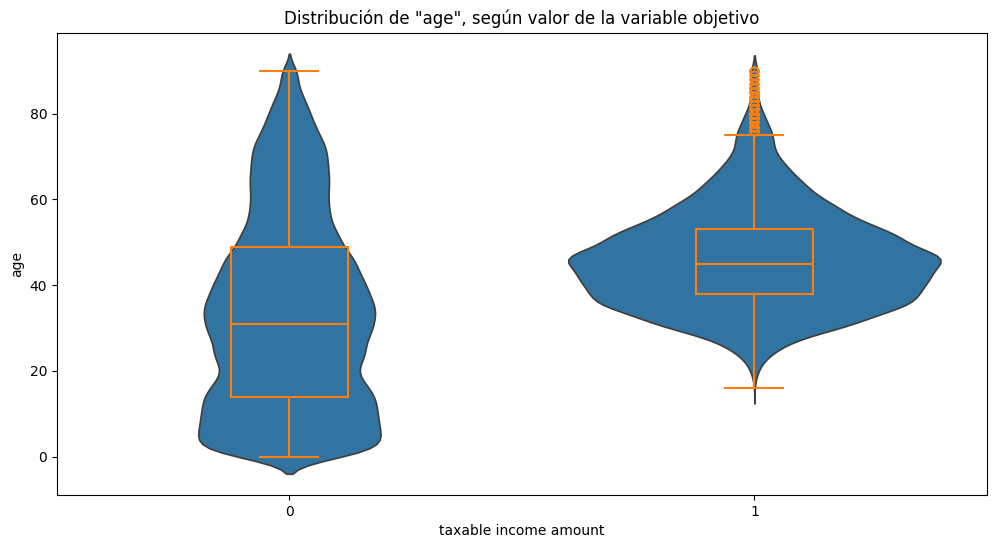

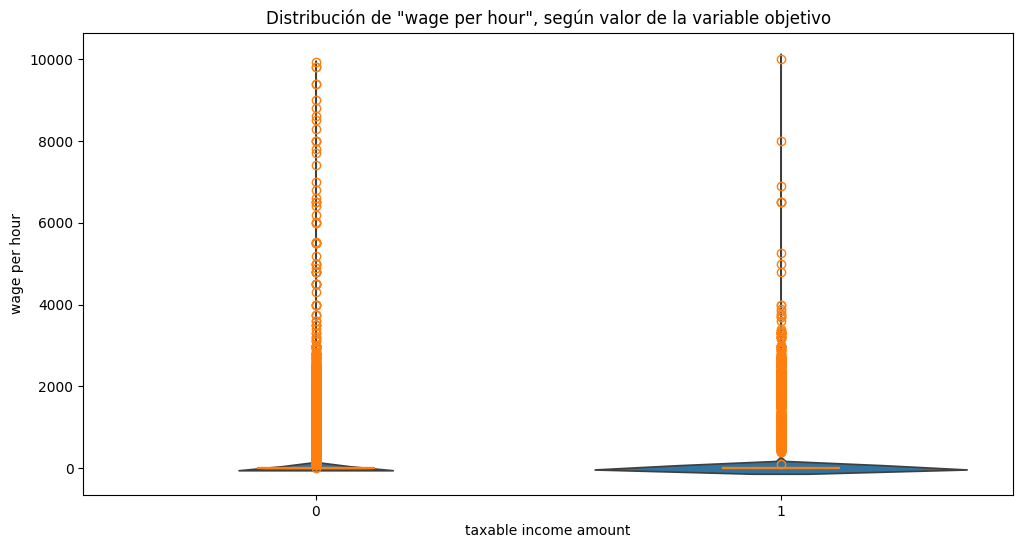

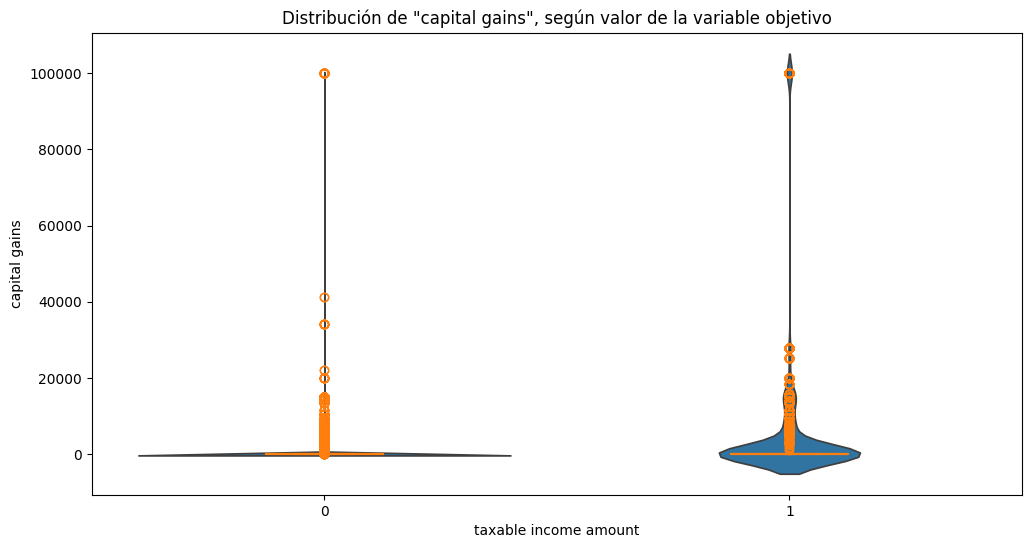

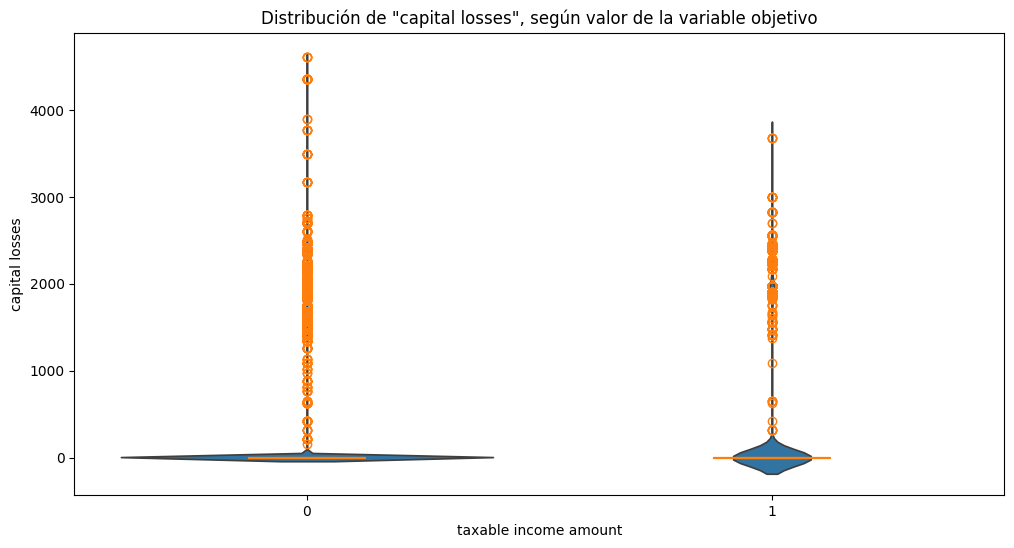

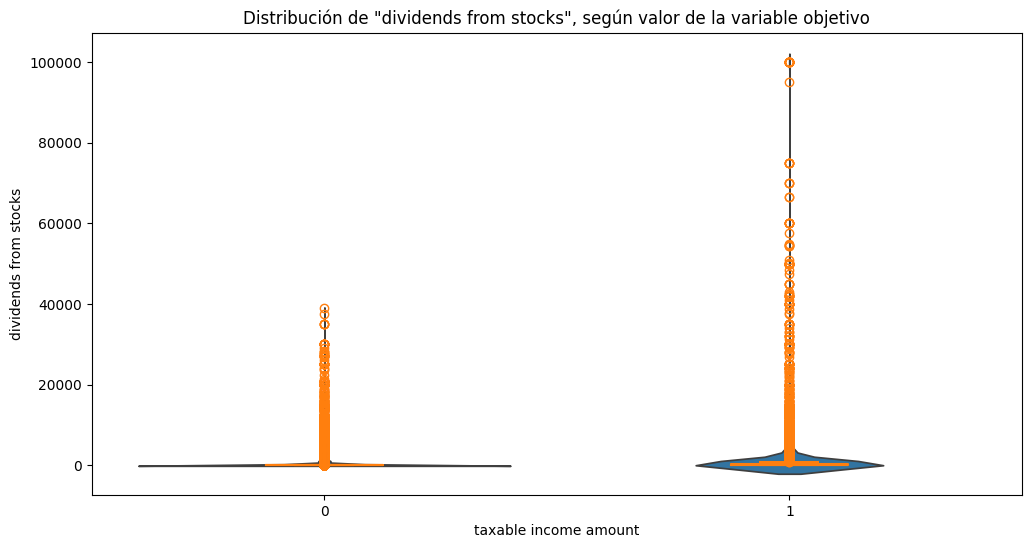

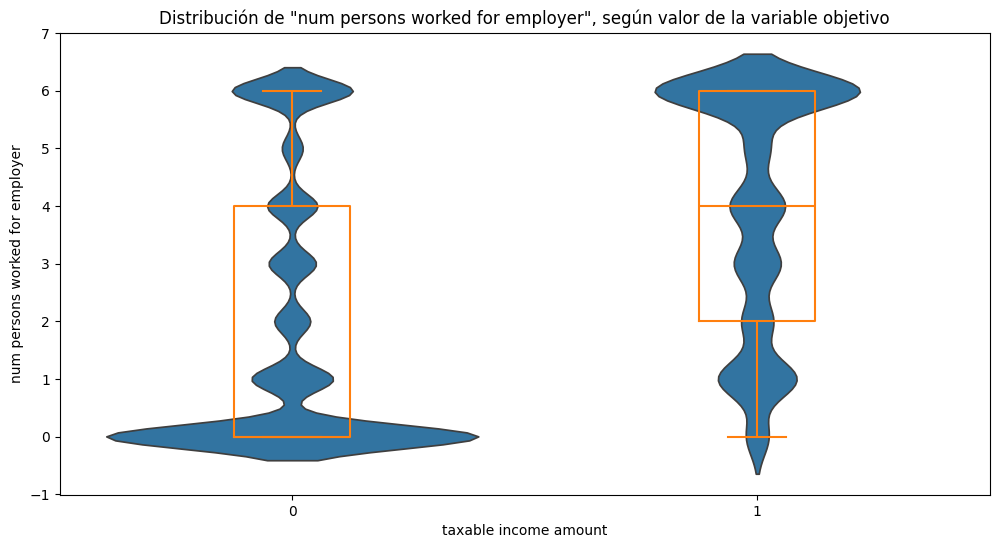

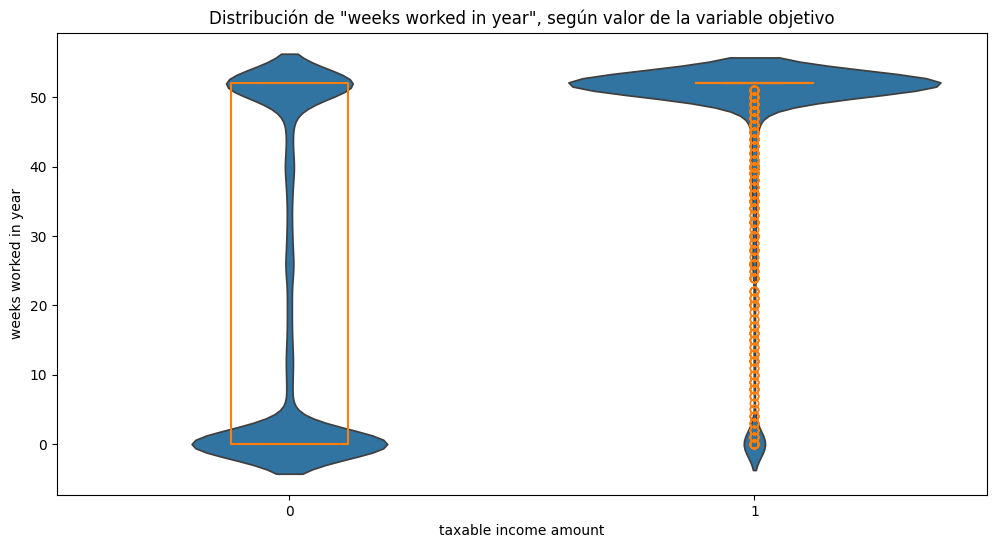

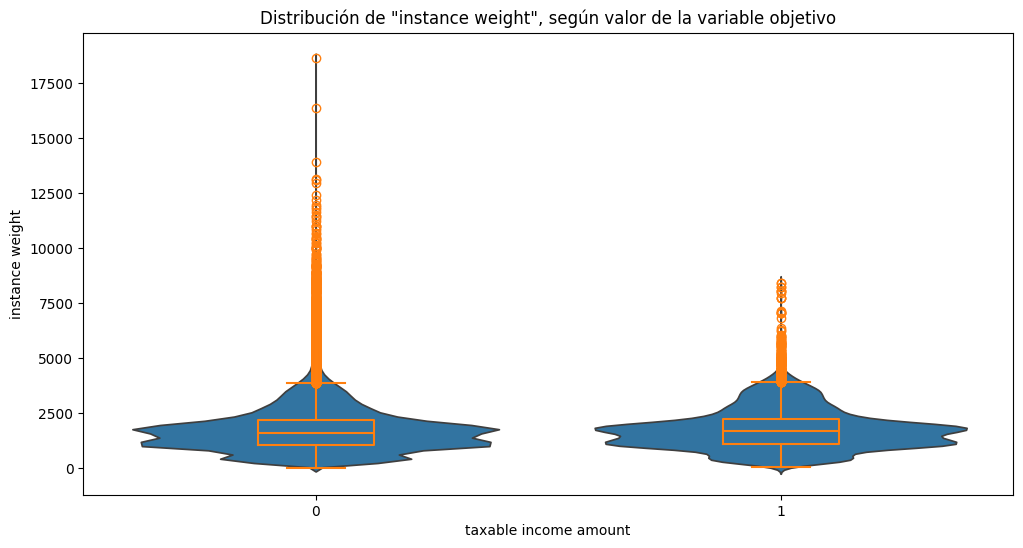

In [10]:
for var_num in VARIABLES_NUMERICAS:
  plt.figure(figsize = (12, 6))
  sns.violinplot(x = COLUMNA_OBJETIVO, y = var_num, data = datos, inner = None)
  sns.boxplot(
    x = COLUMNA_OBJETIVO, 
    y = var_num, 
    data = datos, 
    width = 0.25,
    fill = False
  )
  plt.title(f'Distribución de "{var_num}", según valor de la variable objetivo')
  plt.show()

Notamos que todos los predictores numéricos satisfacen el escenario
planteado. Por otro lado, la variable numérica "instance weight" no
cumple tal escenario. Mas, aquella variable se ha documentado no 
emplearla como predictor.

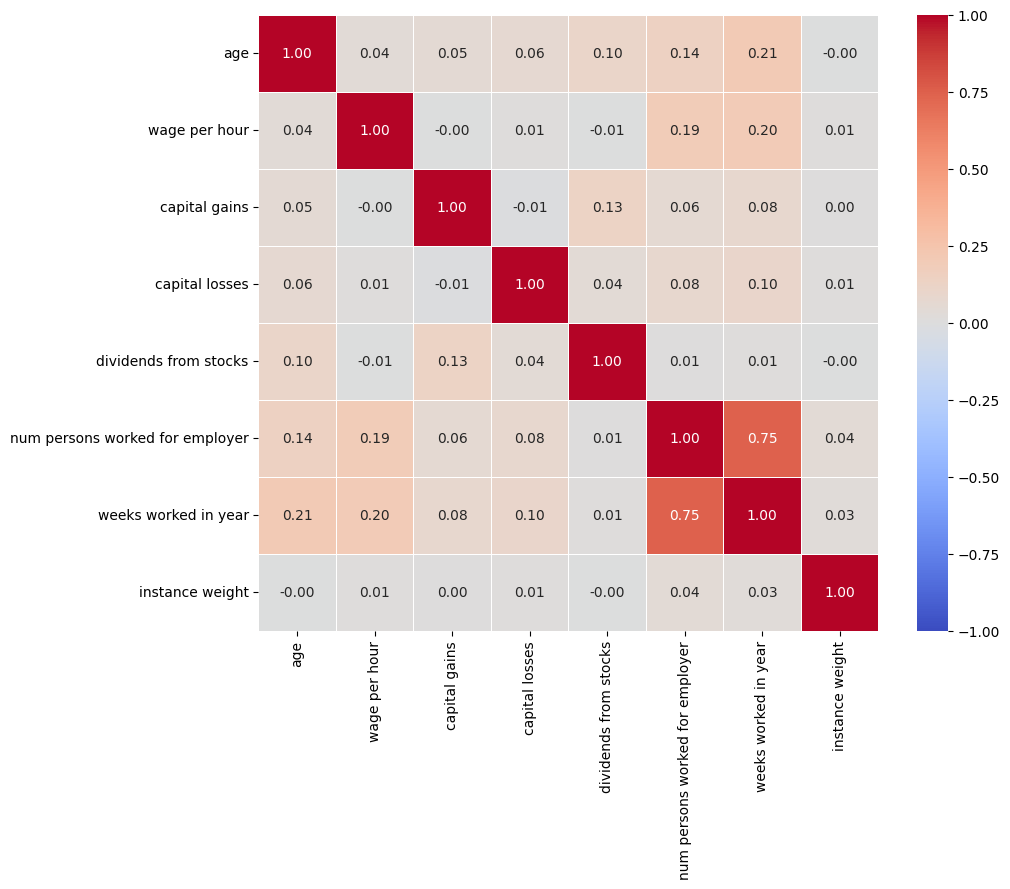

In [11]:
# Correlación entre las variables numéricas
matriz_de_correlaciones = datos[VARIABLES_NUMERICAS].corr()

plt.figure(figsize = (10, 8))
sns.heatmap(
  matriz_de_correlaciones, 
  annot = True, 
  cmap = 'coolwarm', 
  vmin = -1, 
  vmax = 1, 
  fmt = '.2f',
  linewidths = 0.5
)
plt.show()

No existe correlación lineal significativa entre ningún par de 
predictores numéricos diferentes, salvo por 
"num persons worked for employer" y "weeks worked in year",
pues presentan una correlación positiva de 0.75 .

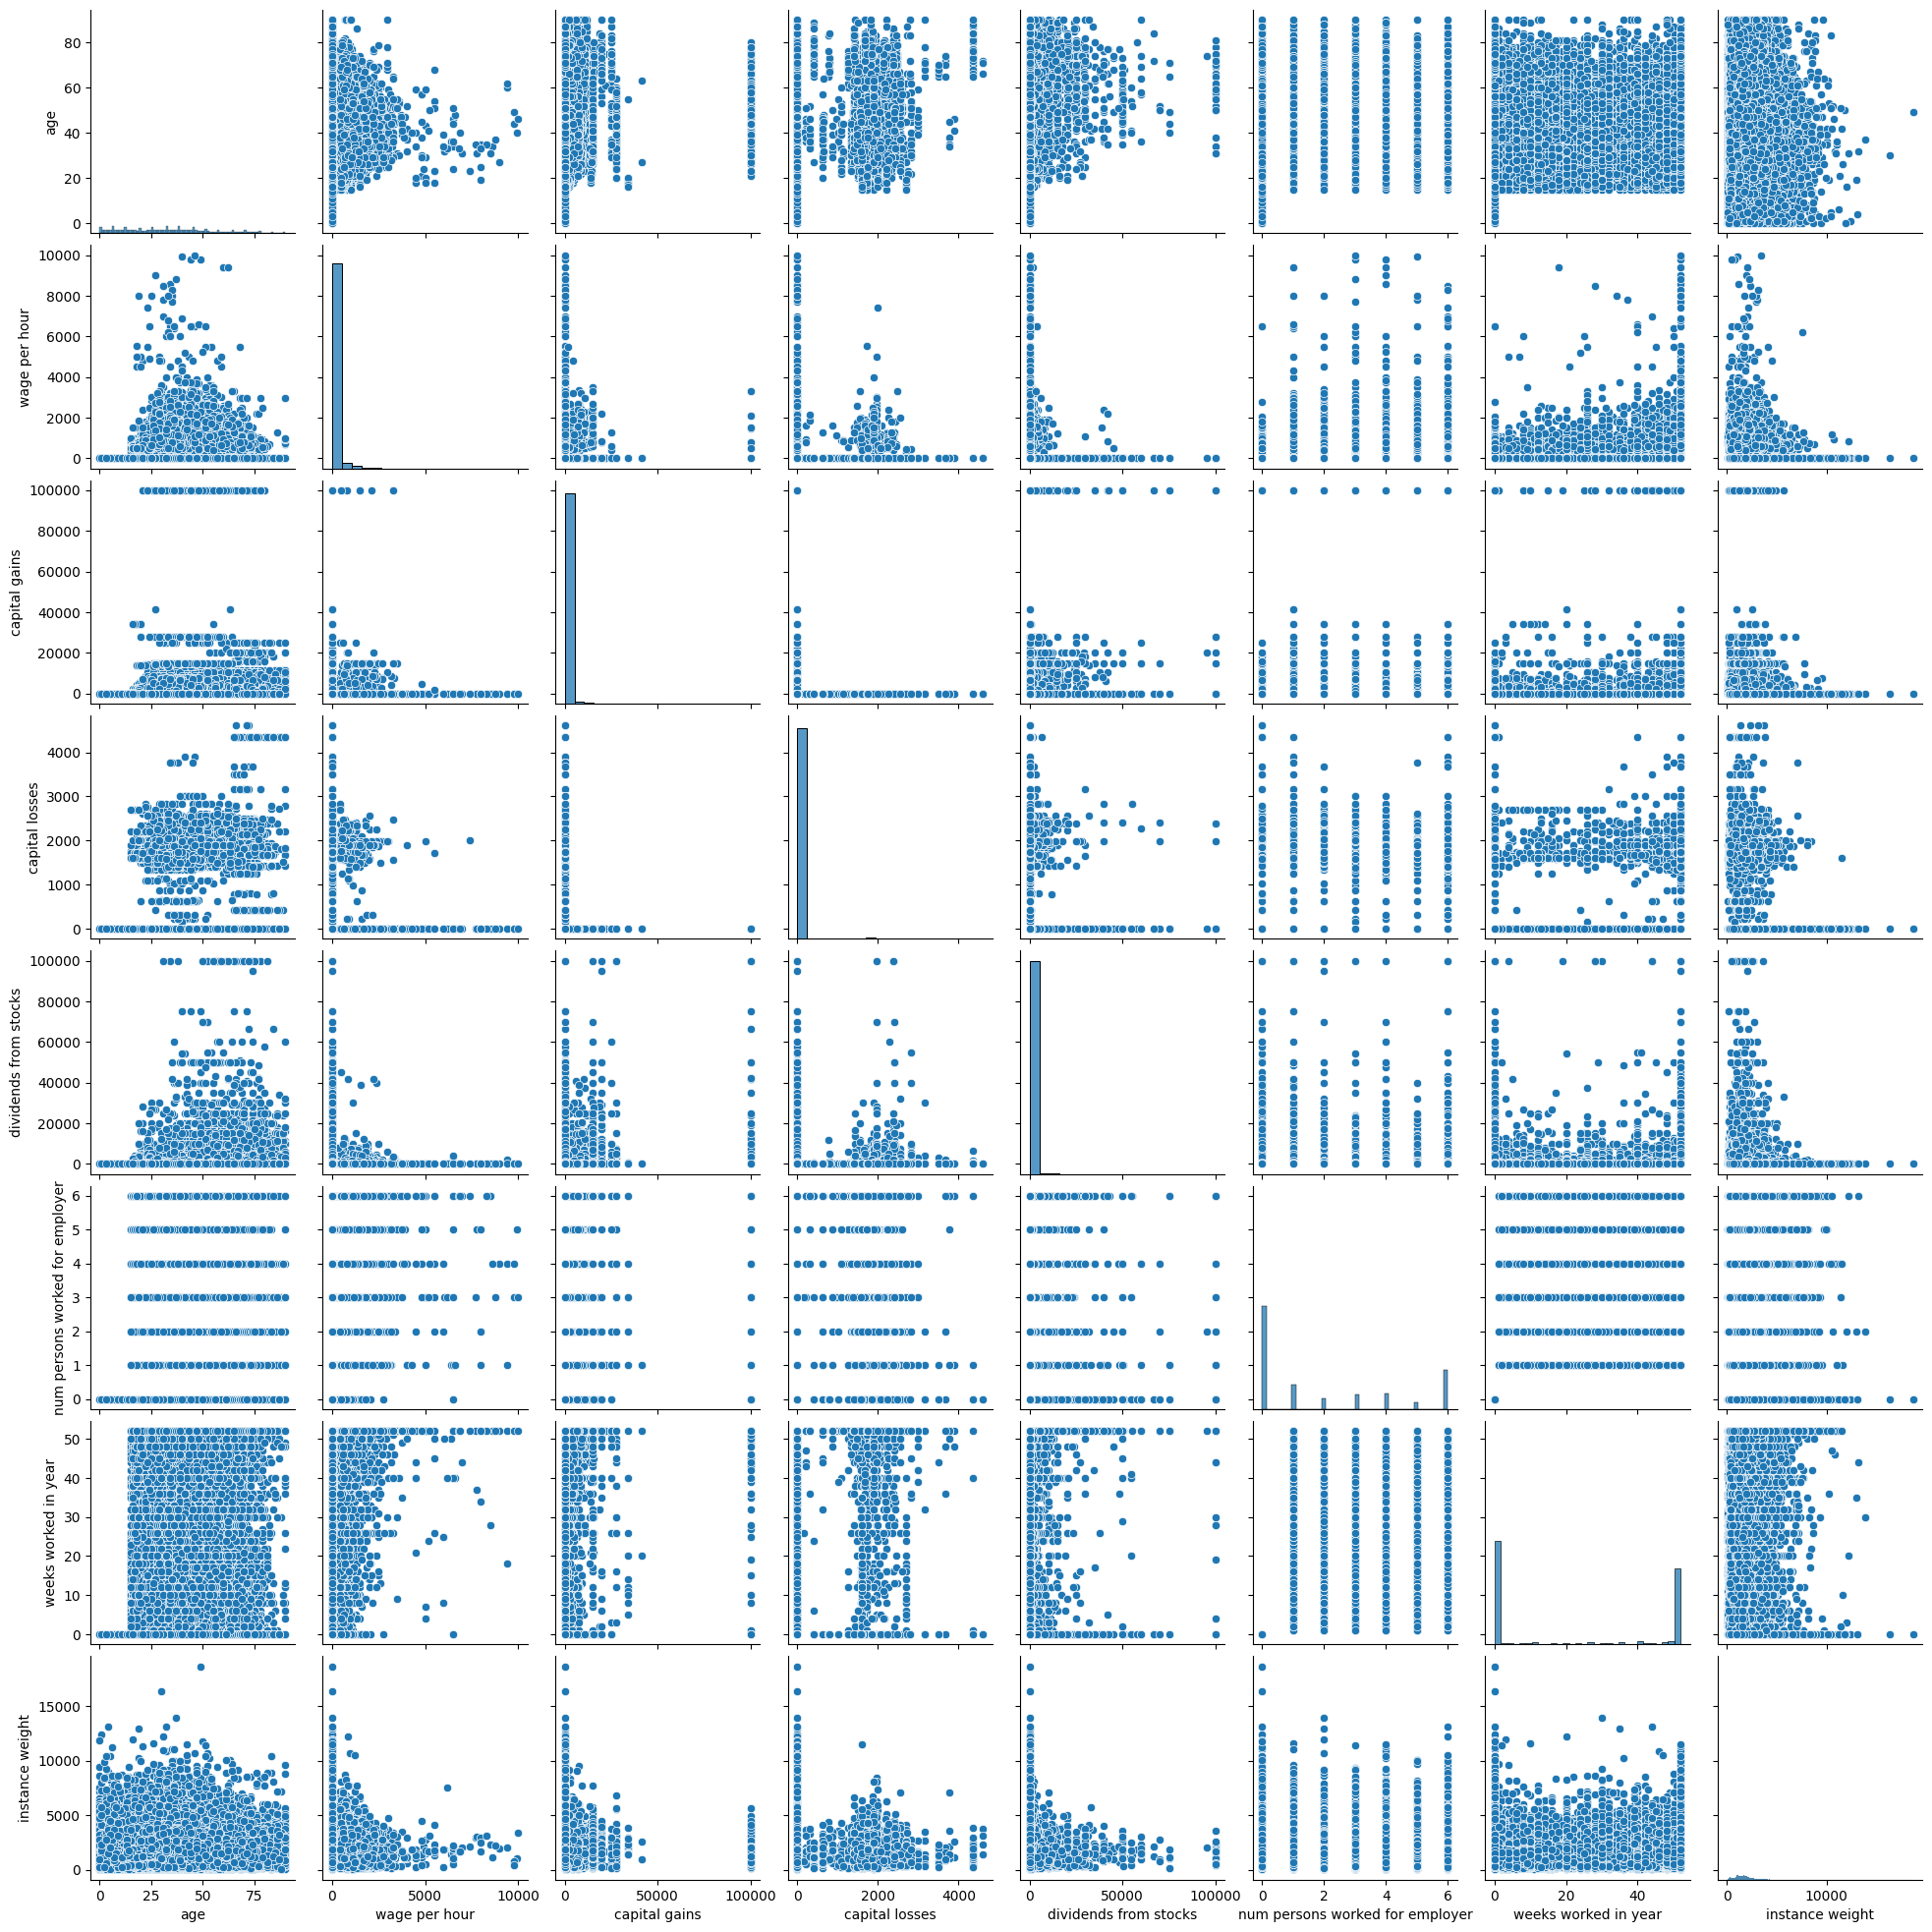

In [12]:
sns.pairplot(datos[VARIABLES_NUMERICAS])

En el gráfico de dispersión, notamos que, pese a la correlación de 0.75 entre los predictores
numéricos "num persons worked for employer" y "weeks worked in year", no es un valor tan significativo como para evidenciarse gráficamente una recta que describa la interacción entre aquel par de predictores. 

Por ello, no descartaremos ninguno de ese par de predictores.

In [13]:
# Análisis de multicolinearidad entre predictores numéricos,
# por medio del factor de inflación de la varianza (VIF)
X = add_constant(datos[PREDICTORES_NUMERICOS])

vif_data = pd.DataFrame()
vif_data["predictor"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# No se requiere la variable artificial "const" como predictor
vif_data.iloc[1:]

predictor       VIF
1                              age  1.058670
2                    wage per hour  1.045330
3                    capital gains  1.026261
4                   capital losses  1.014678
5            dividends from stocks  1.029668
6  num persons worked for employer  2.277291
7             weeks worked in year  2.348062

Como los VIF de los predictores numéricos son muy cercanos a 1, y menores que 3,
concluimos que no existe multicolinearidad significativa entre los predictores numéricos.

Entonces, podemos emplear, más adelante, el modelo de regresión logística e interpretar
los coeficientes que produce tras ser entrenado.